<a href="https://colab.research.google.com/github/StefanoBergia/Tesi_Anomaly_Detection/blob/main/UNSUPERVISED_ANOMALY_DETECTION_ISOLATION_FOREST_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBRERIE

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import drive
from google.colab import widgets
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
import datetime
import time
import warnings


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


DATASET

In [2]:
min_date='2021-07-24 00:00:00'
max_date='2021-08-27 23:59:00'

drive.mount('/content/gdrive',force_remount=True)
df_original = pd.read_csv('/content/gdrive/MyDrive/Dati_Tesi/PIVOT_WLS_HVST_1_MONTH.csv', parse_dates=['TS'], index_col='TS')
df_original.index = pd.DatetimeIndex(df_original.index)
df_original=df_original.asfreq(freq='60s',method='ffill')
df=df_original.copy()
df=df.loc[min_date:max_date]

columns=df.columns.drop(['431','907']).drop(['436','480','482','777','781','783','910'])

###########
#columns=['430']
##########

period_length=1440

print(columns)

Mounted at /content/gdrive
Index(['272', '430', '776', '780', '782', '784', '908', '909'], dtype='object')


In [3]:
params={
    '272':{'ct':0.015,#0.015
            #'th':4.8,
           'thp':97},
    
    '430':{'ct':0.015,
            #'th':20,
           'thp':93},
        
    '776':{'ct':0.01,
            'th':8,
            'thp':95},
        
    '780':{'ct':0.005,
            #'th':1.5
            'thp':96},
        
    '782':{'ct':0.01,
            #'th':10,
           'thp':95},
        
    '784':{'ct':0.03,
            #'th':10,
           'thp':97},
        
    '908':{'ct':0.01,
            #'th':7,
           'thp':95},
        
    '909':{'ct':0.03,
            #'th':20,
           'thp':95}
}

*   272: OpenSocketsCurrentCount
*   430: OpenSessionCurrentCount
*   480: CompletedRequests
*   482: PendingRequests
*   776: ExecuteThreadIdleCount (sono pronti per essere eseguiti ma attendono un task)
*   777: ExecuteThreadTotalCount
*   780: PendingUserRequestCount
*   782: StandByThreadCount (sono in stato di wait di una risorsa)
*   784: Througput (mean number of request completed per second
*   908: HeapFreePercent
*   909 HeapSizeCurrent






In [4]:
df.head()

272  430  431  ...  908         909         910
TS                                  ...                             
2021-07-24 00:00:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:01:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:02:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:03:36    3   17  224  ...   74  8272216064  8272216064
2021-07-24 00:04:36    3   17  224  ...   74  8272216064  8272216064

[5 rows x 17 columns]

In [5]:
df.tail()

272  430  431  ...  908         909         910
TS                                  ...                             
2021-08-27 23:54:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:55:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:56:36    3   31  188  ...   73  8158445568  8158445568
2021-08-27 23:57:36    3   29  188  ...   73  8158445568  8158445568
2021-08-27 23:58:36    4   31  188  ...   72  8158445568  8158445568

[5 rows x 17 columns]

In [6]:
print(len(df.index))

50399


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

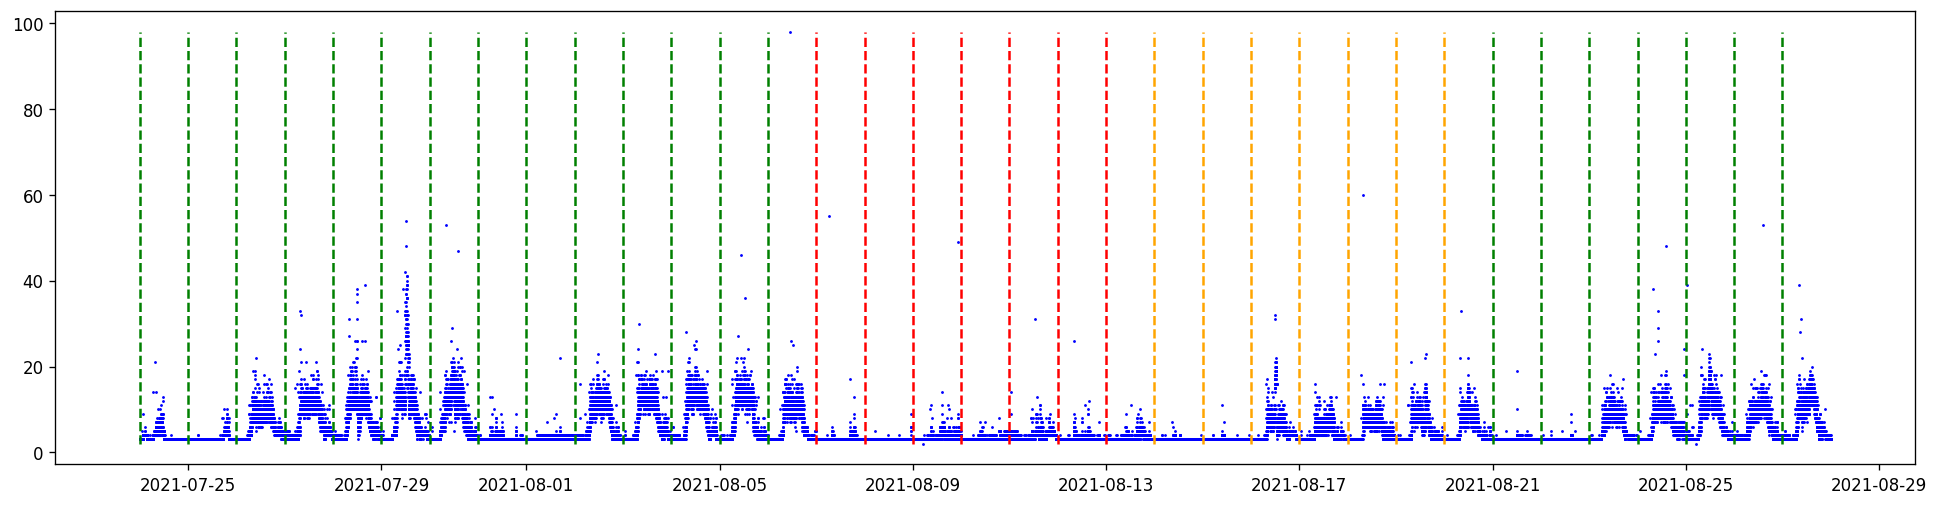

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

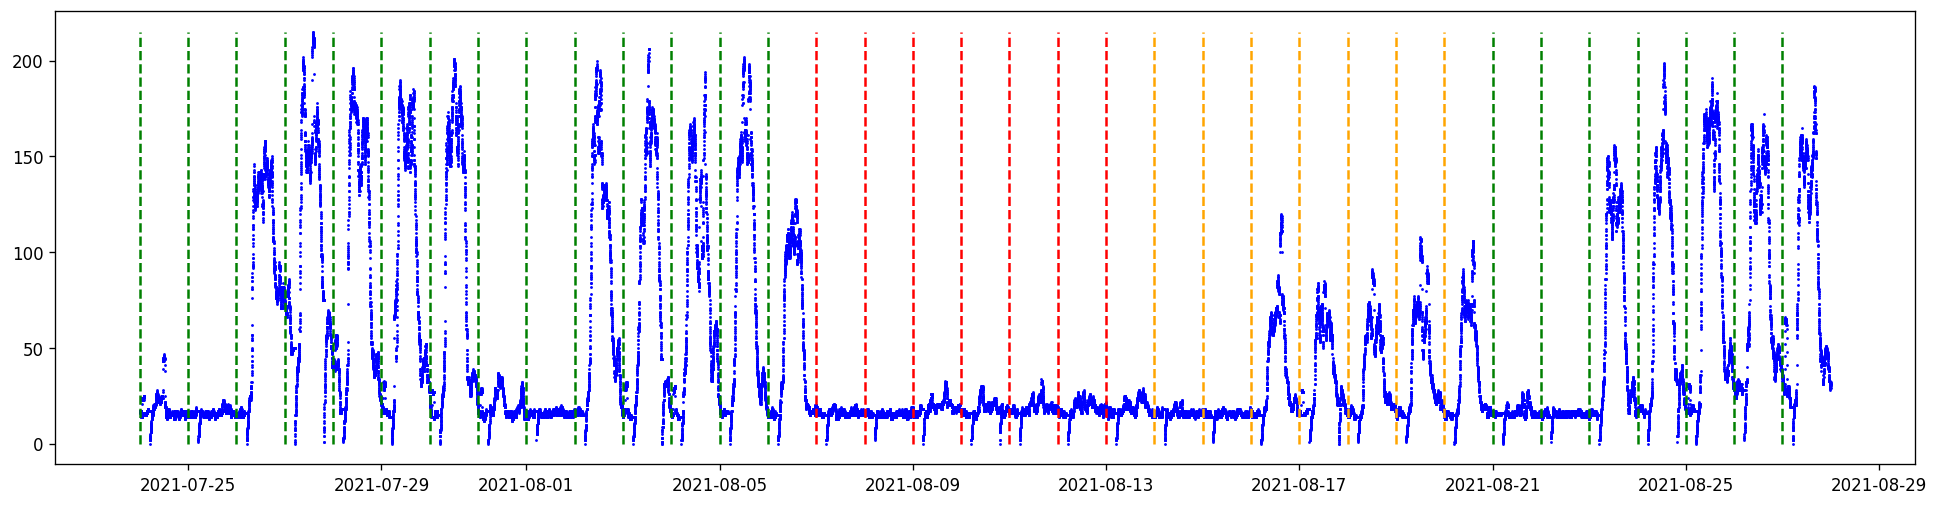

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

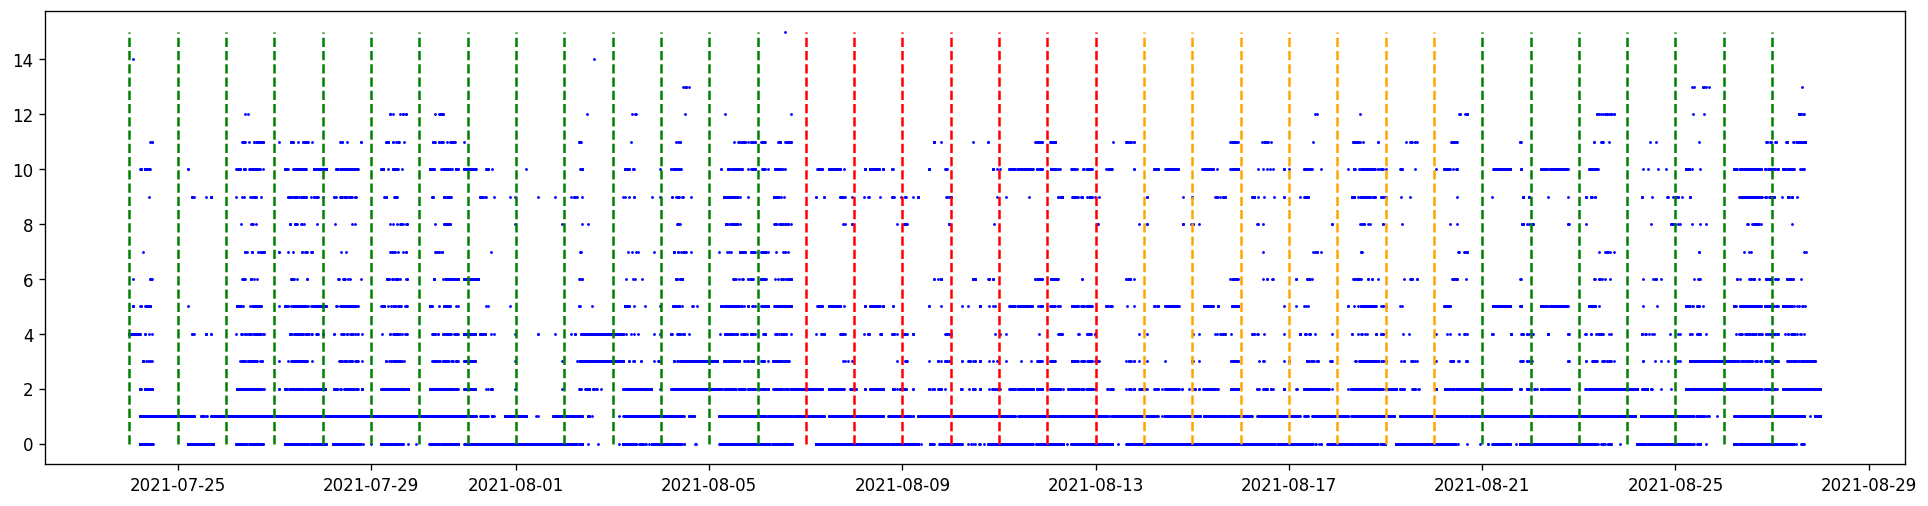

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

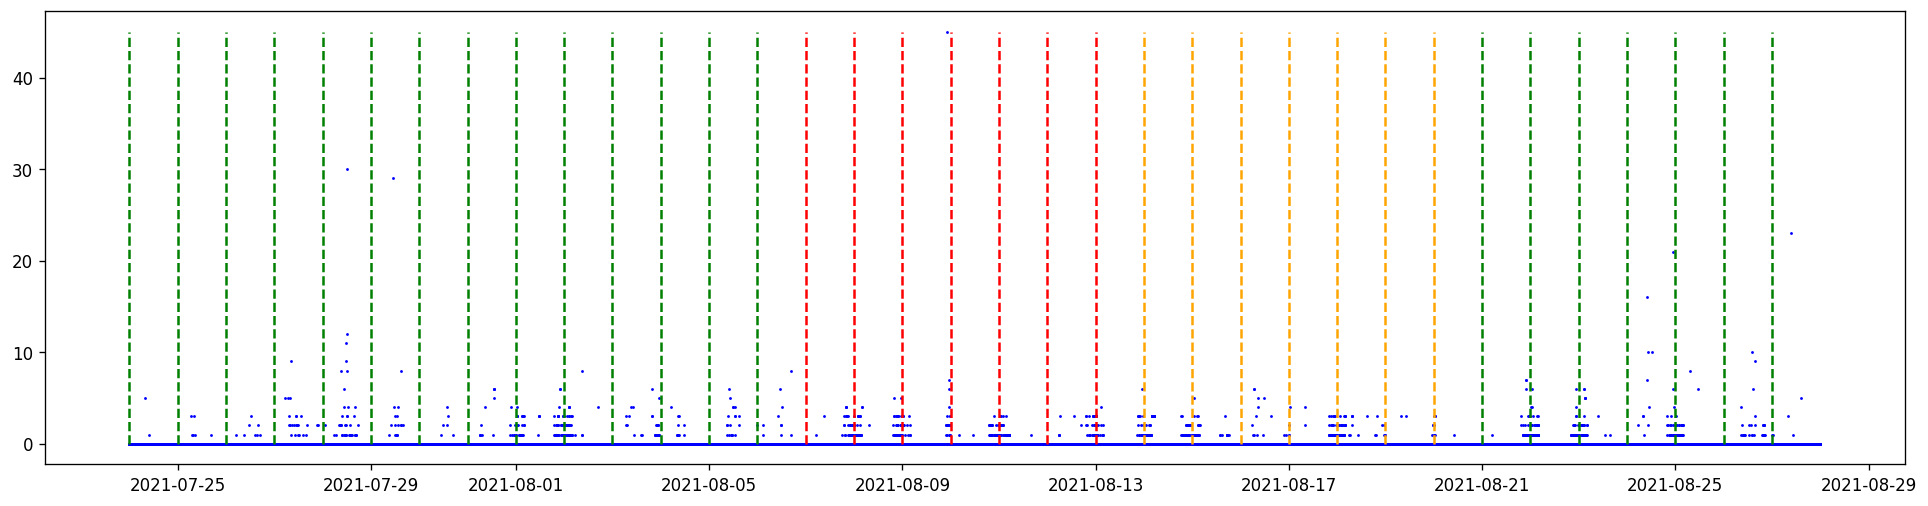

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

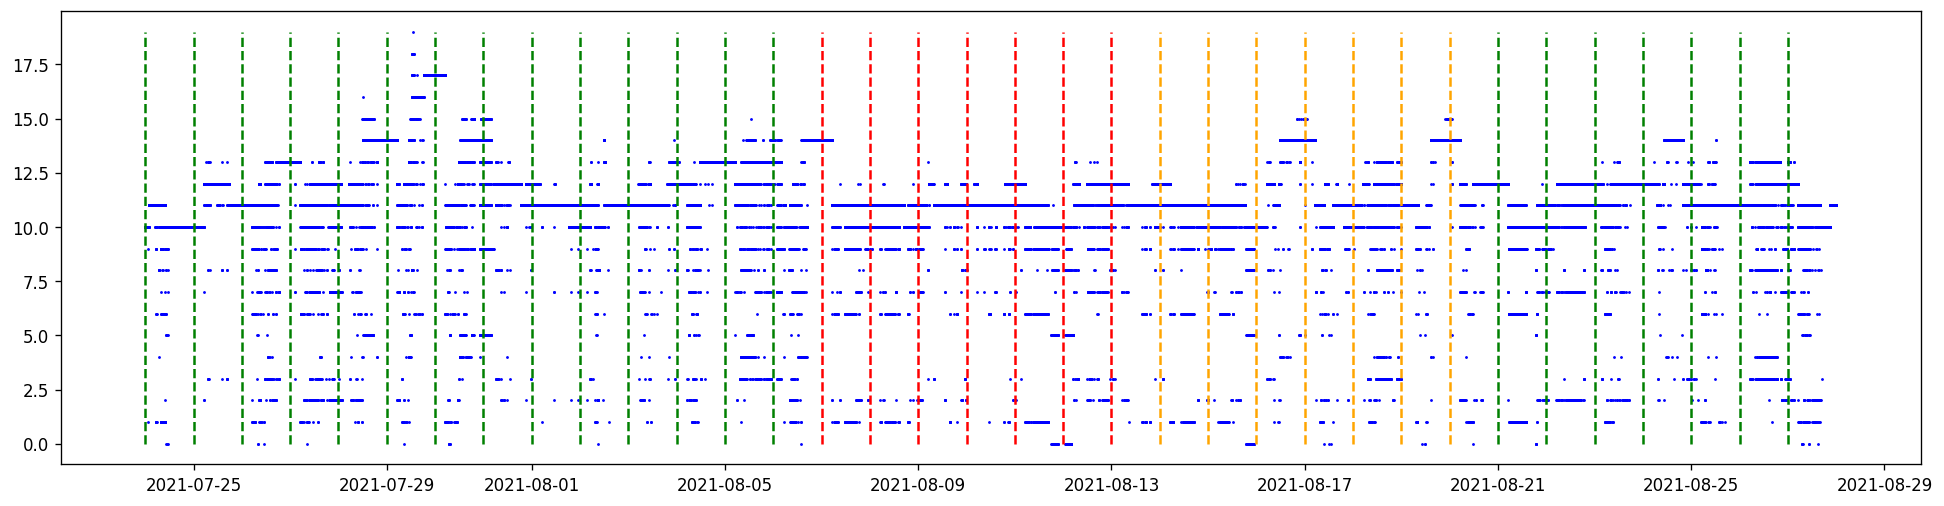

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

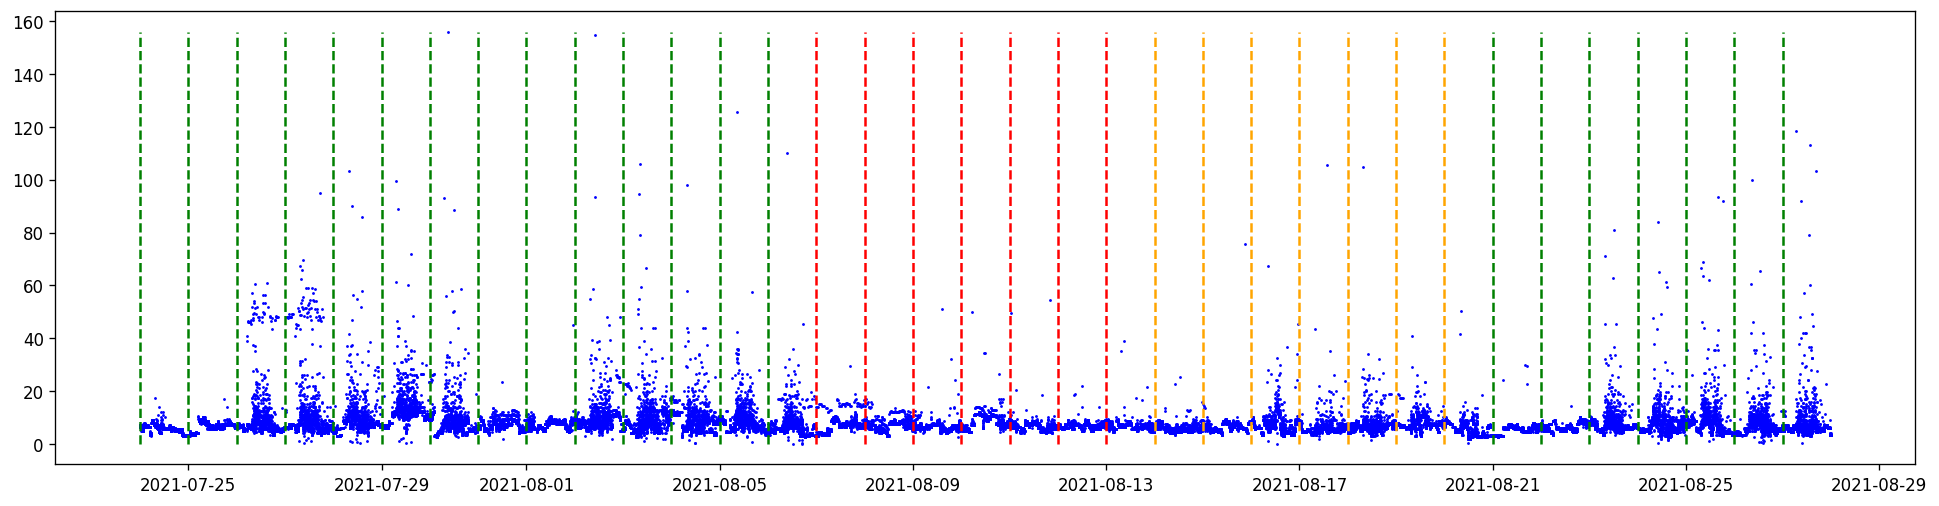

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

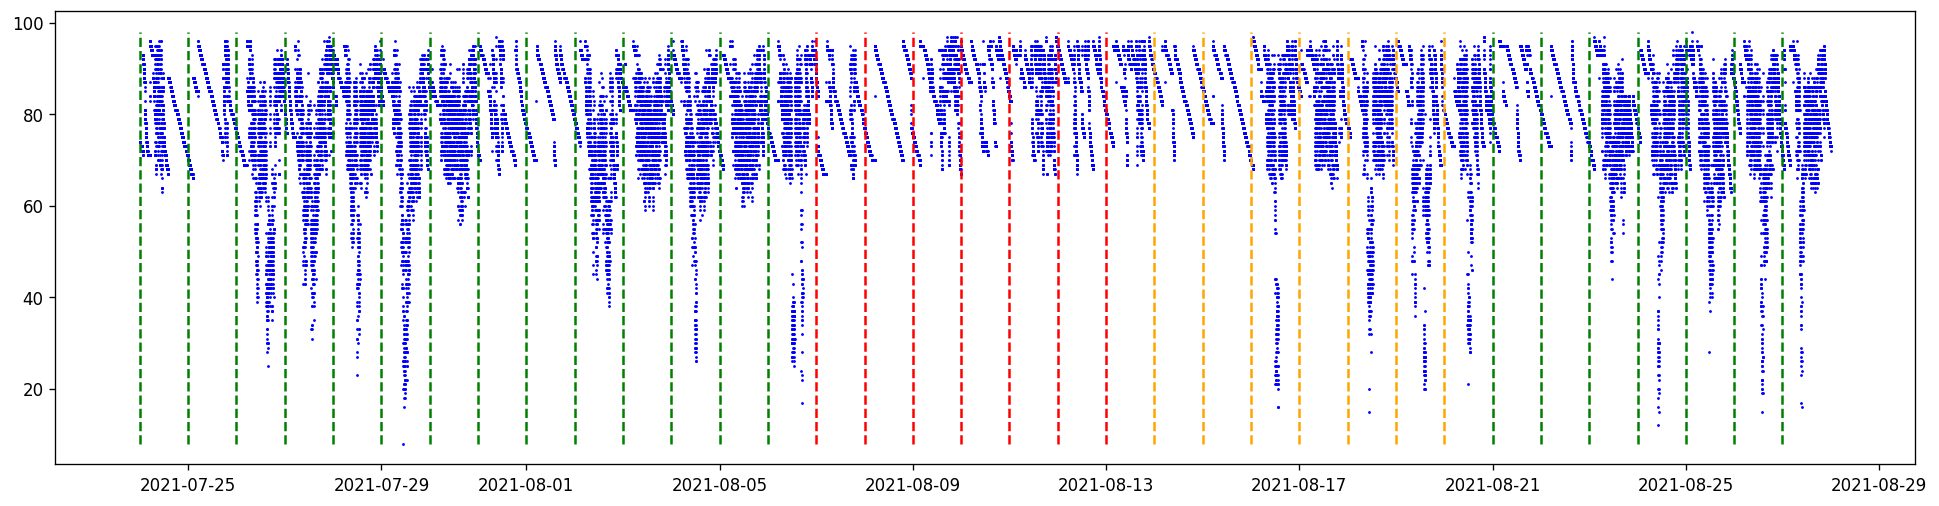

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

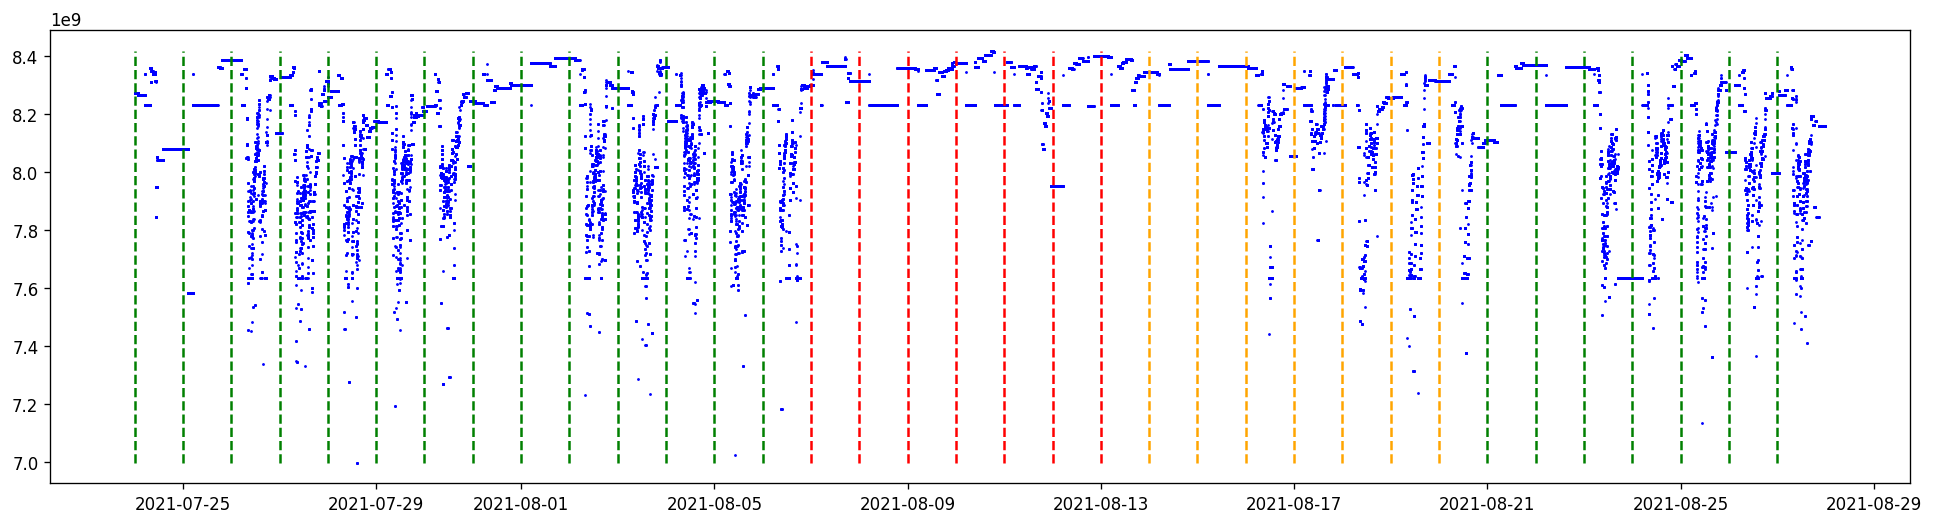

<IPython.core.display.Javascript object>

In [7]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'red')
    else :
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)


    fig.show();

In [8]:
first_two_weeks=df.loc['2021-07-24 00:00:00':'2021-08-06 23:59:00']
last_week=df.loc['2021-08-21 00:00:00': '2021-08-27 23:59:00']
strange_week=df.loc['2021-08-14 00:00:00': '2021-08-20 23:59:00']
remove_week=df.loc['2021-08-07 00:00:00':'2021-08-13 23:59:00']

In [9]:
strange_week=strange_week*1
last_week.index=strange_week.index
strange_week.index=remove_week.index

In [10]:
df=pd.concat([first_two_weeks, strange_week,last_week])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

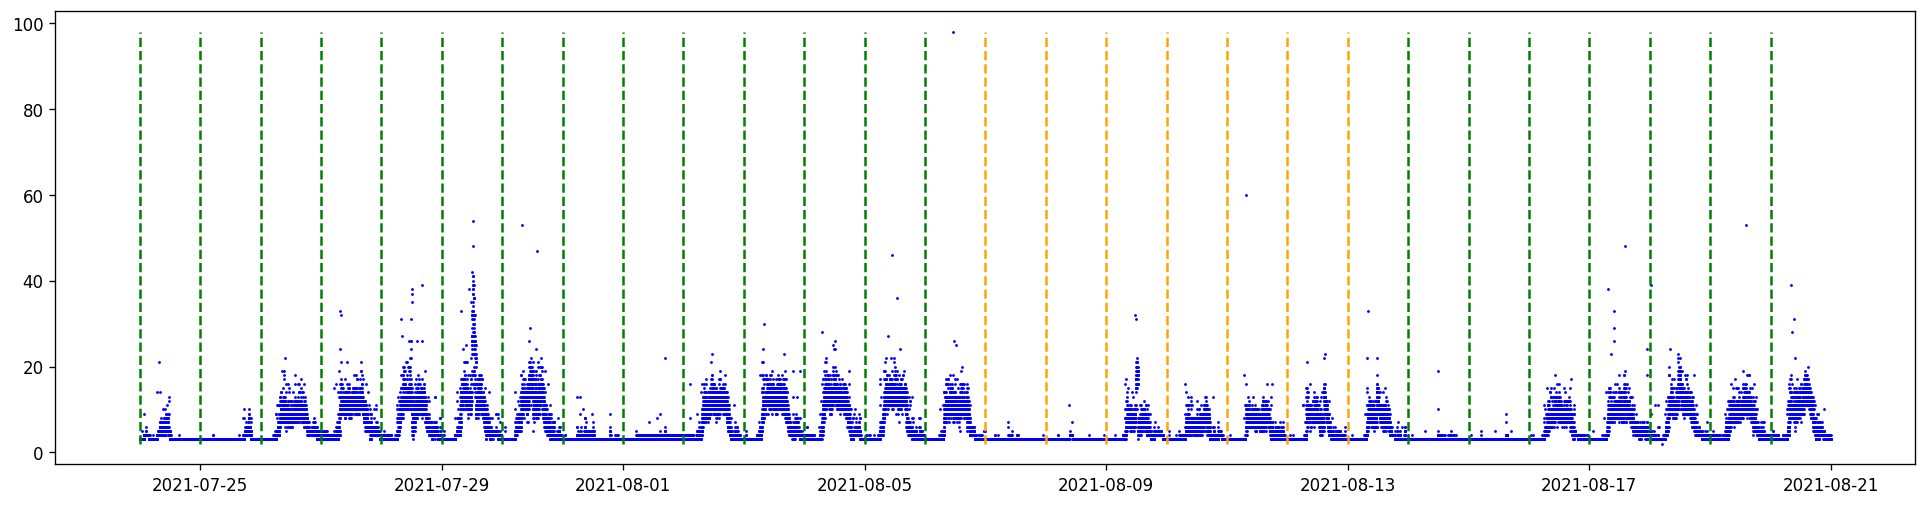

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

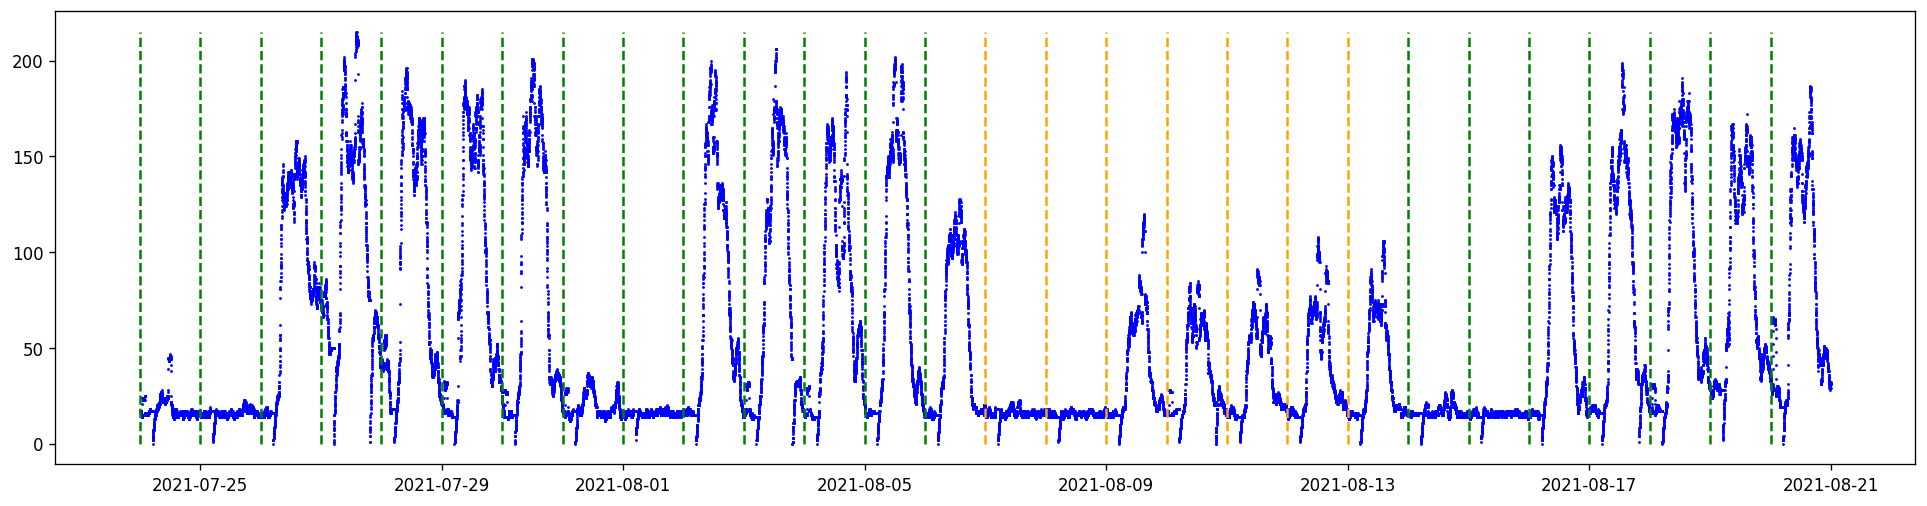

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

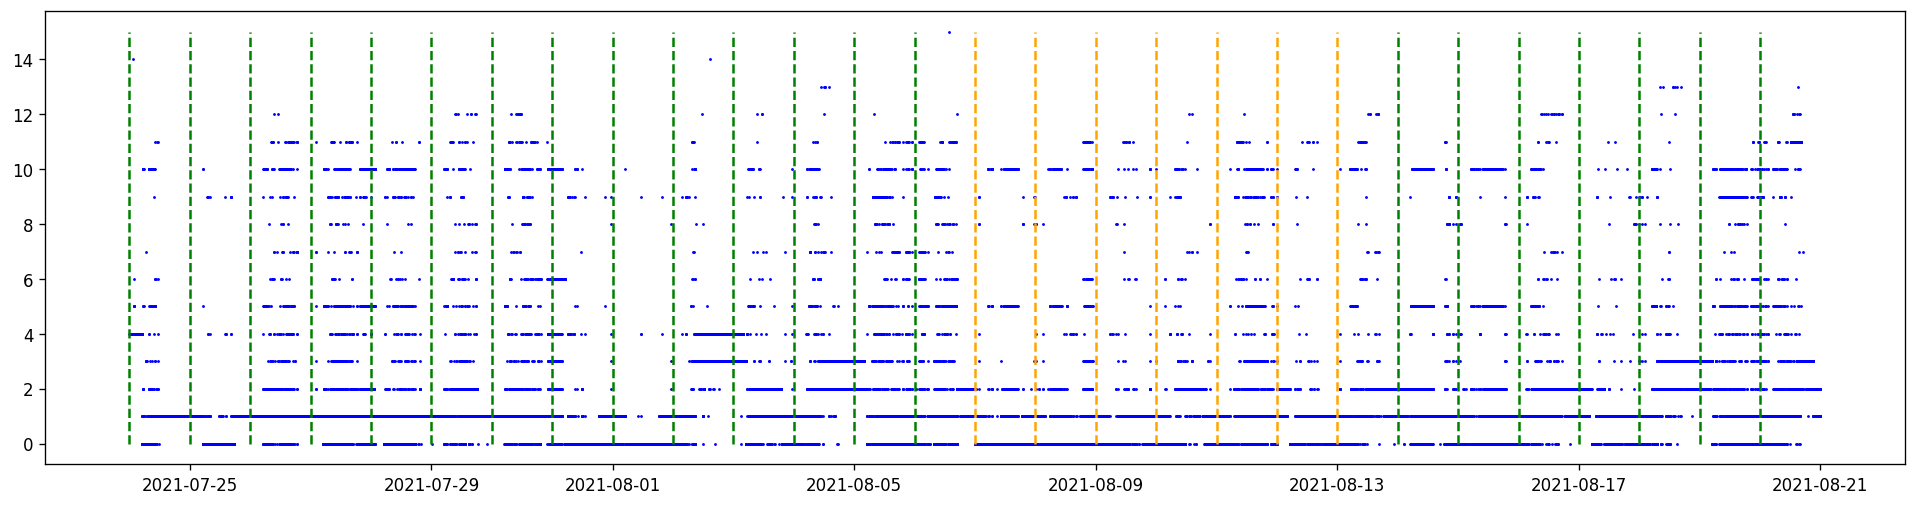

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

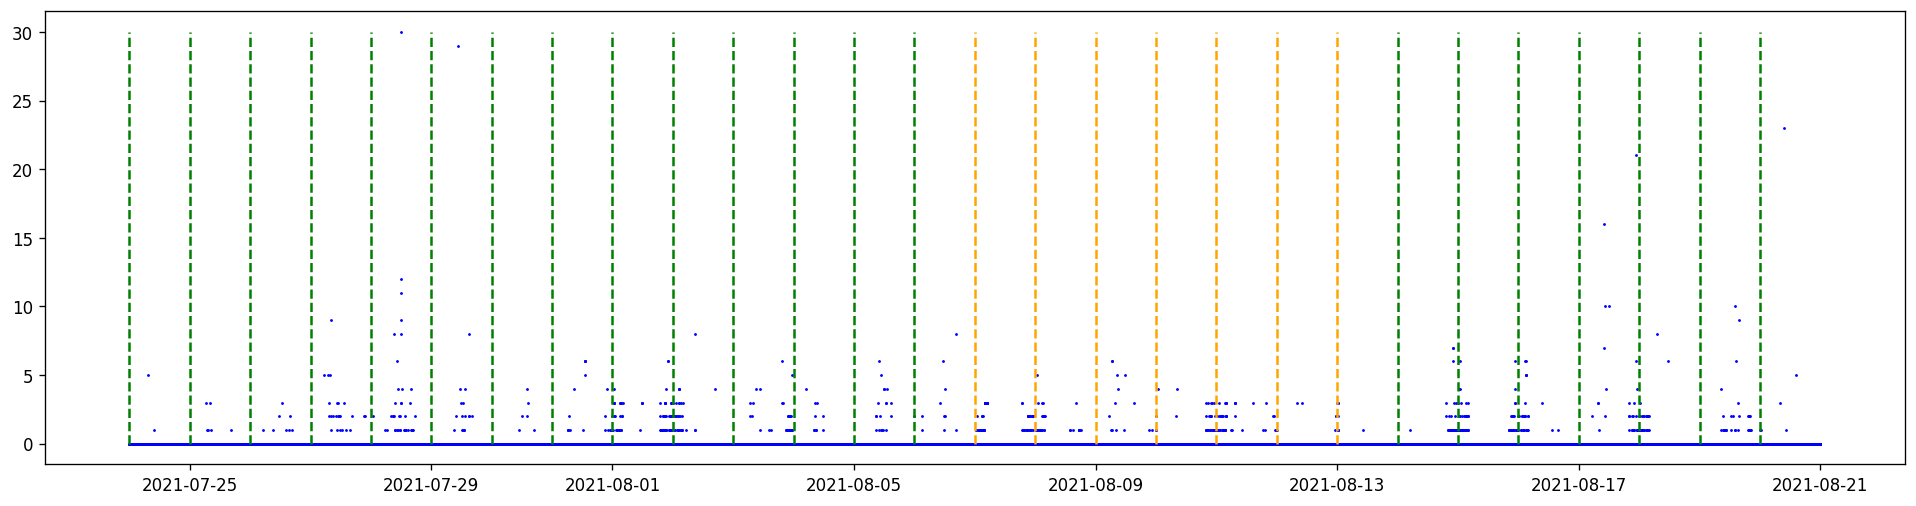

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

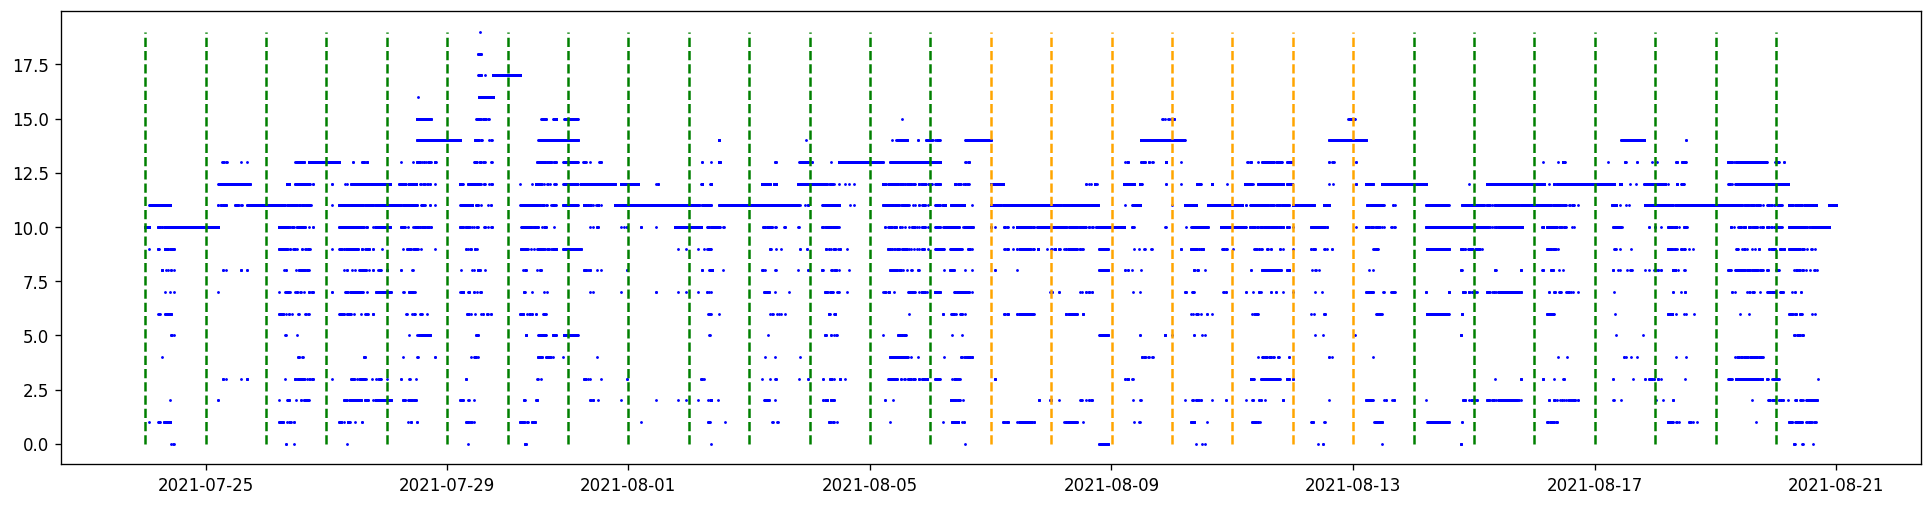

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

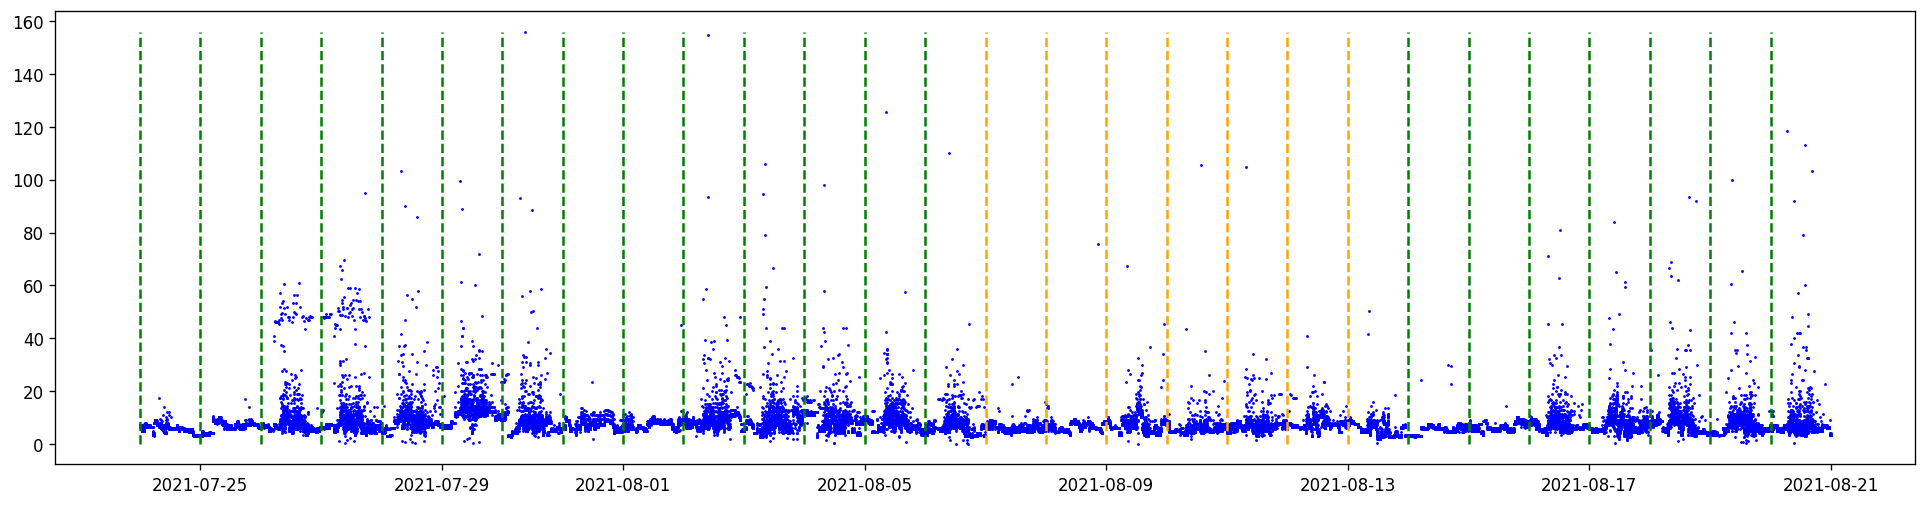

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

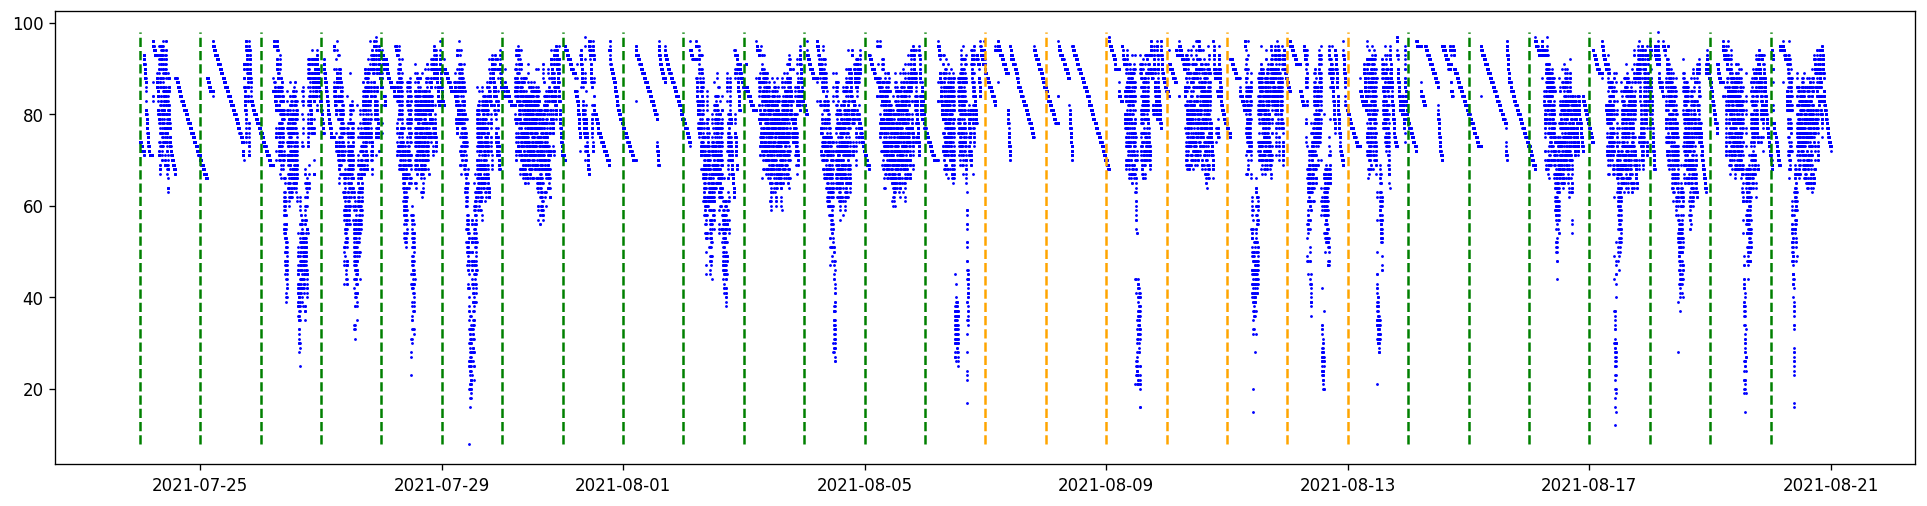

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

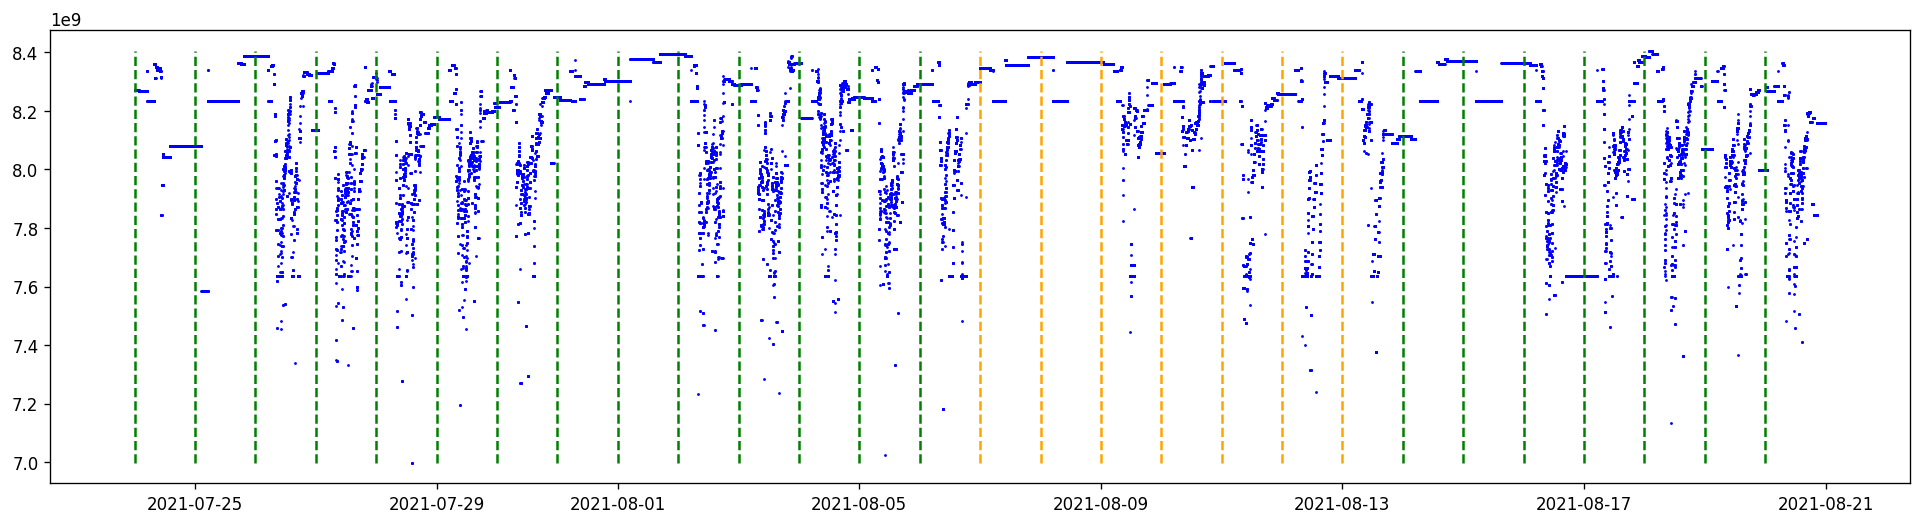

<IPython.core.display.Javascript object>

In [11]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)
    fig.show();


ISOLATION FOREST

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

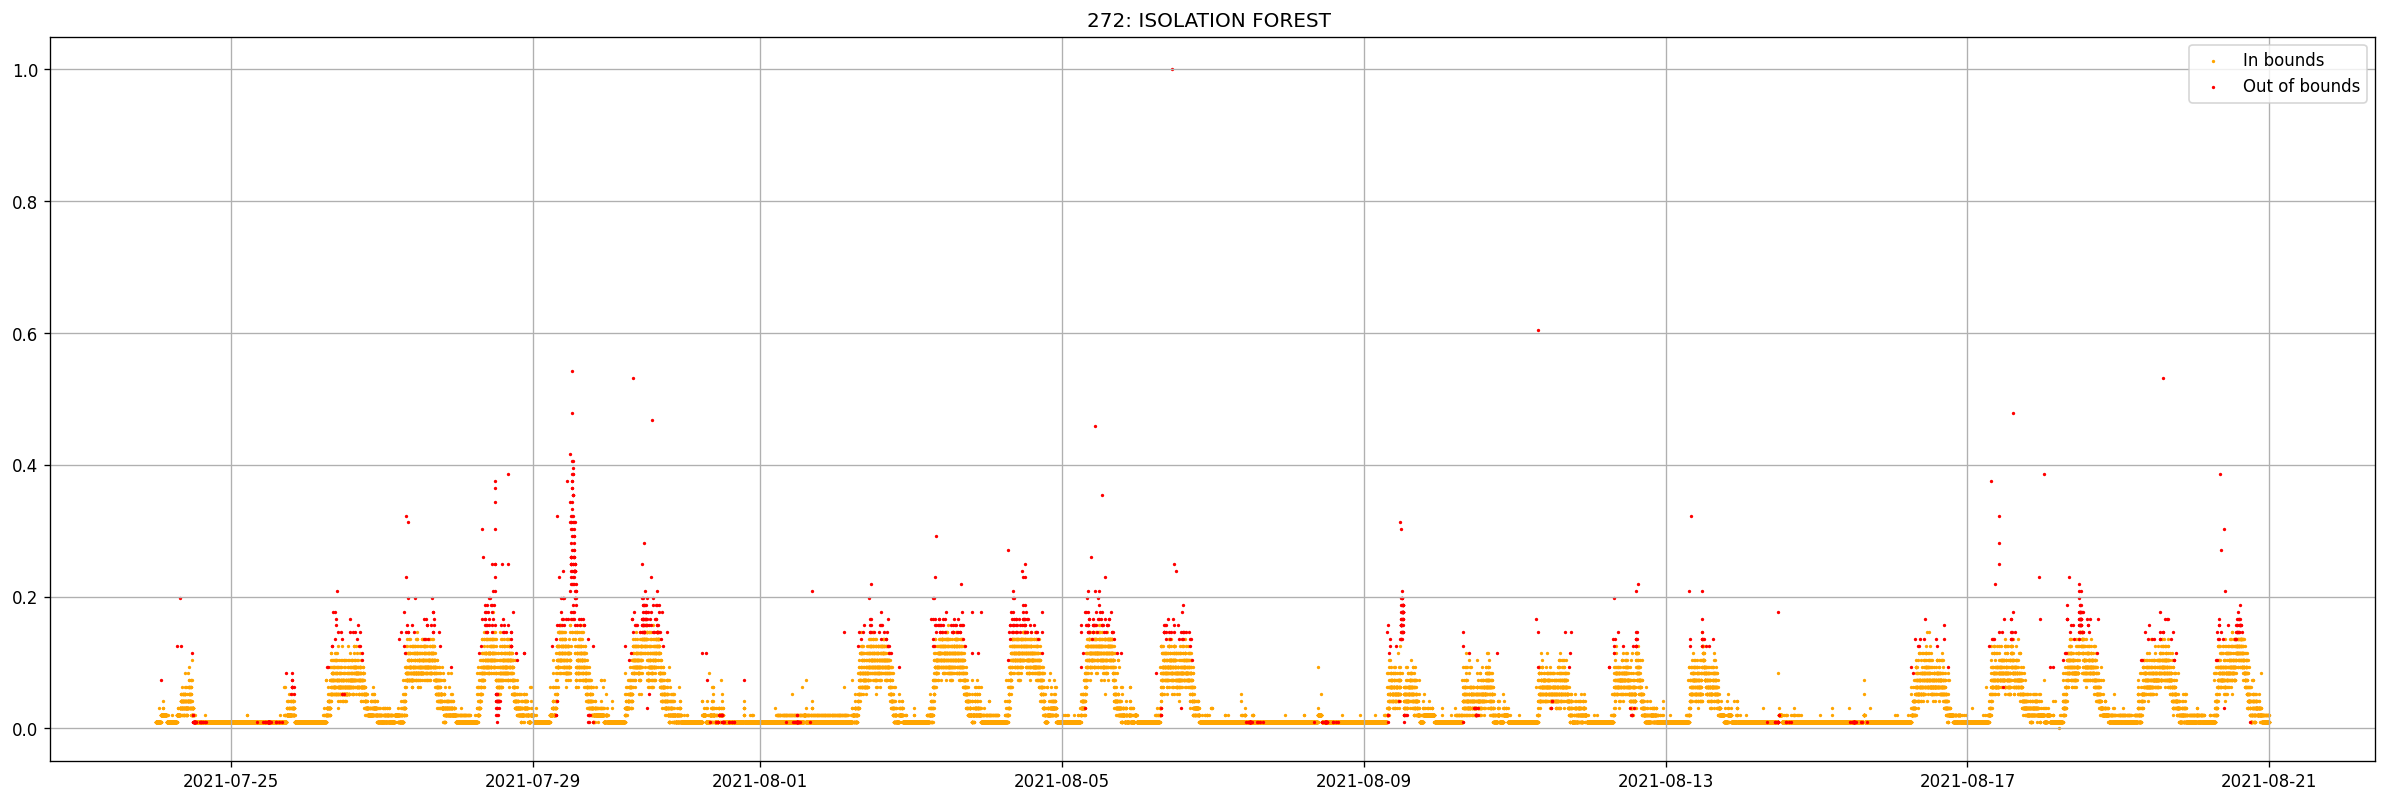

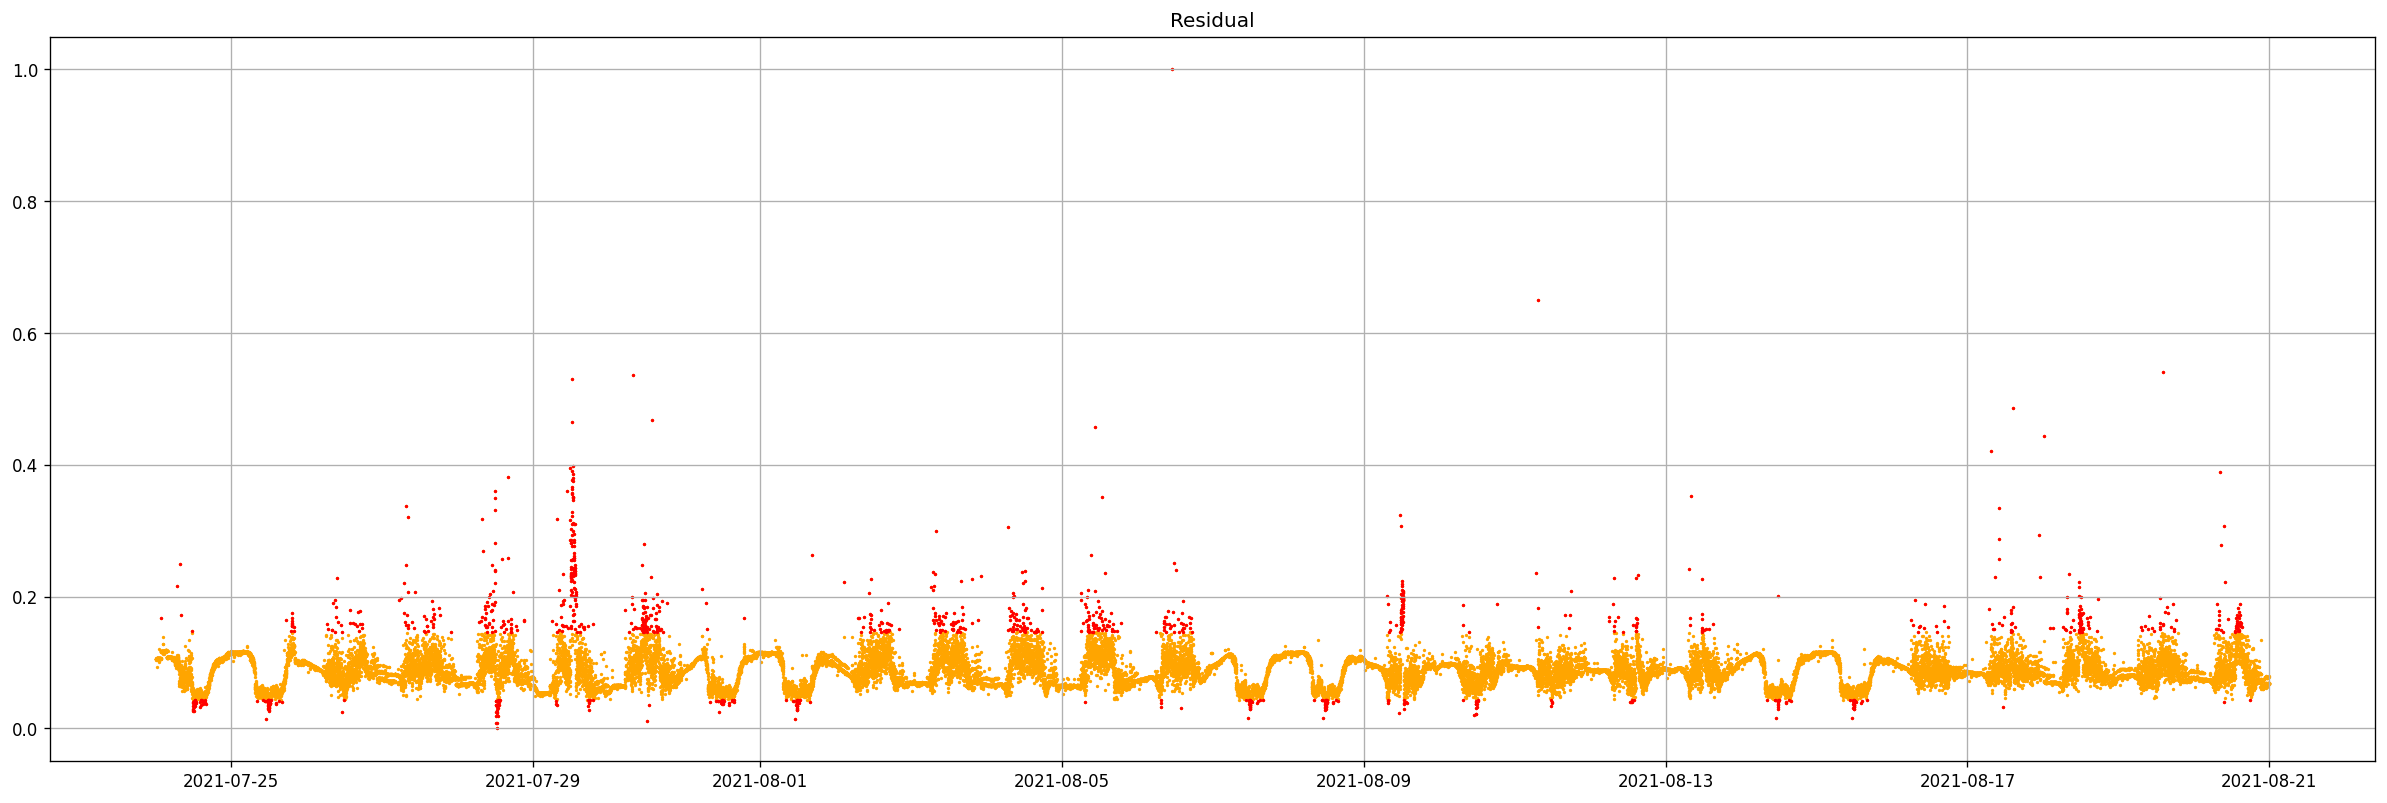

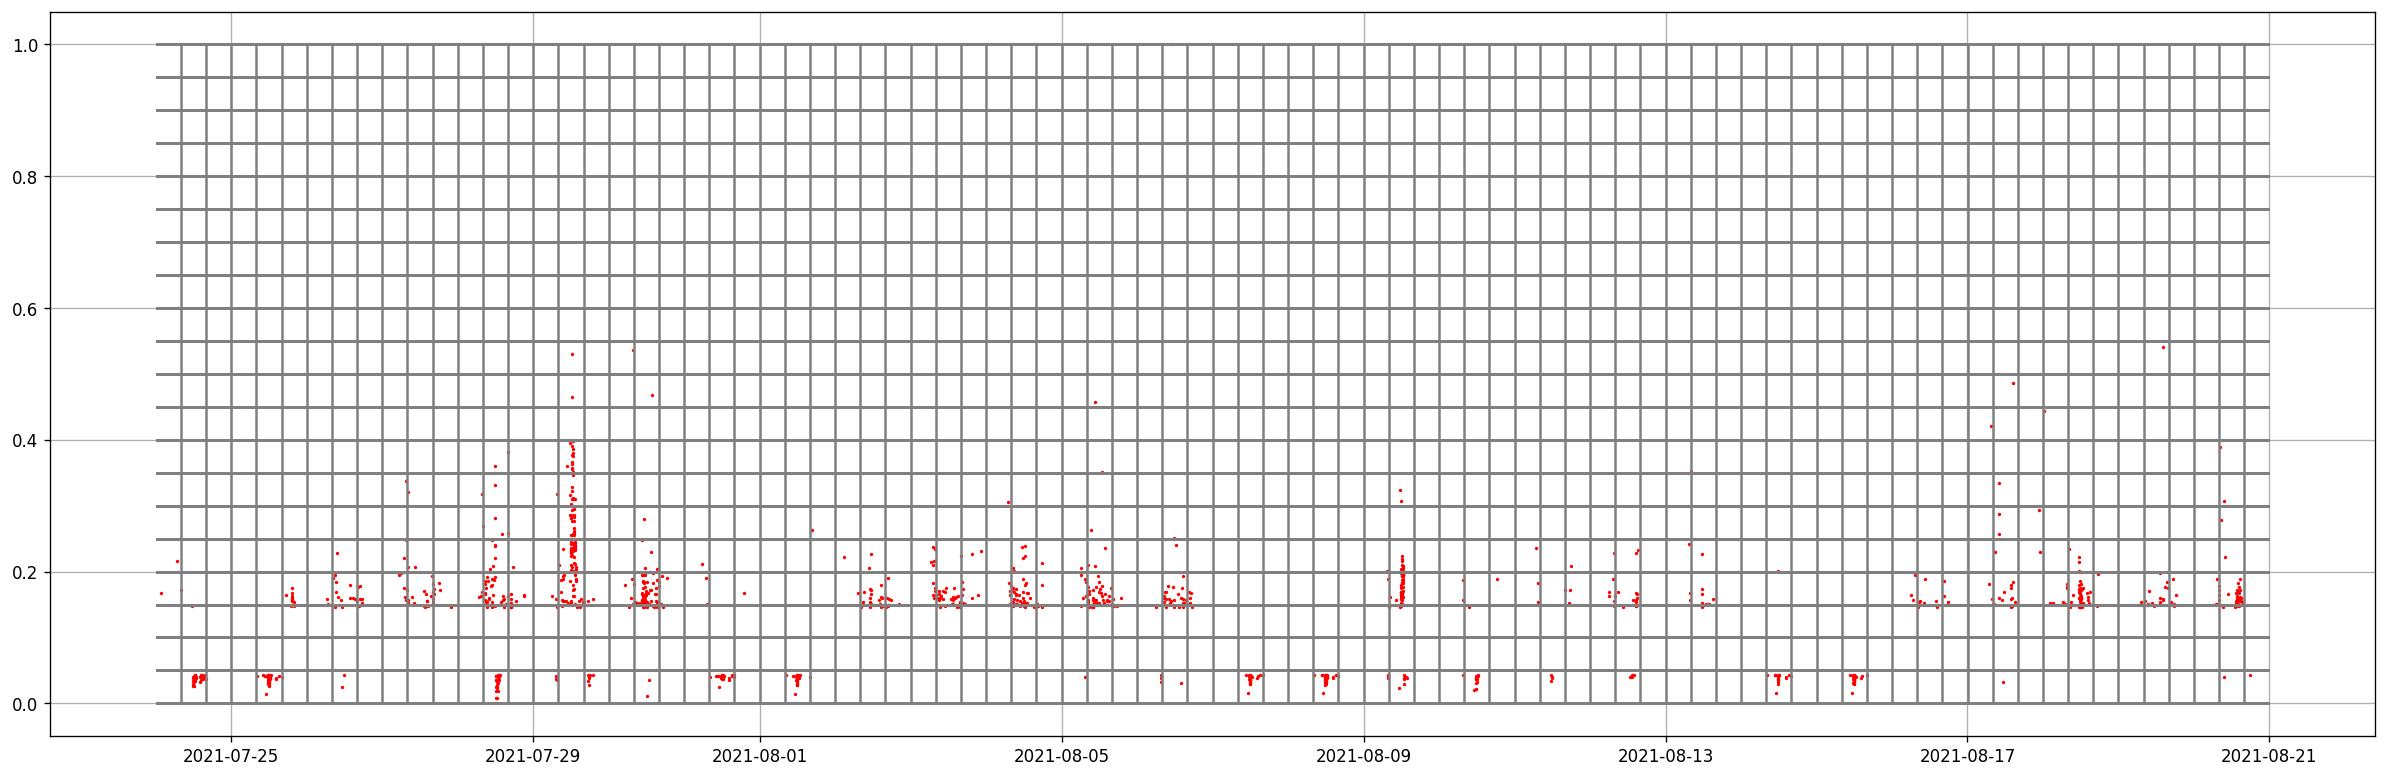

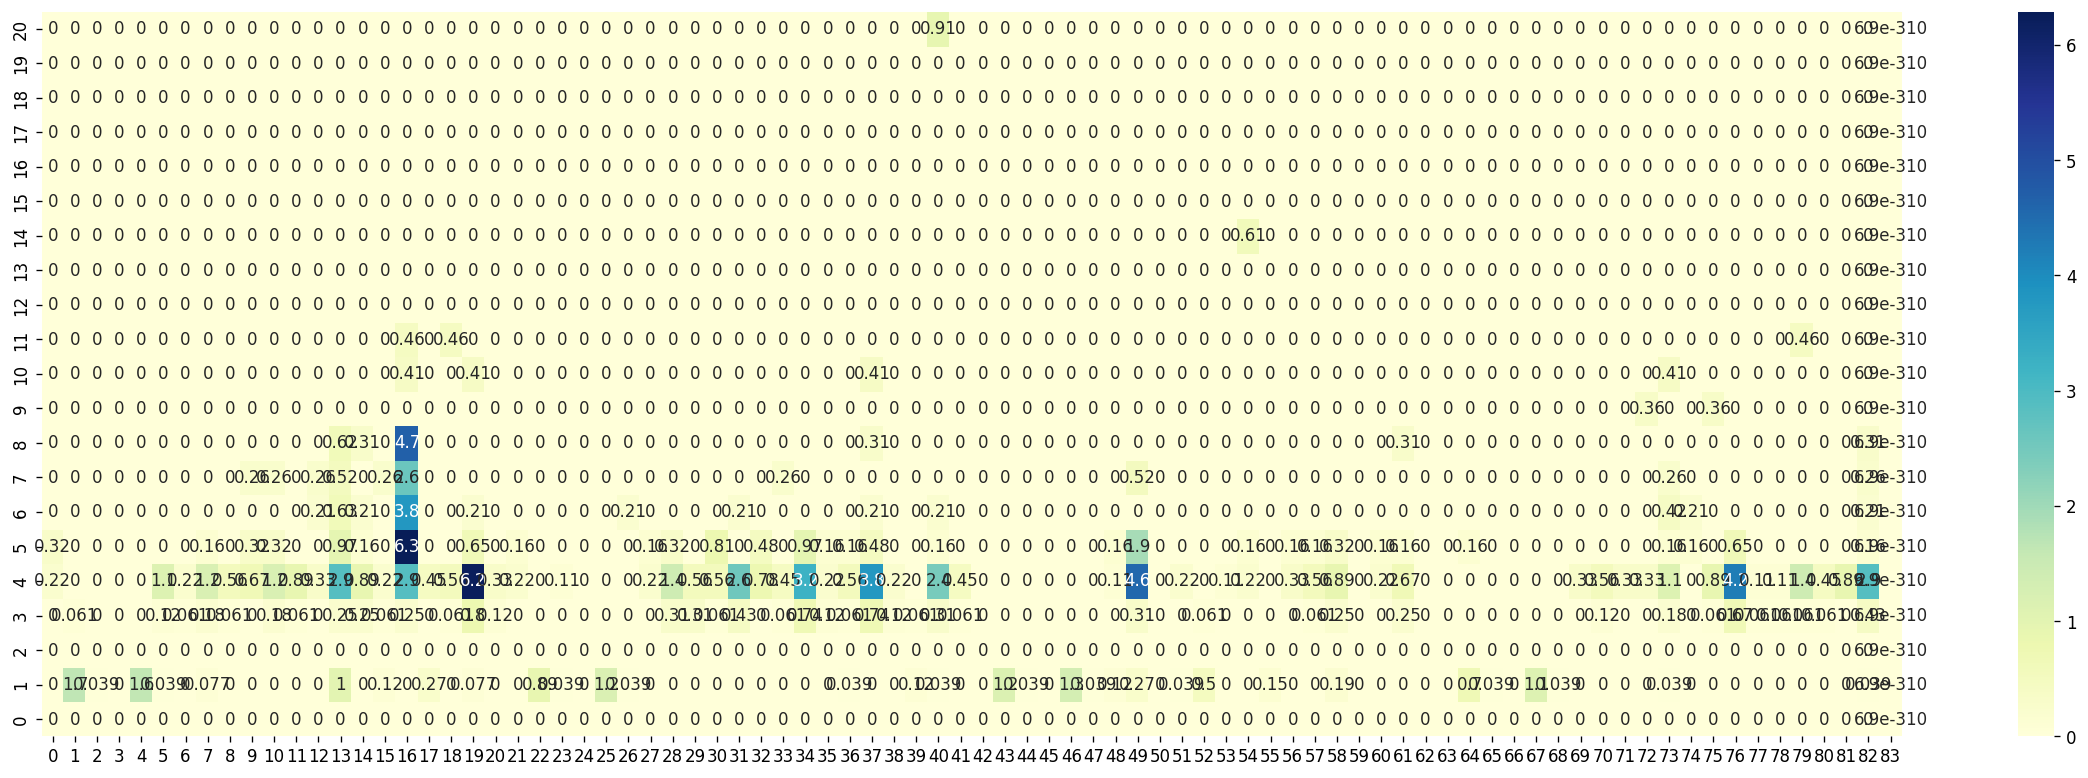

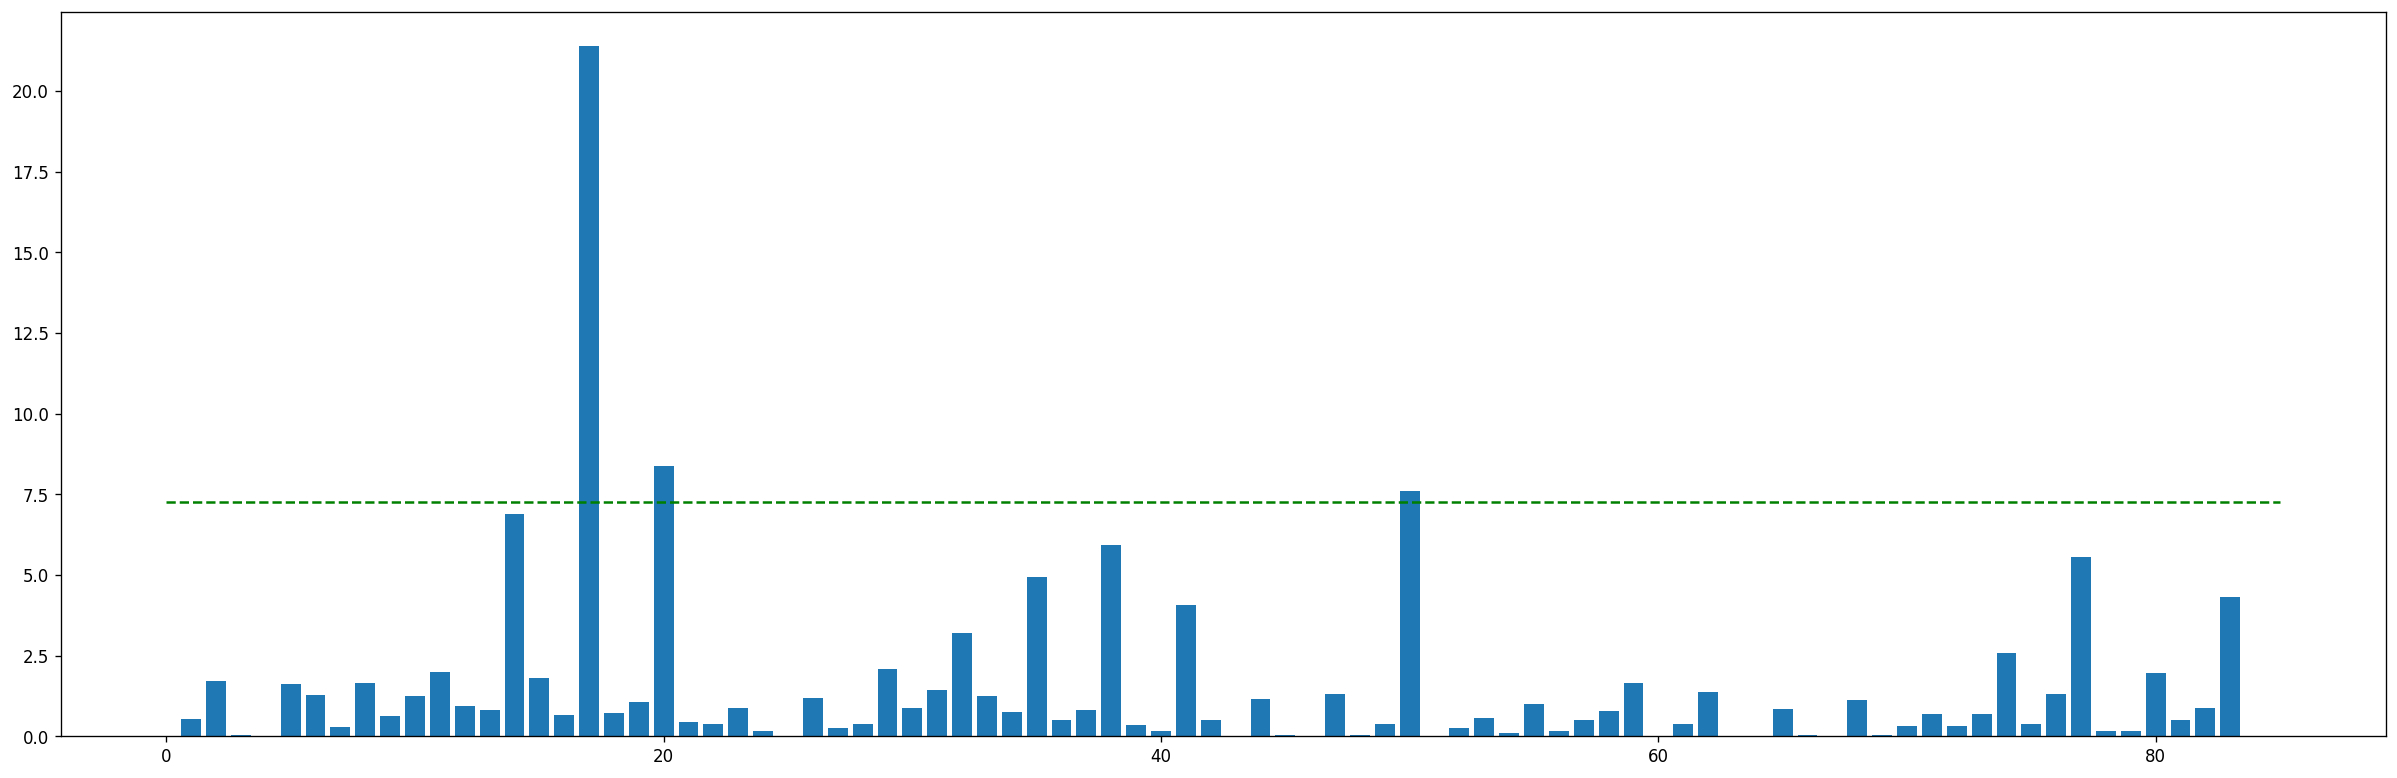

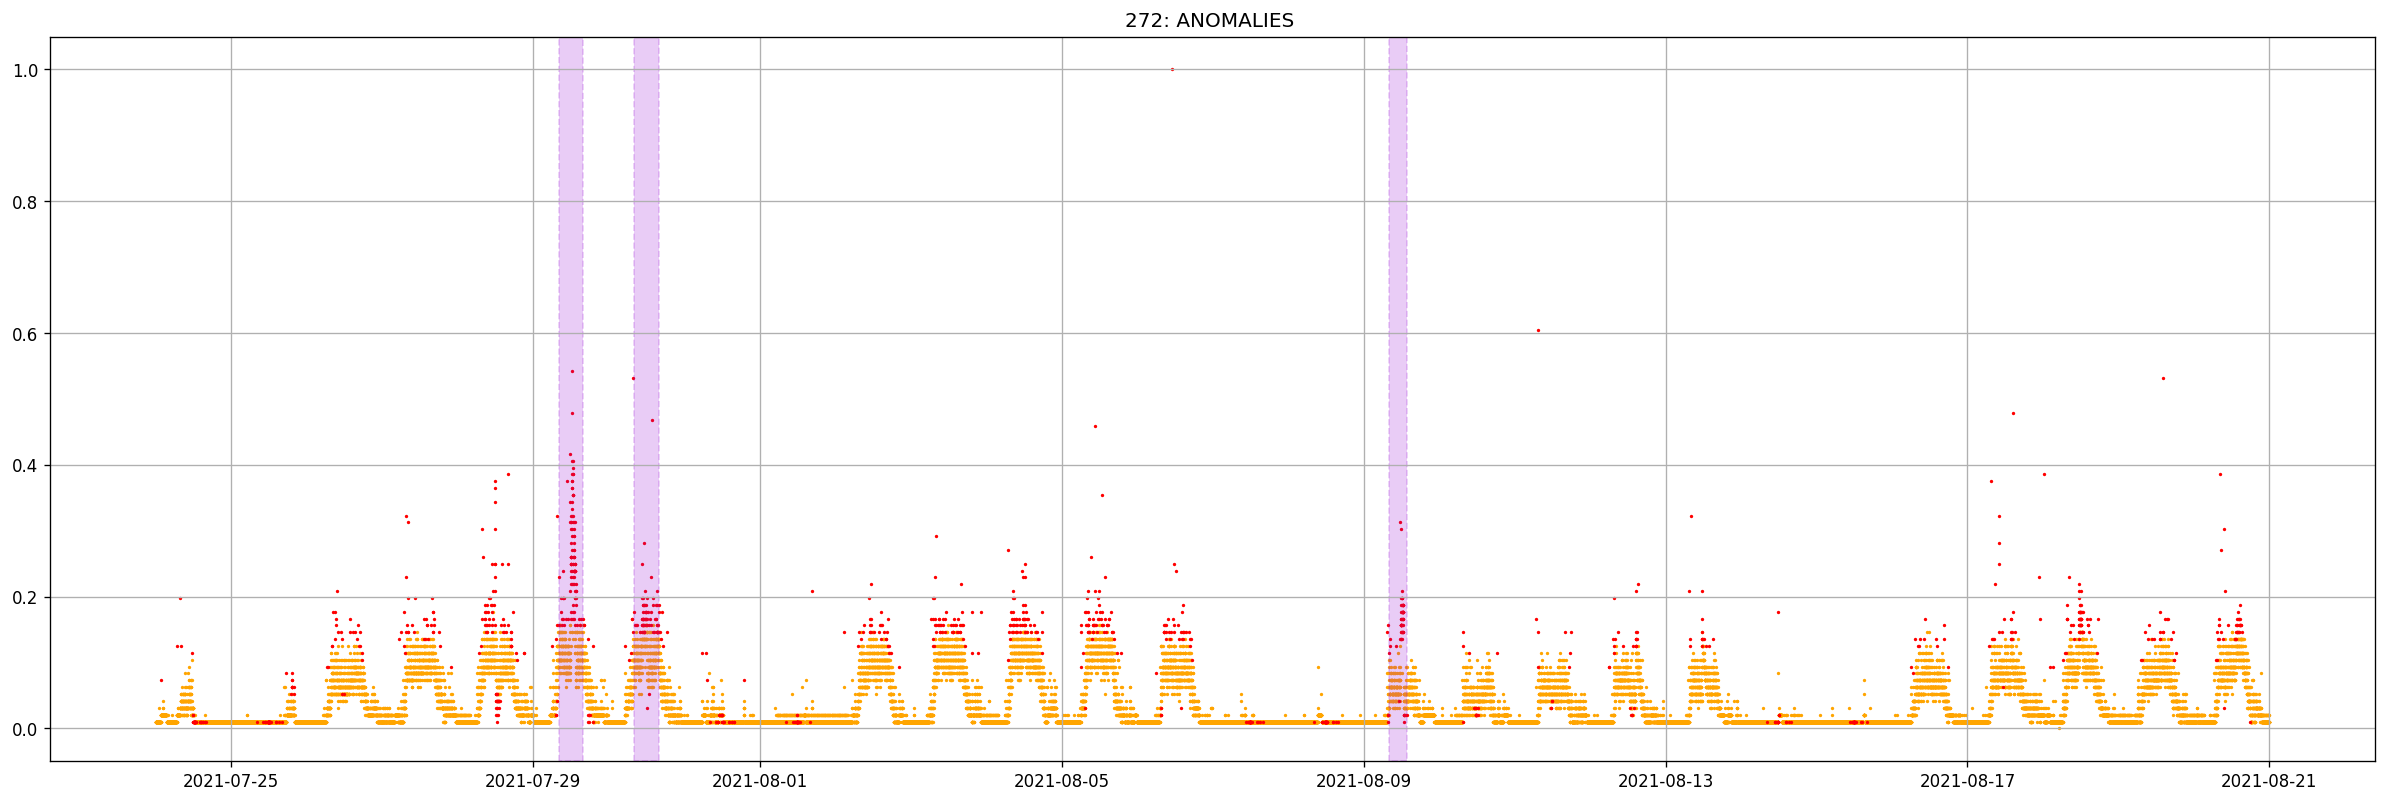

272 execution time :14.086117029190063 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

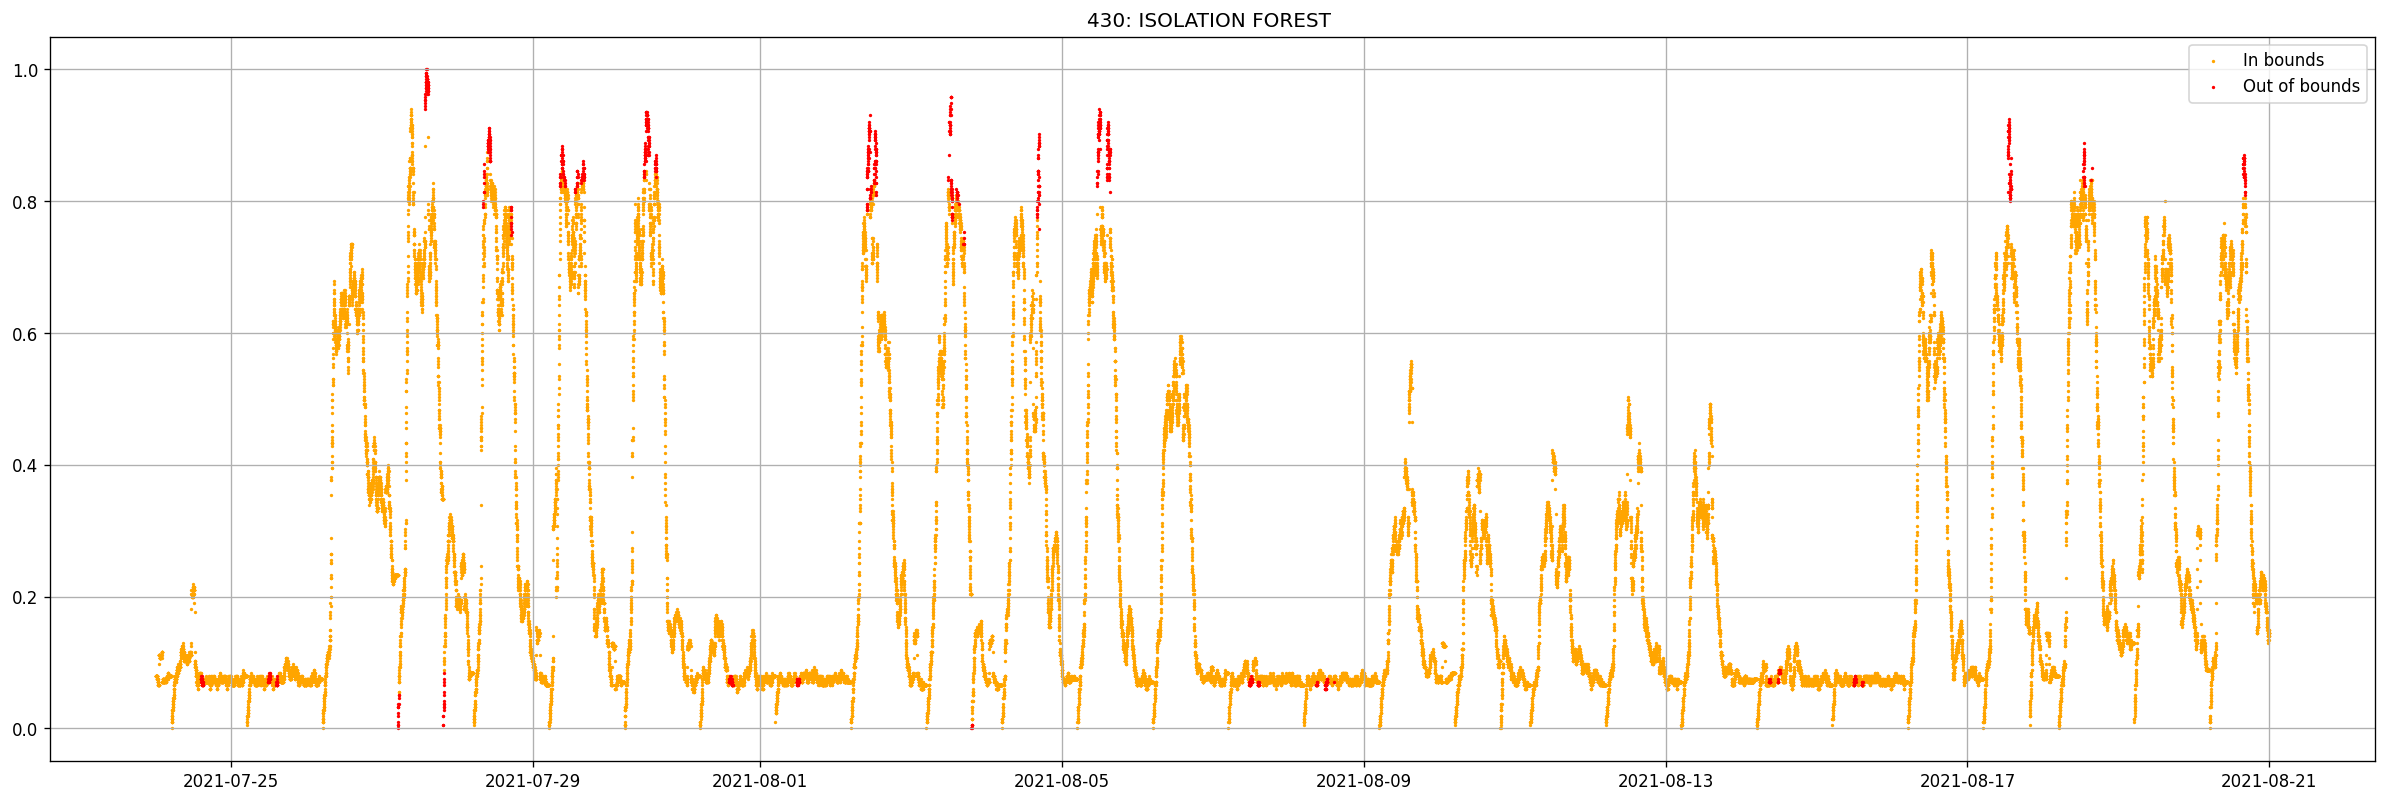

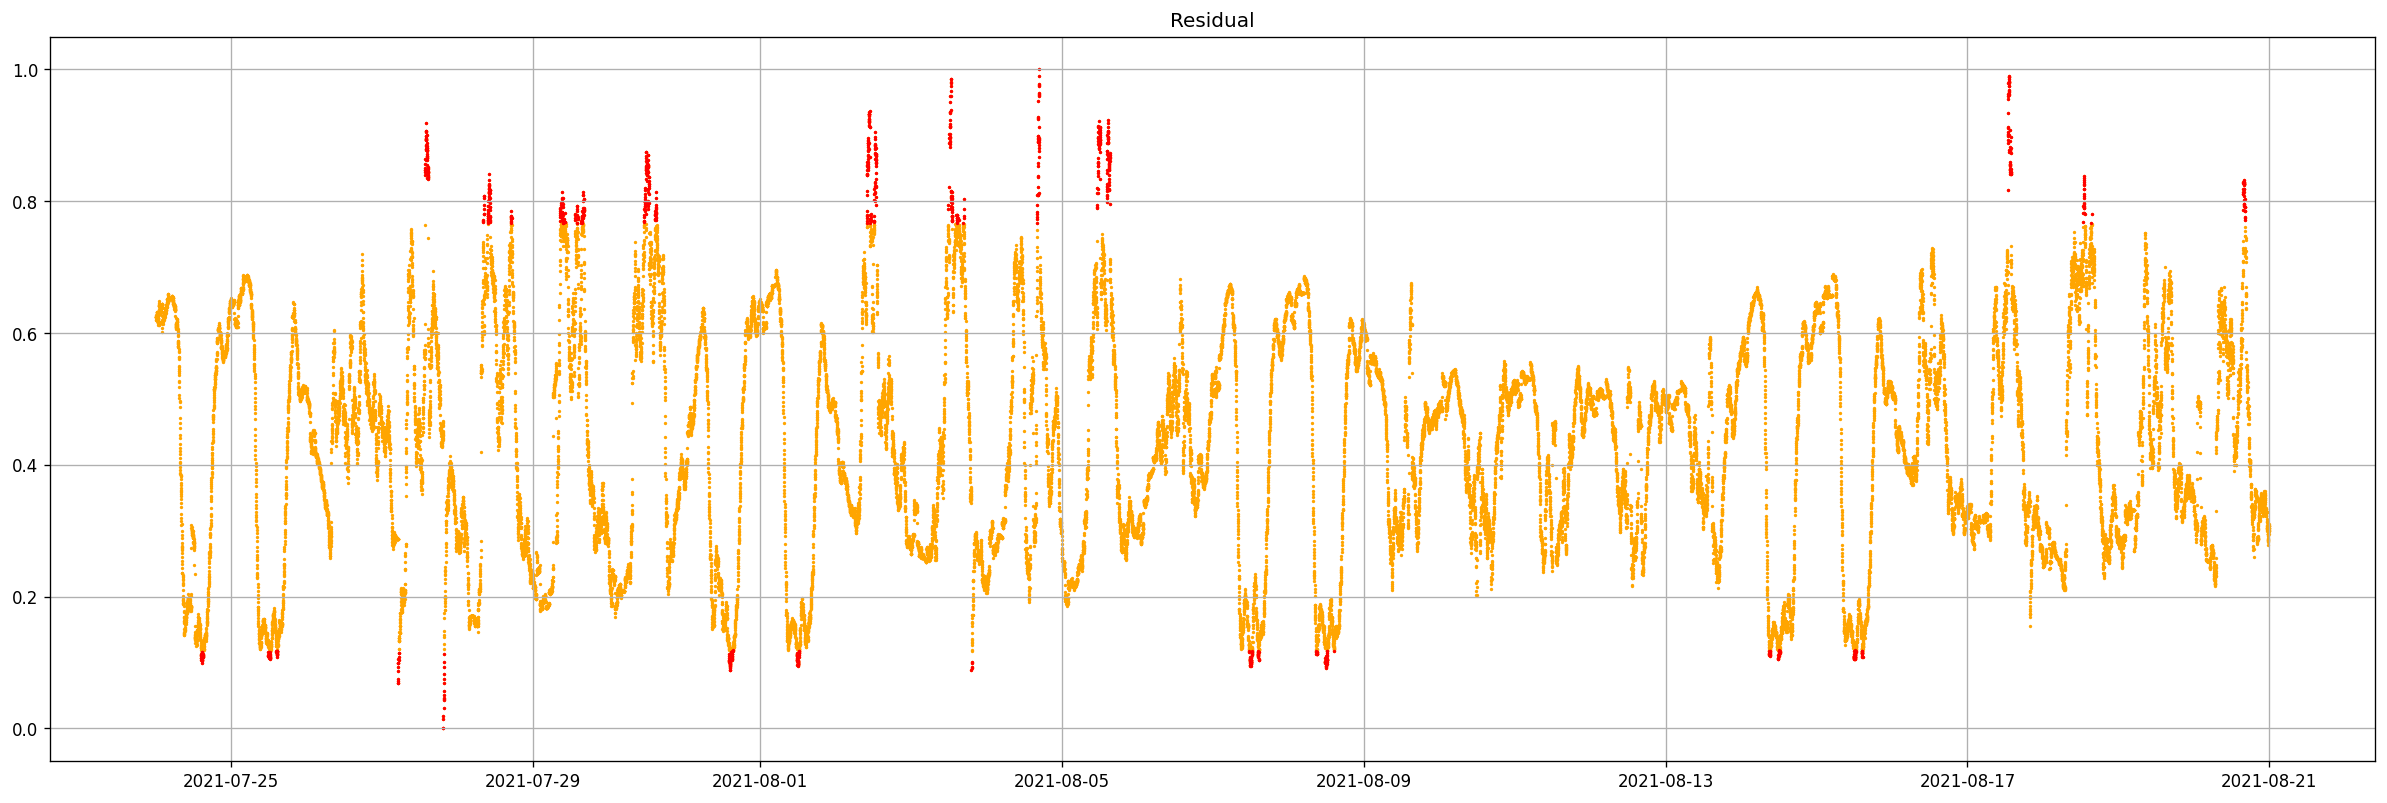

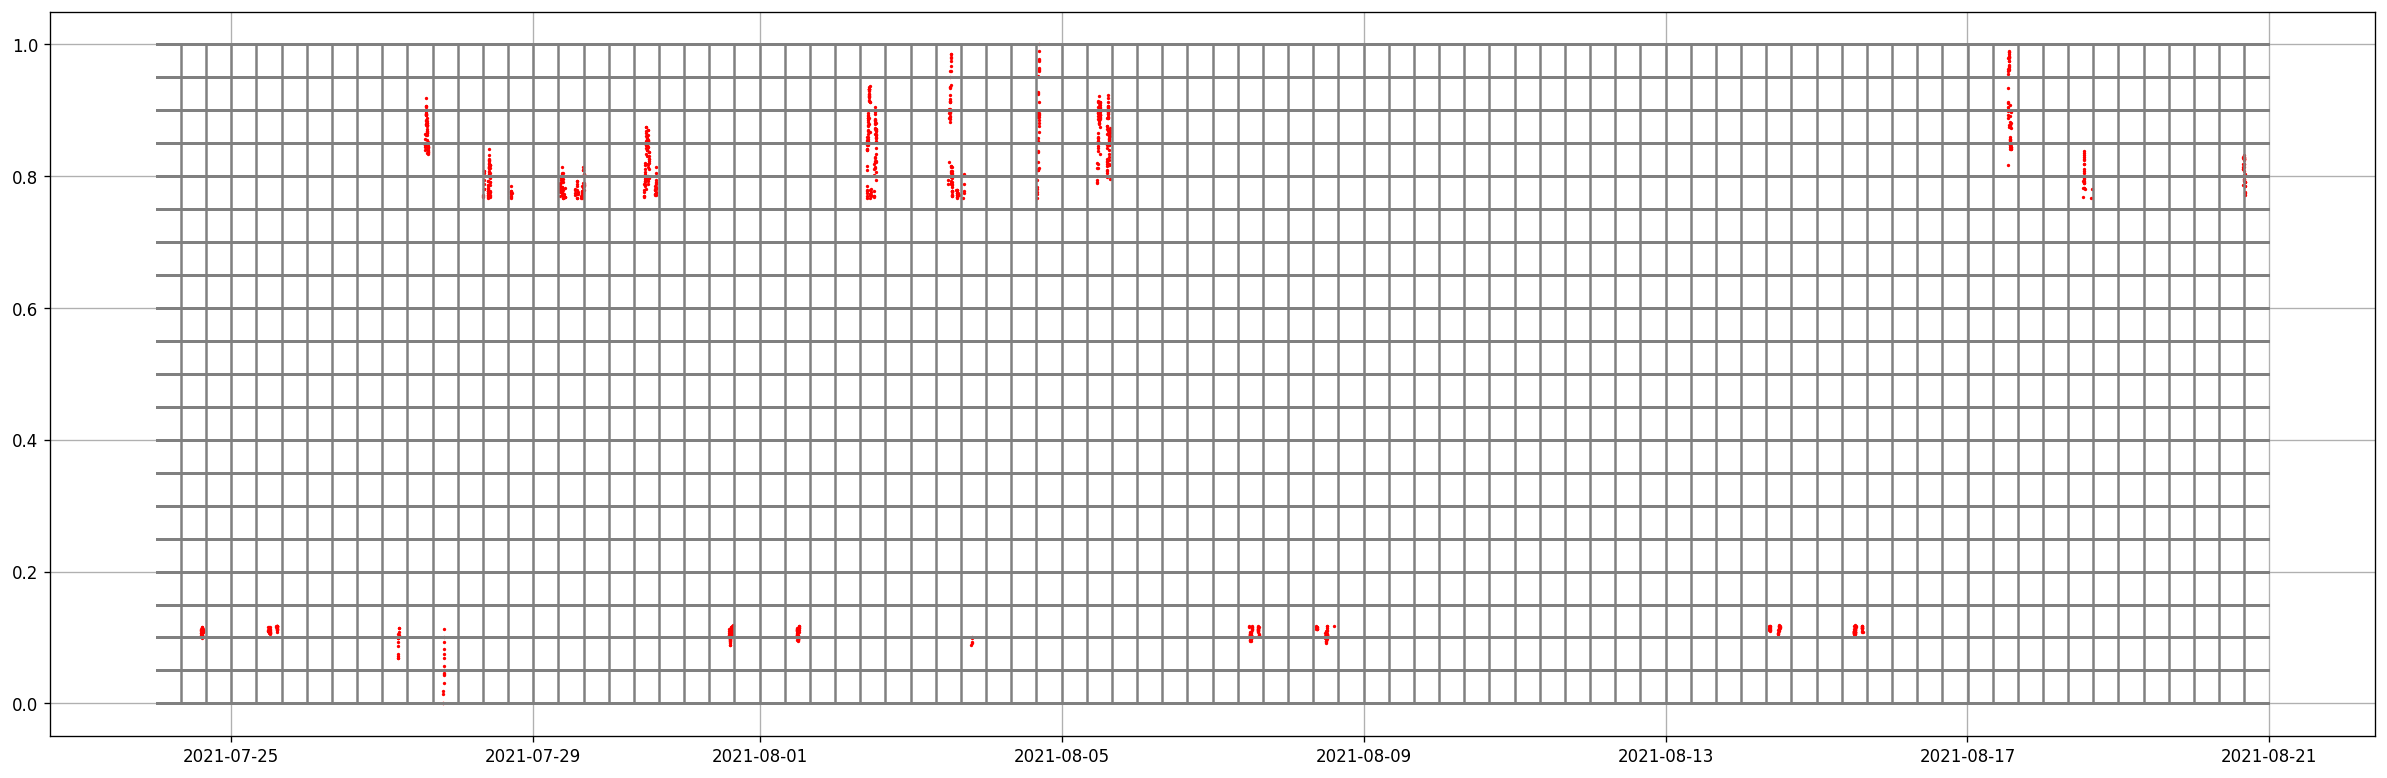

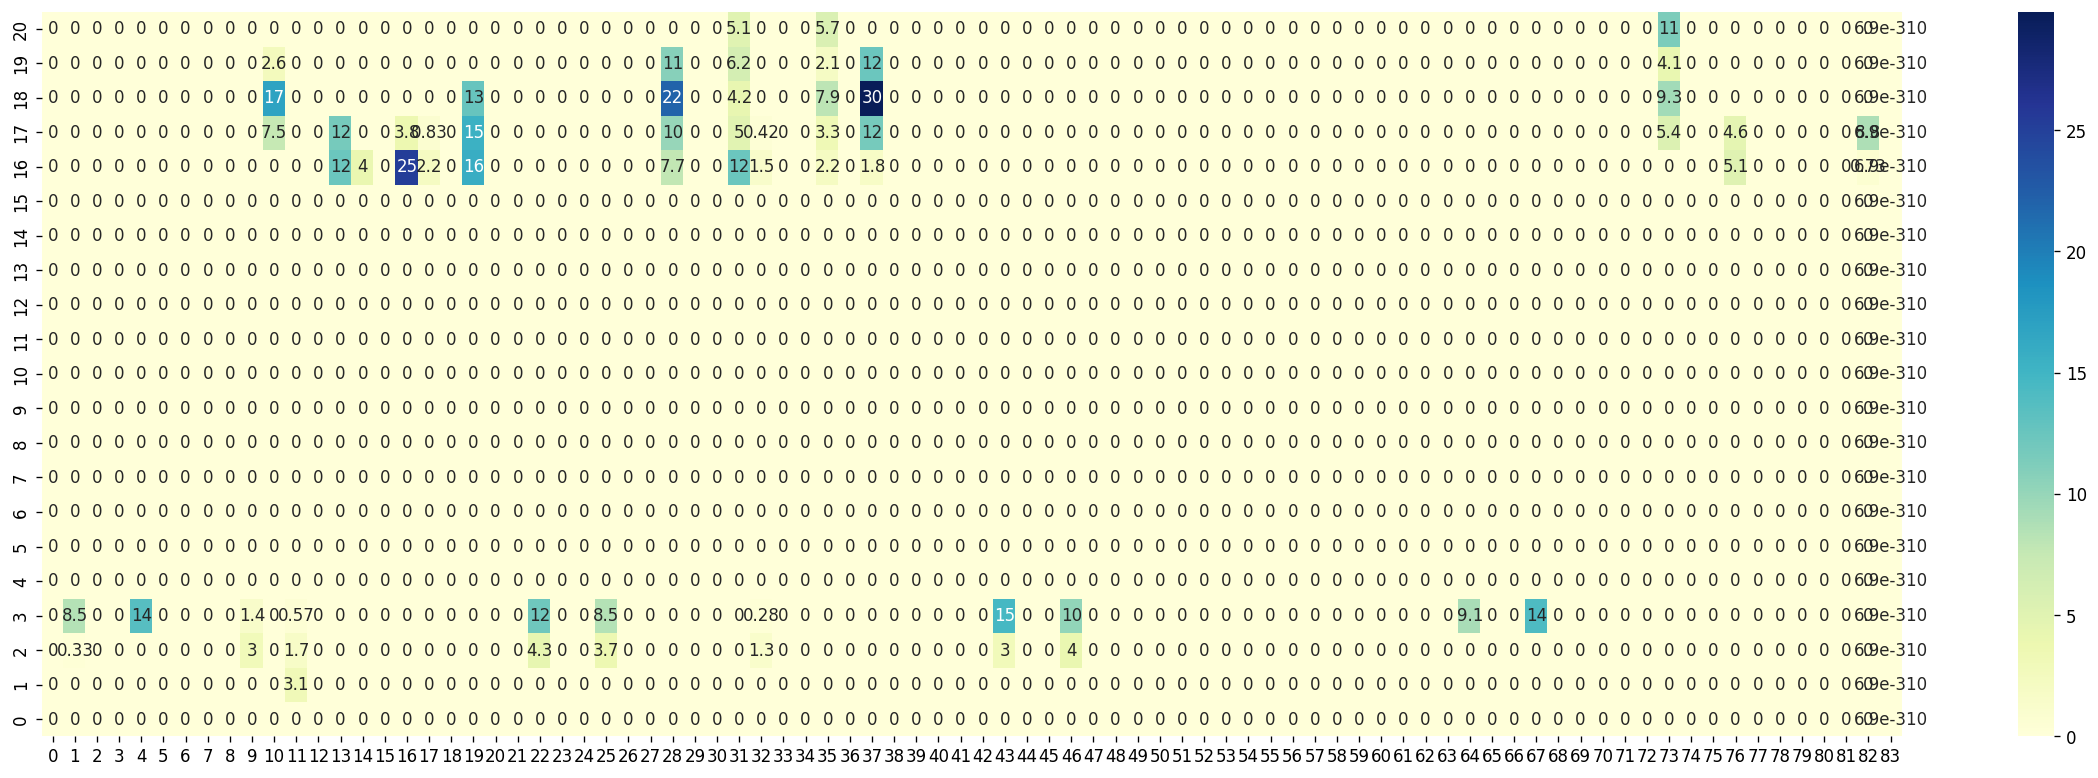

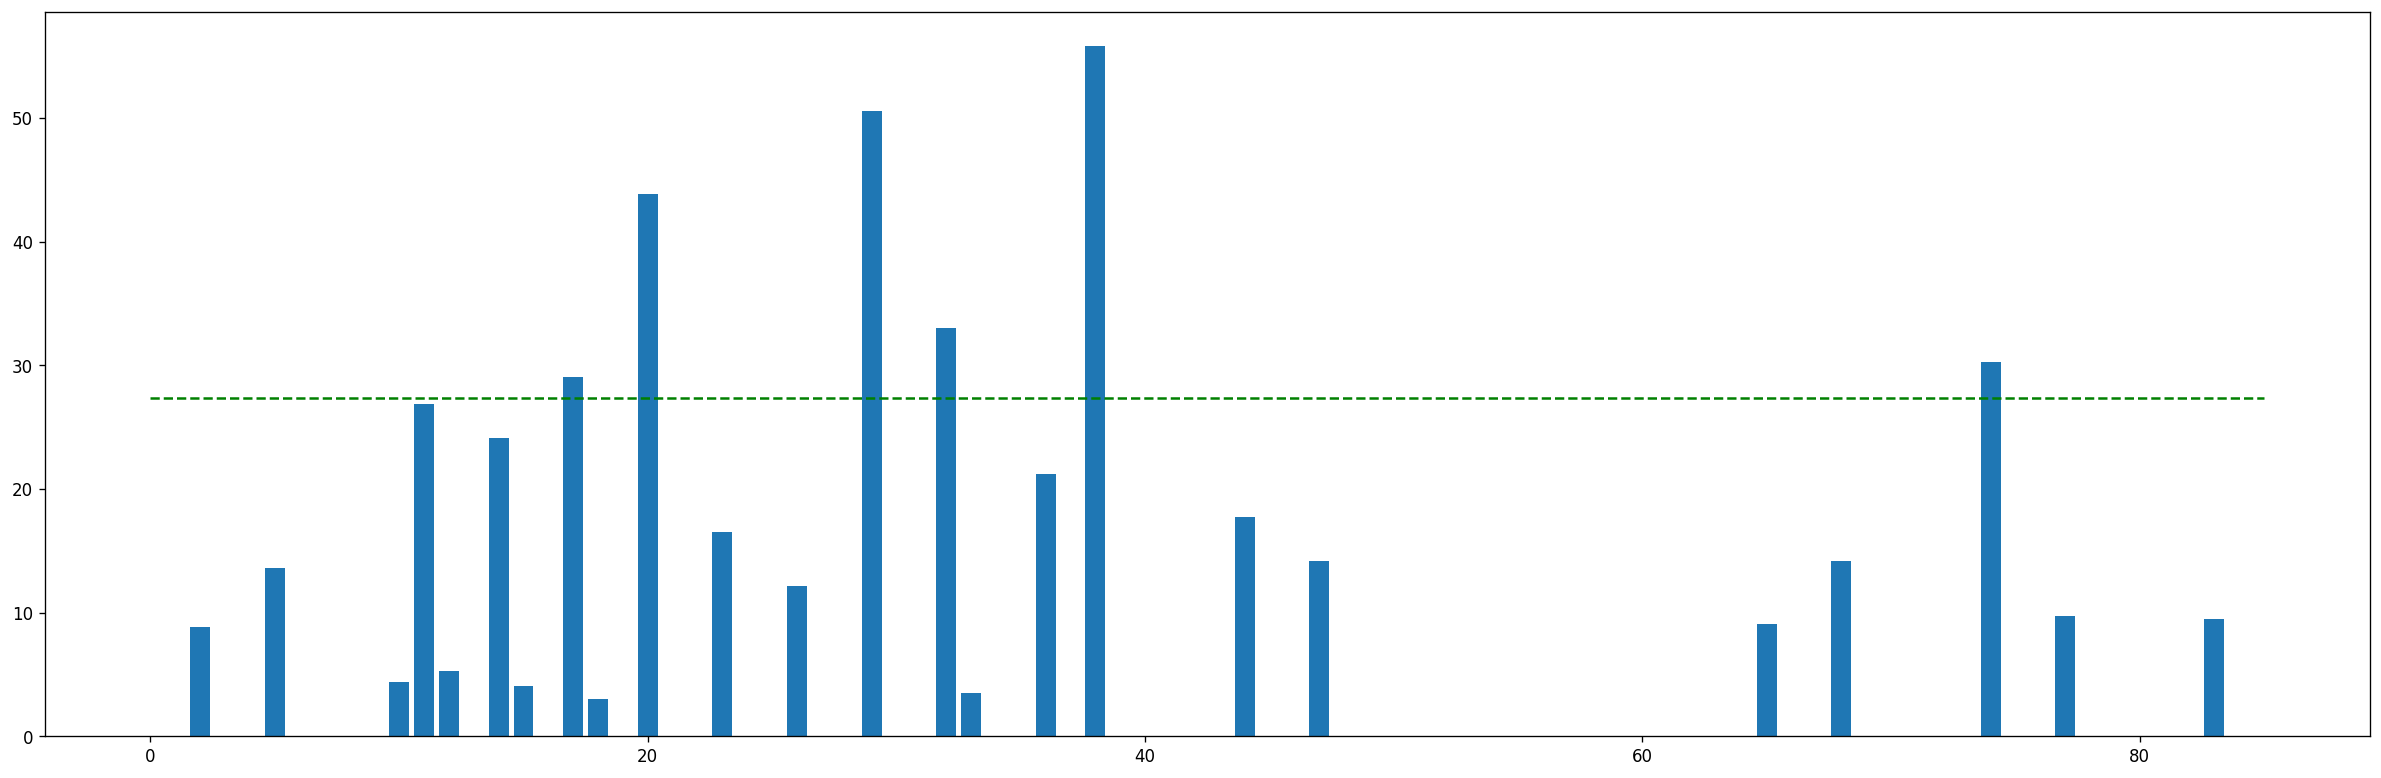

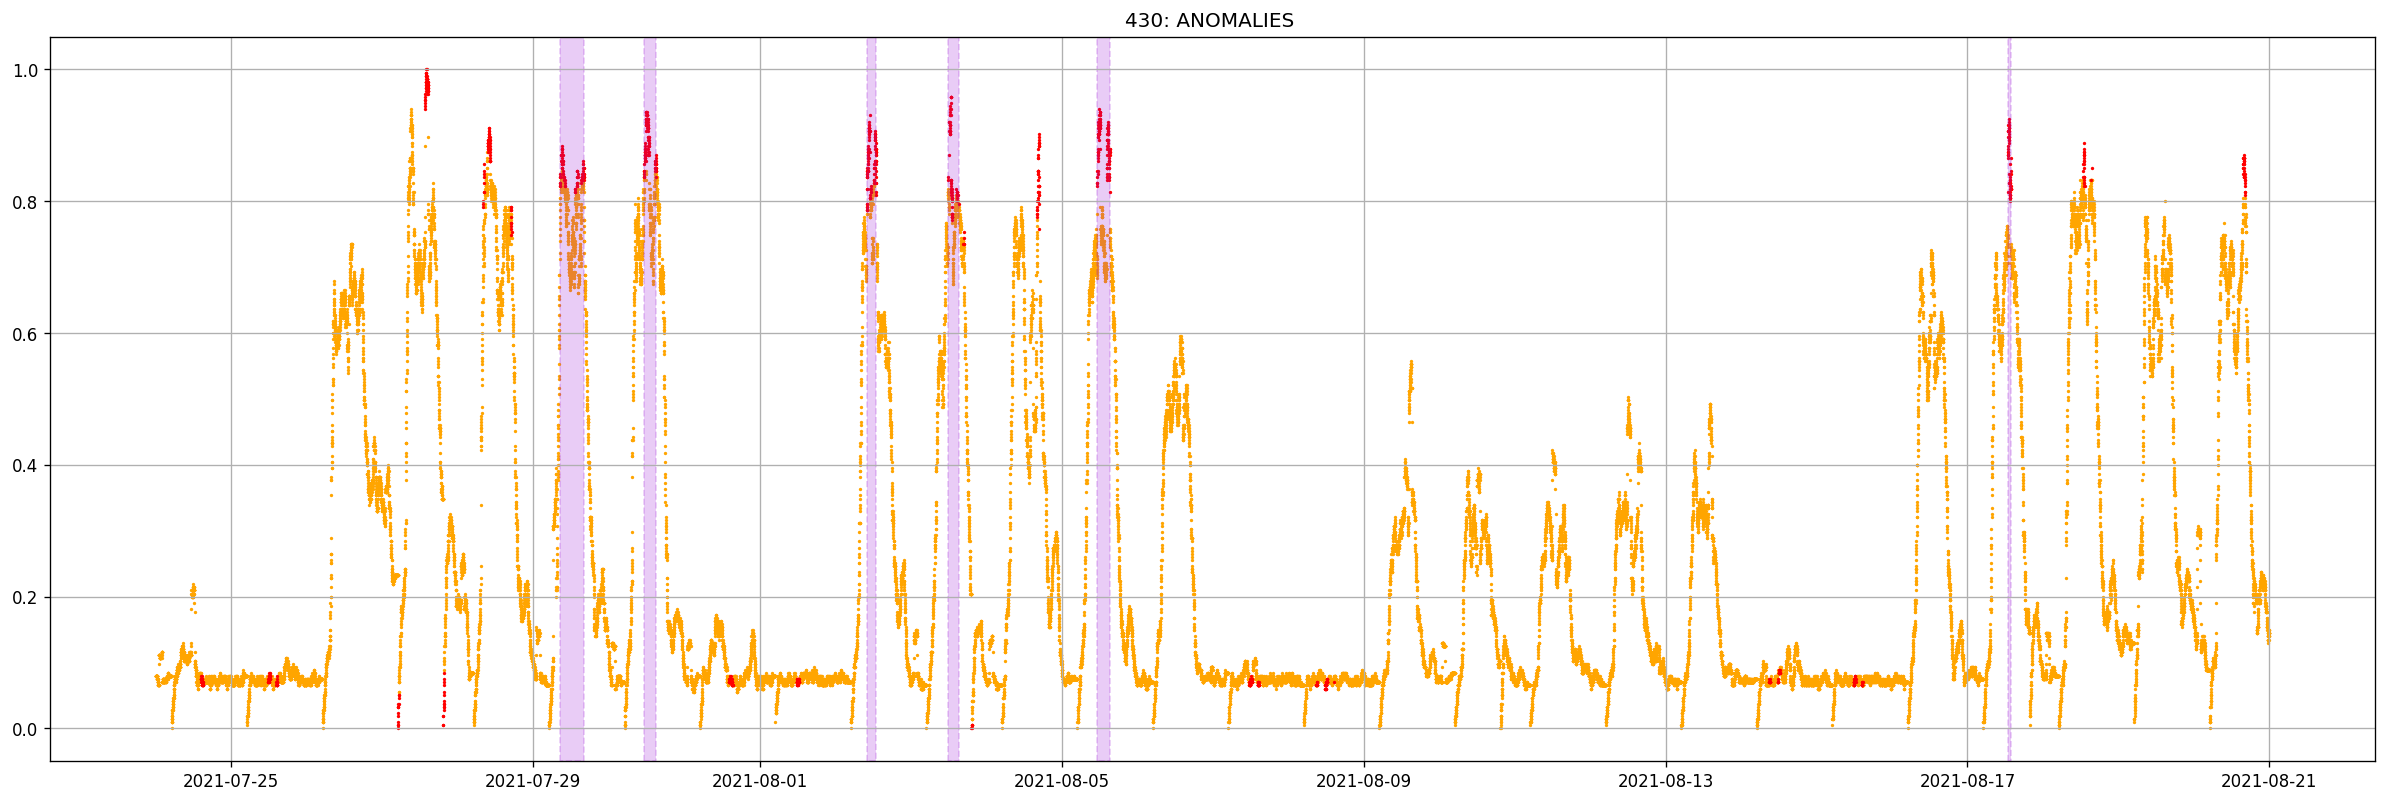

430 execution time :13.83298110961914 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

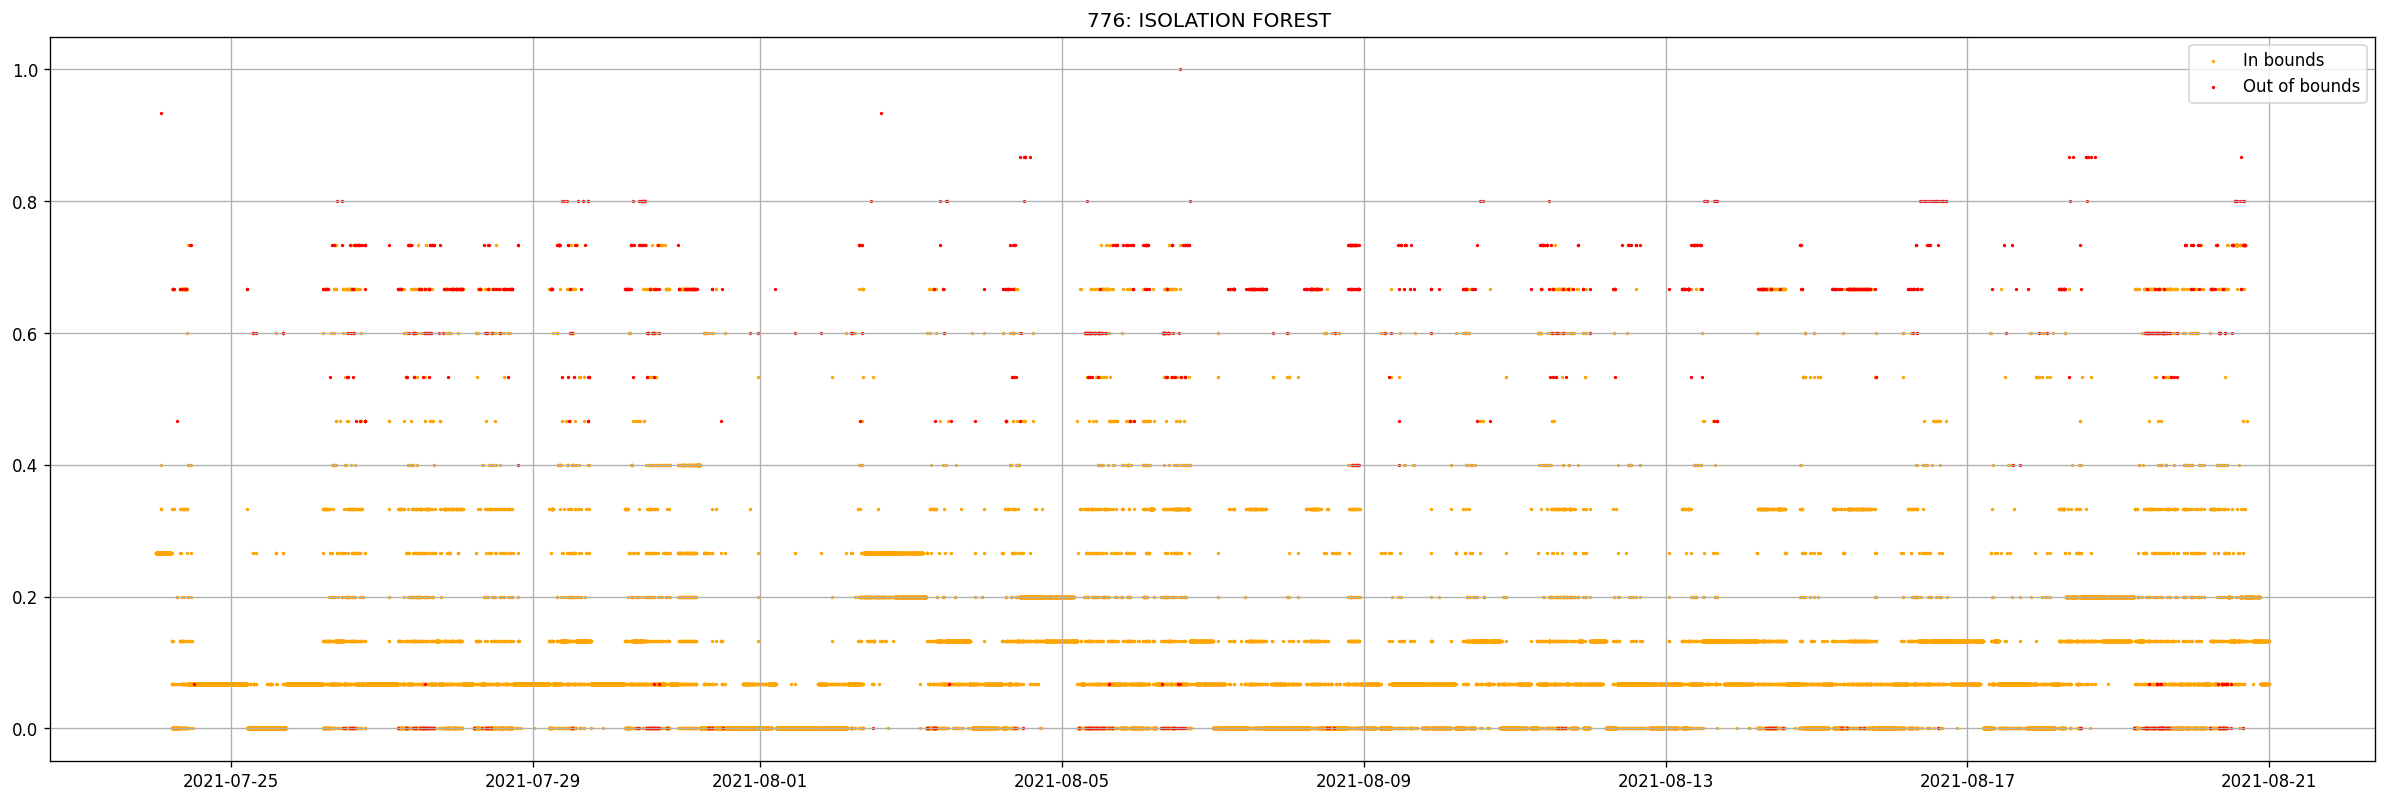

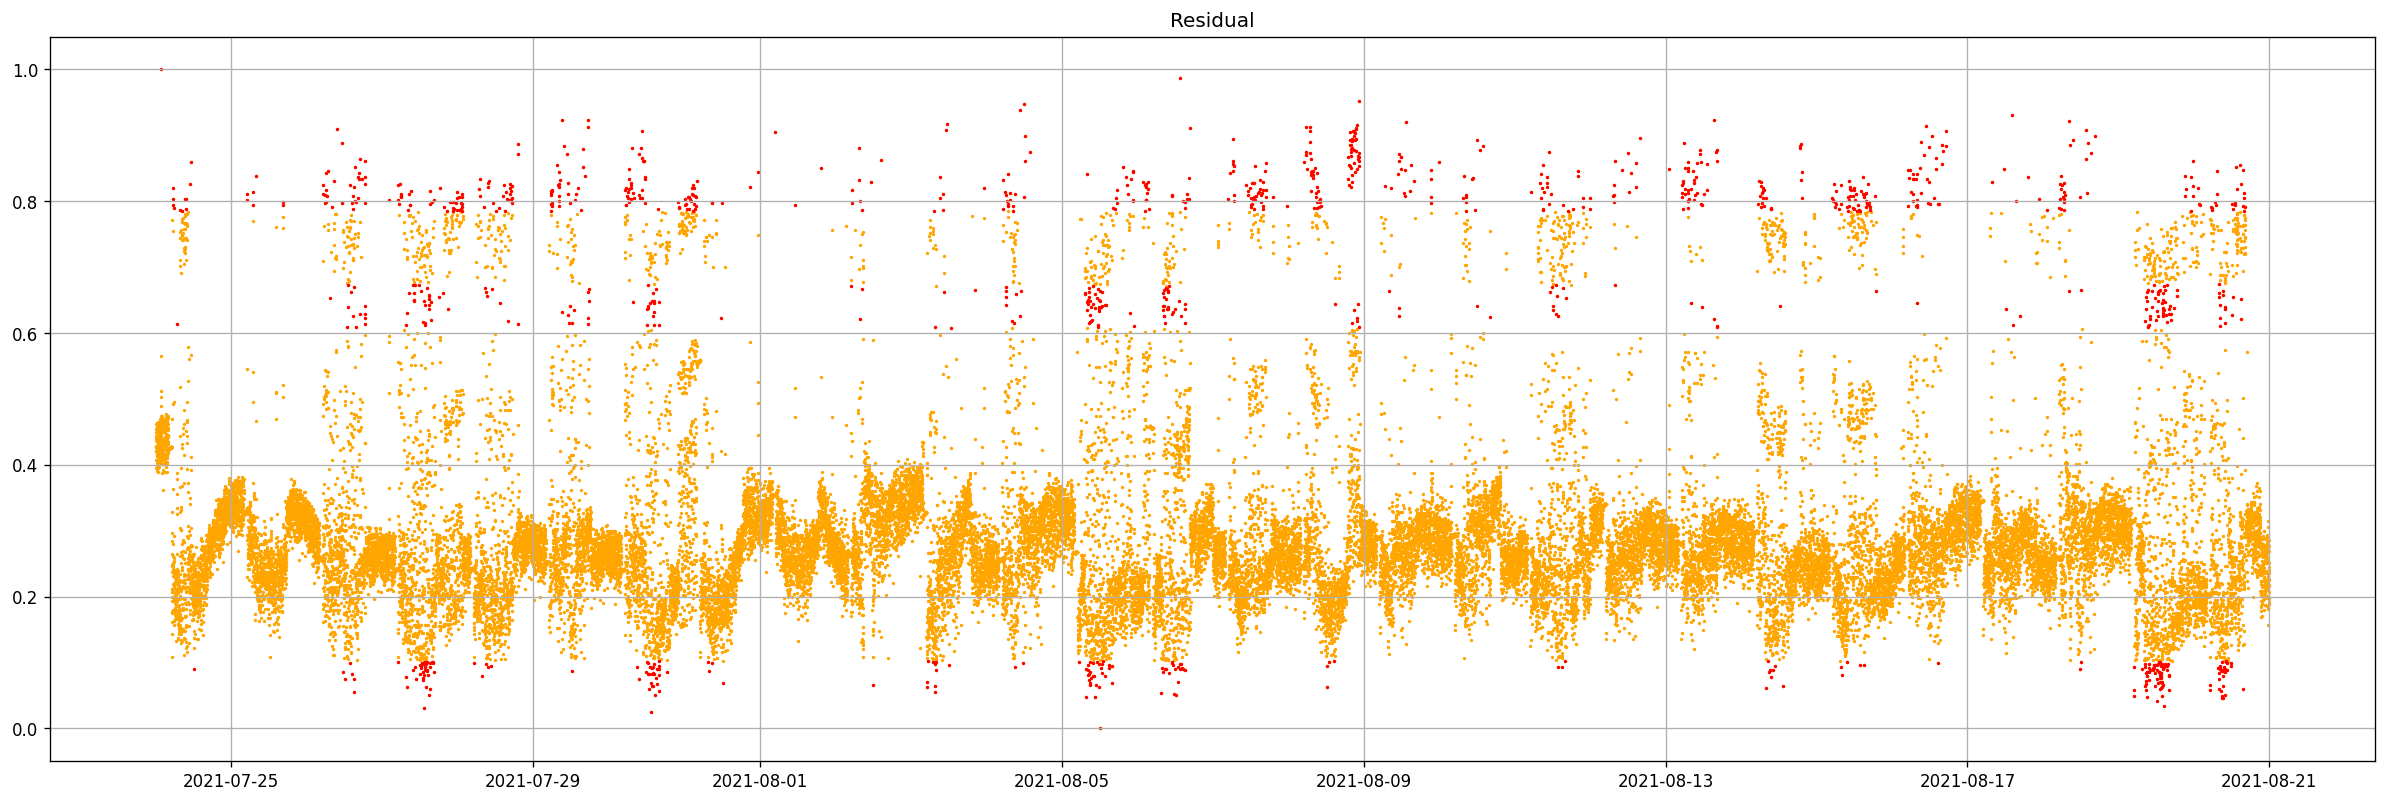

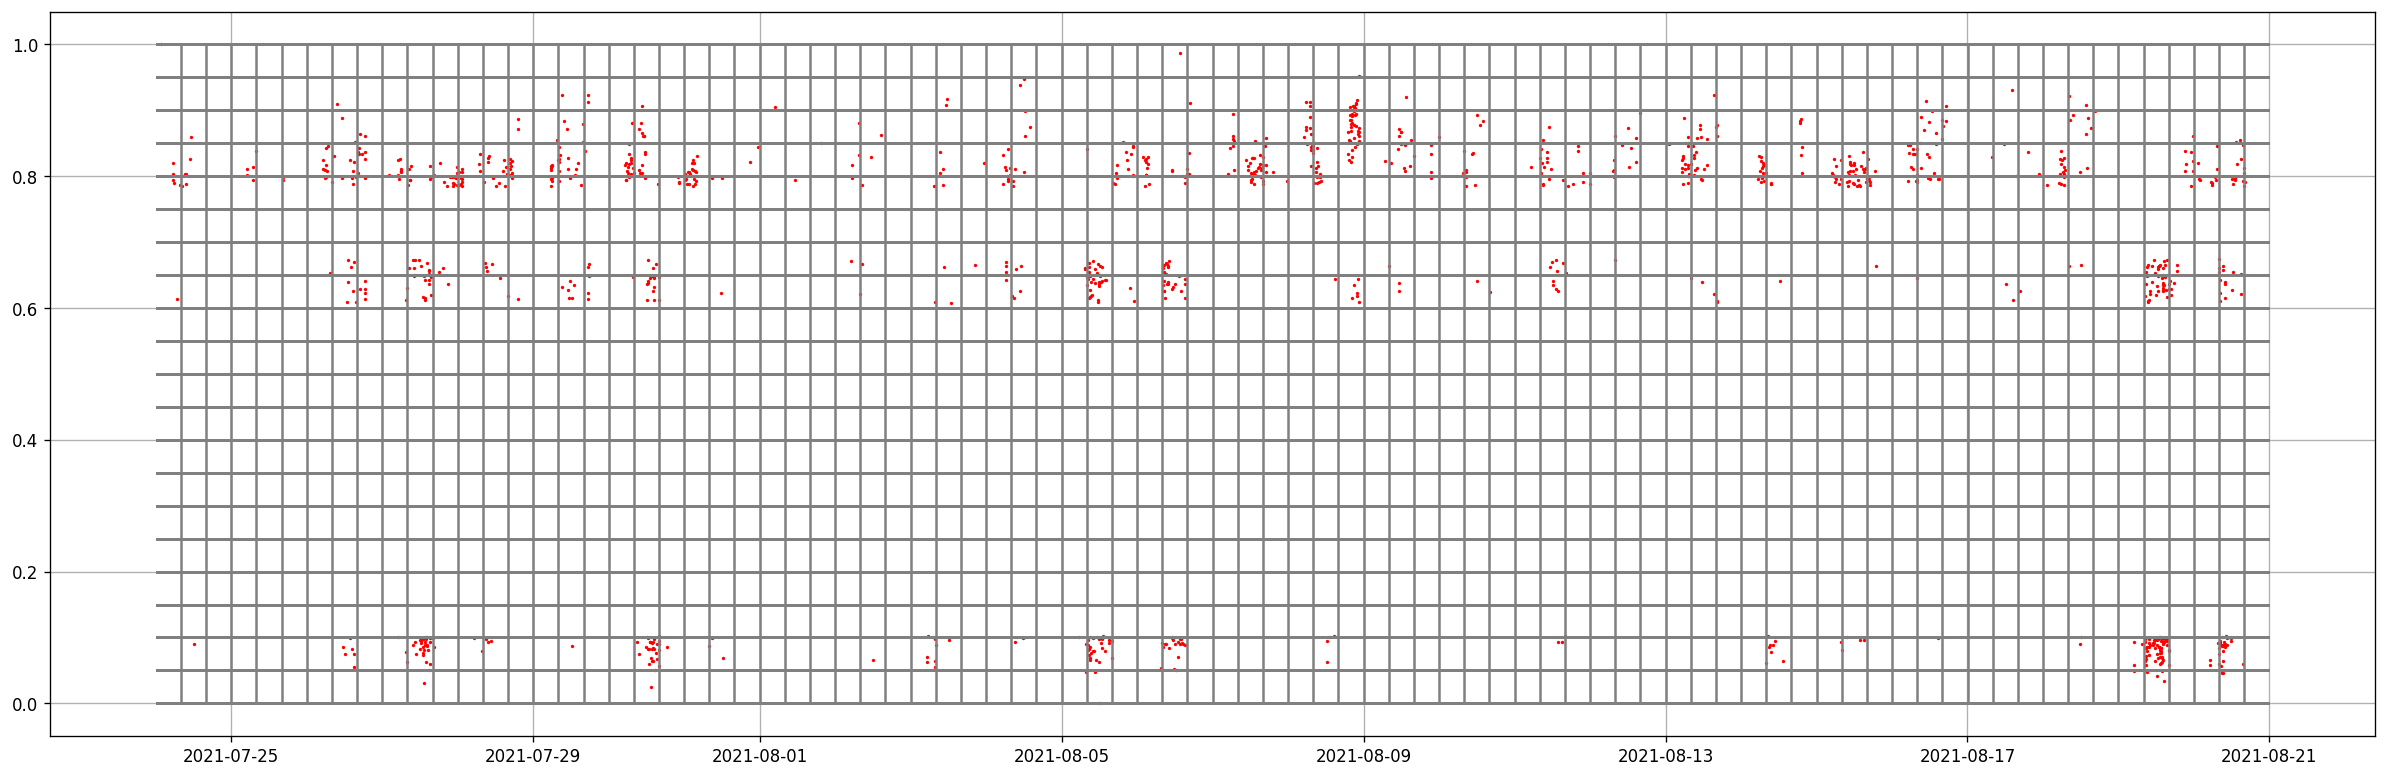

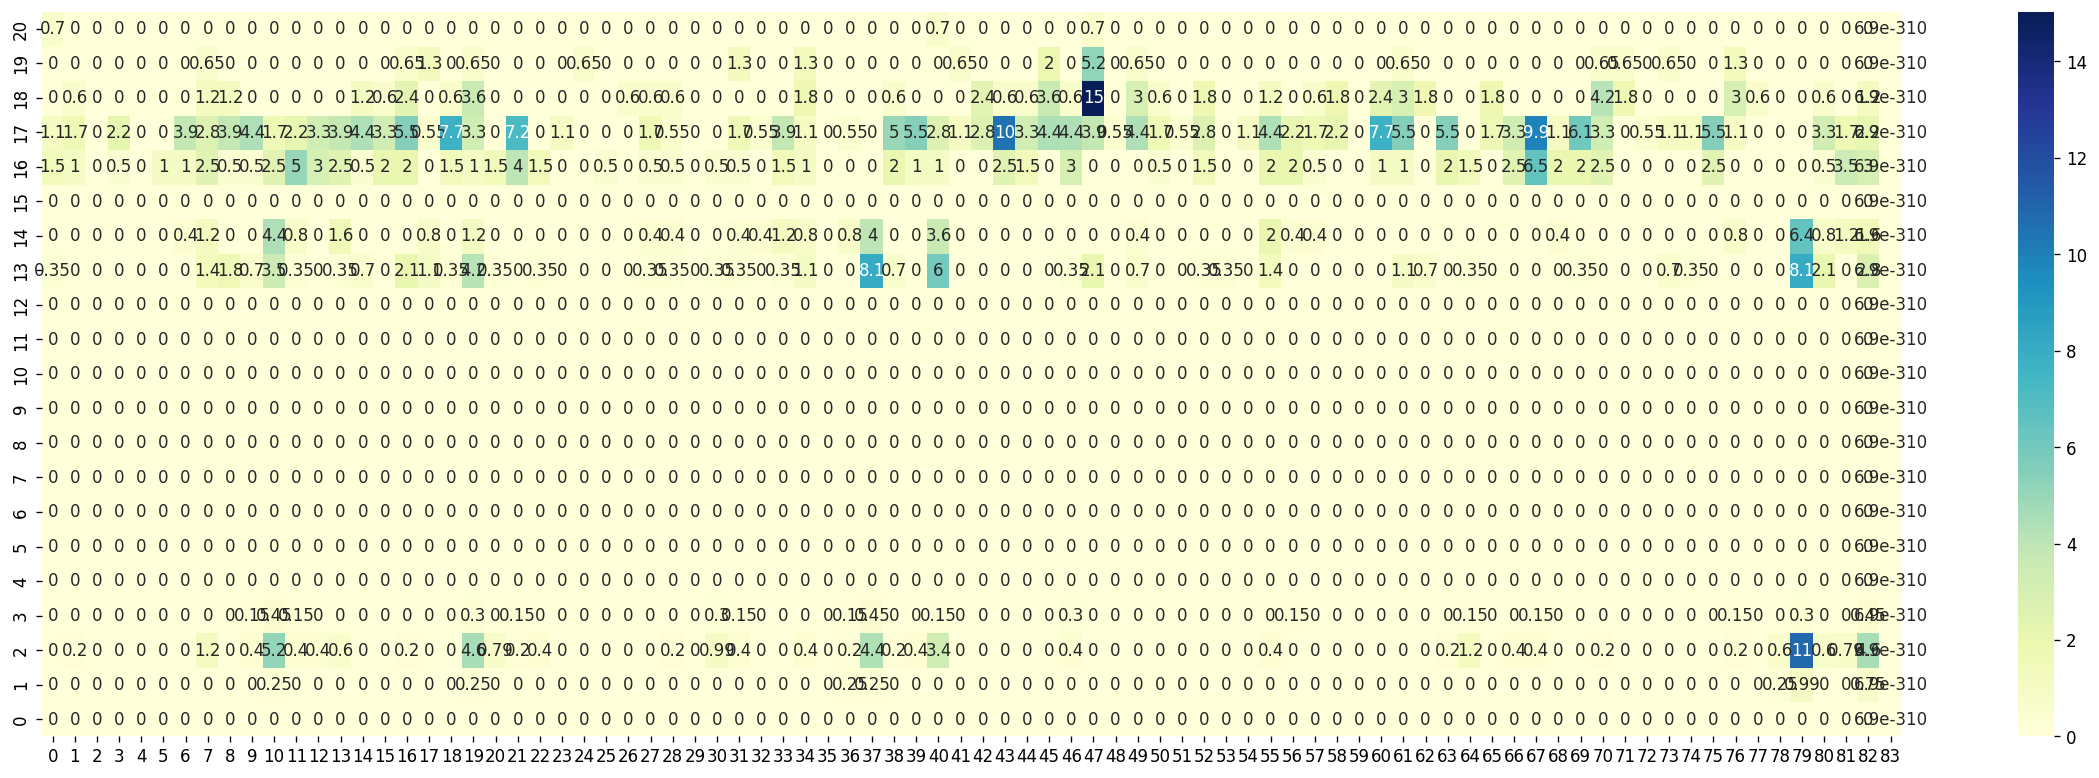

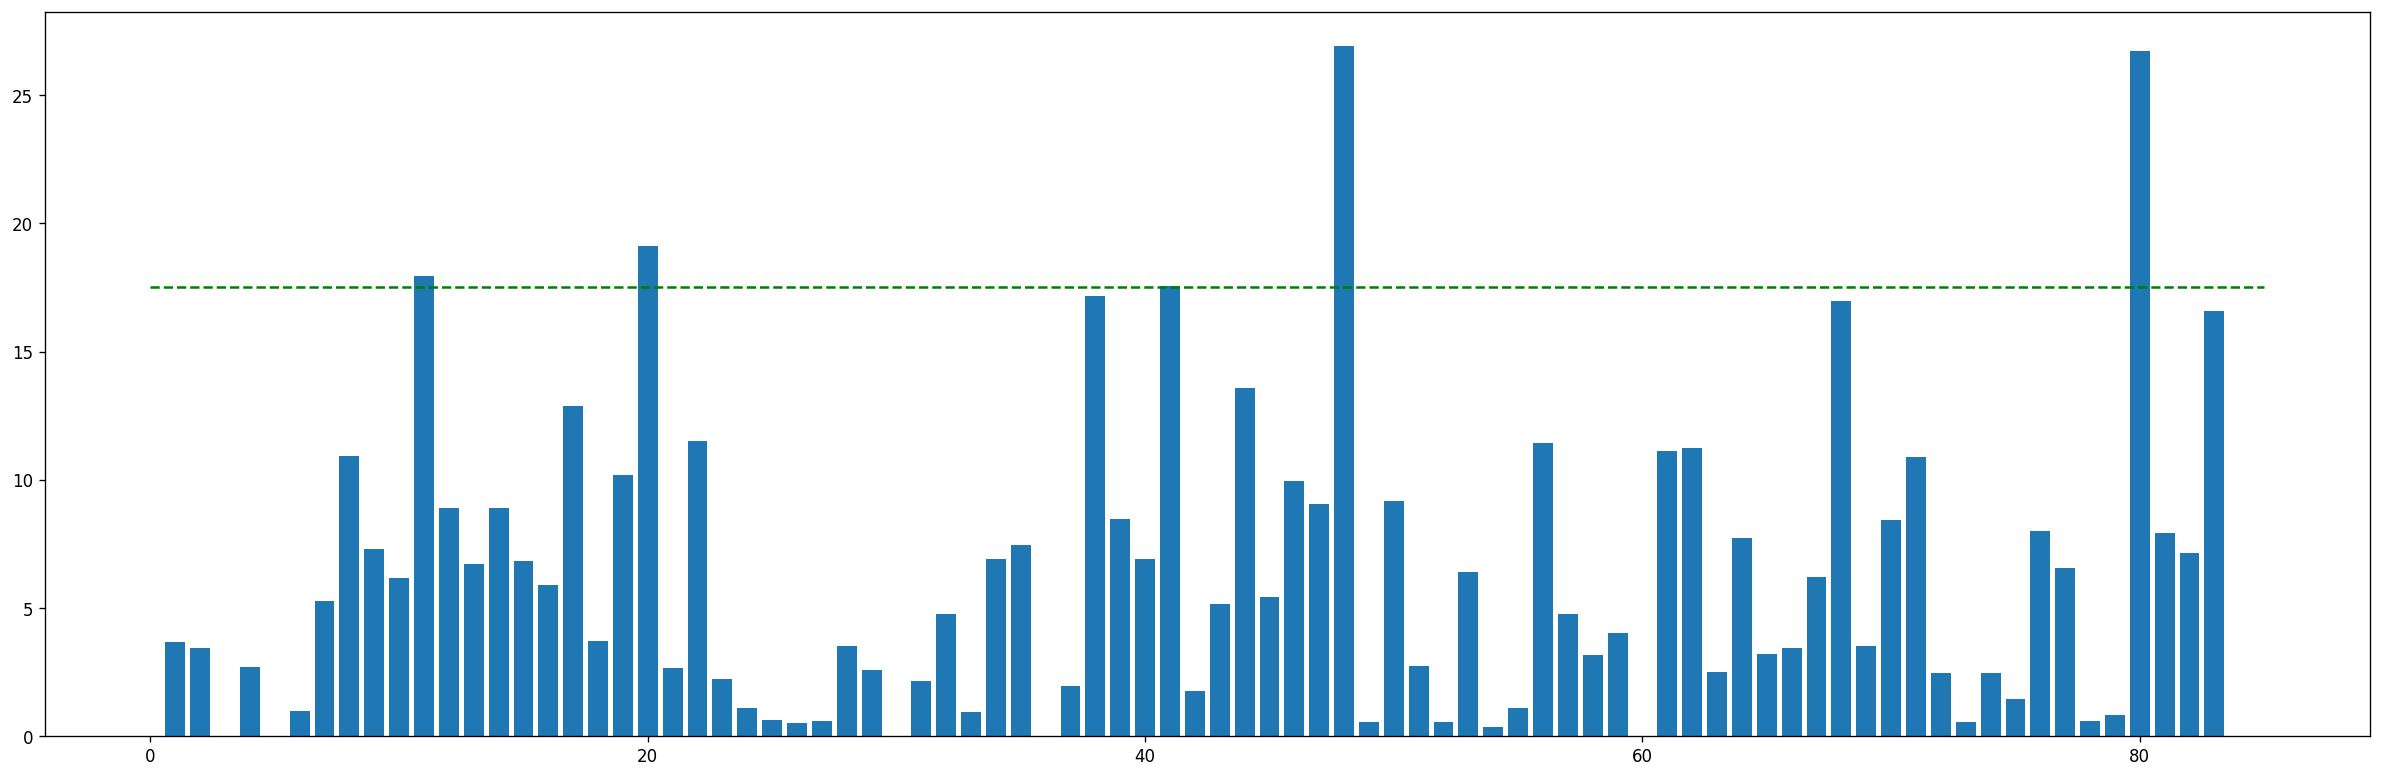

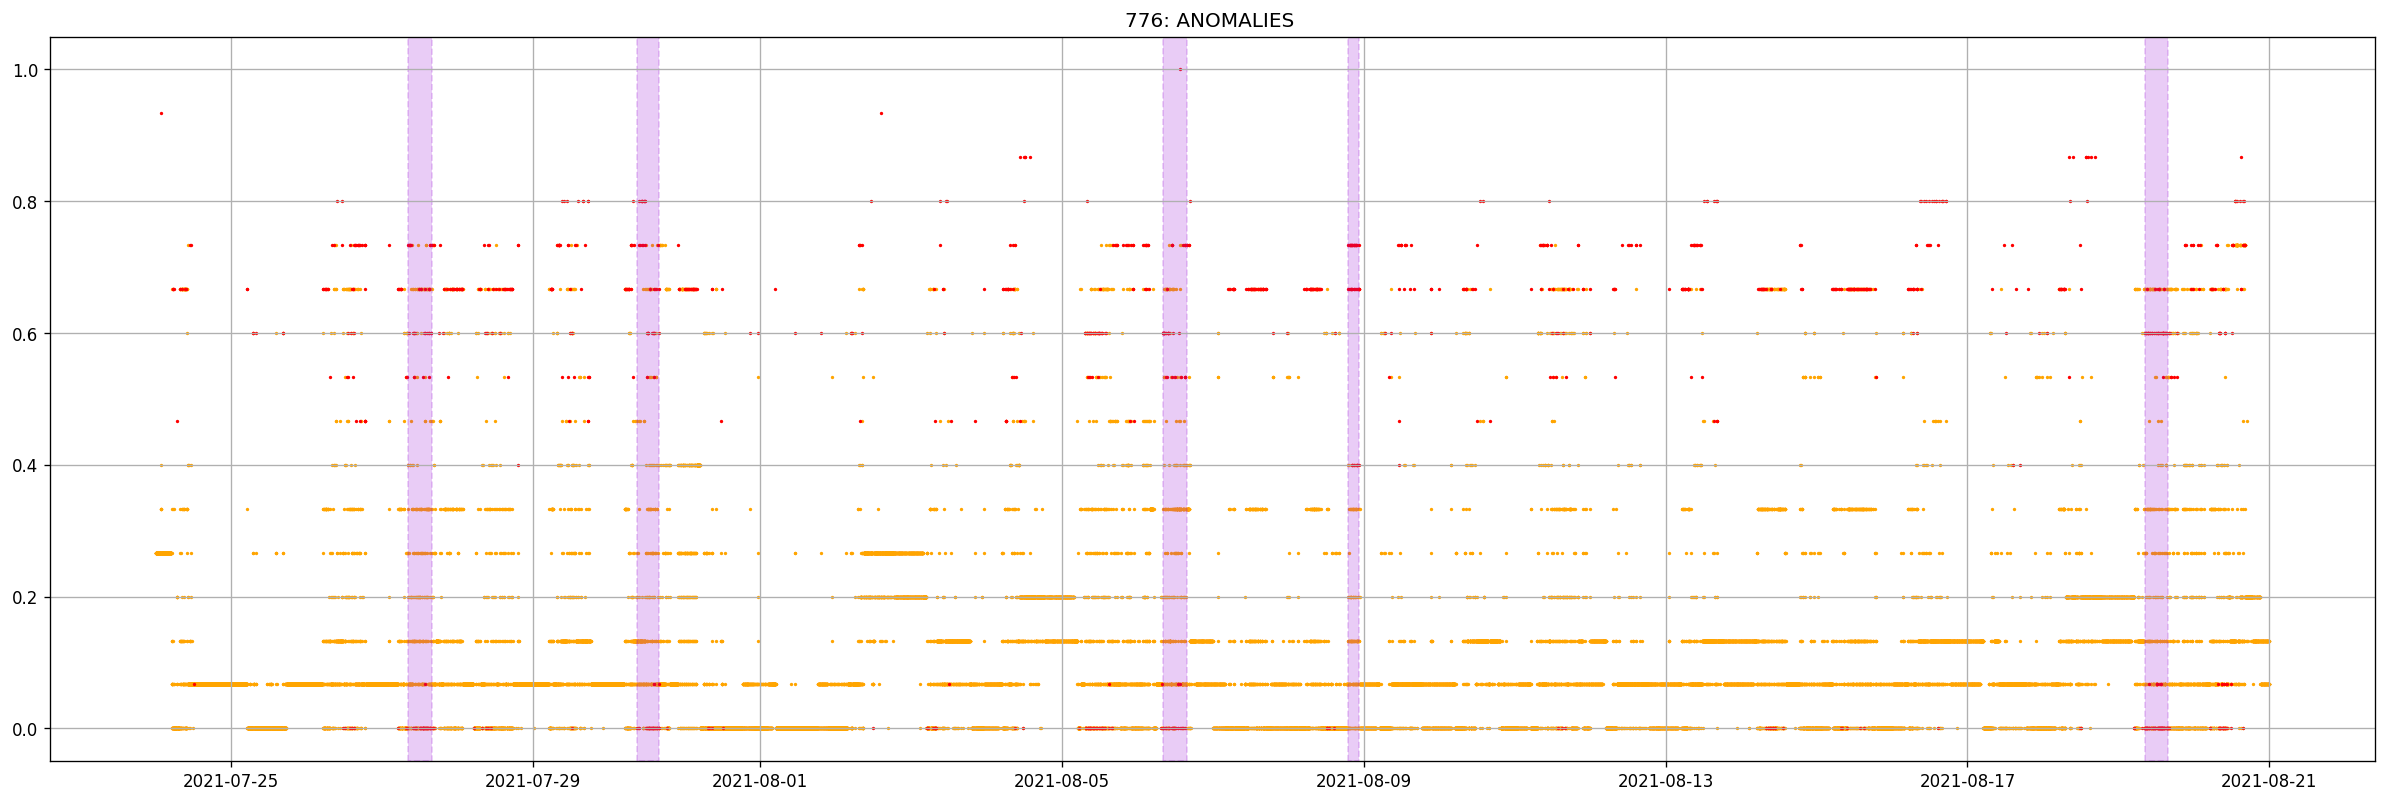

776 execution time :14.626867294311523 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

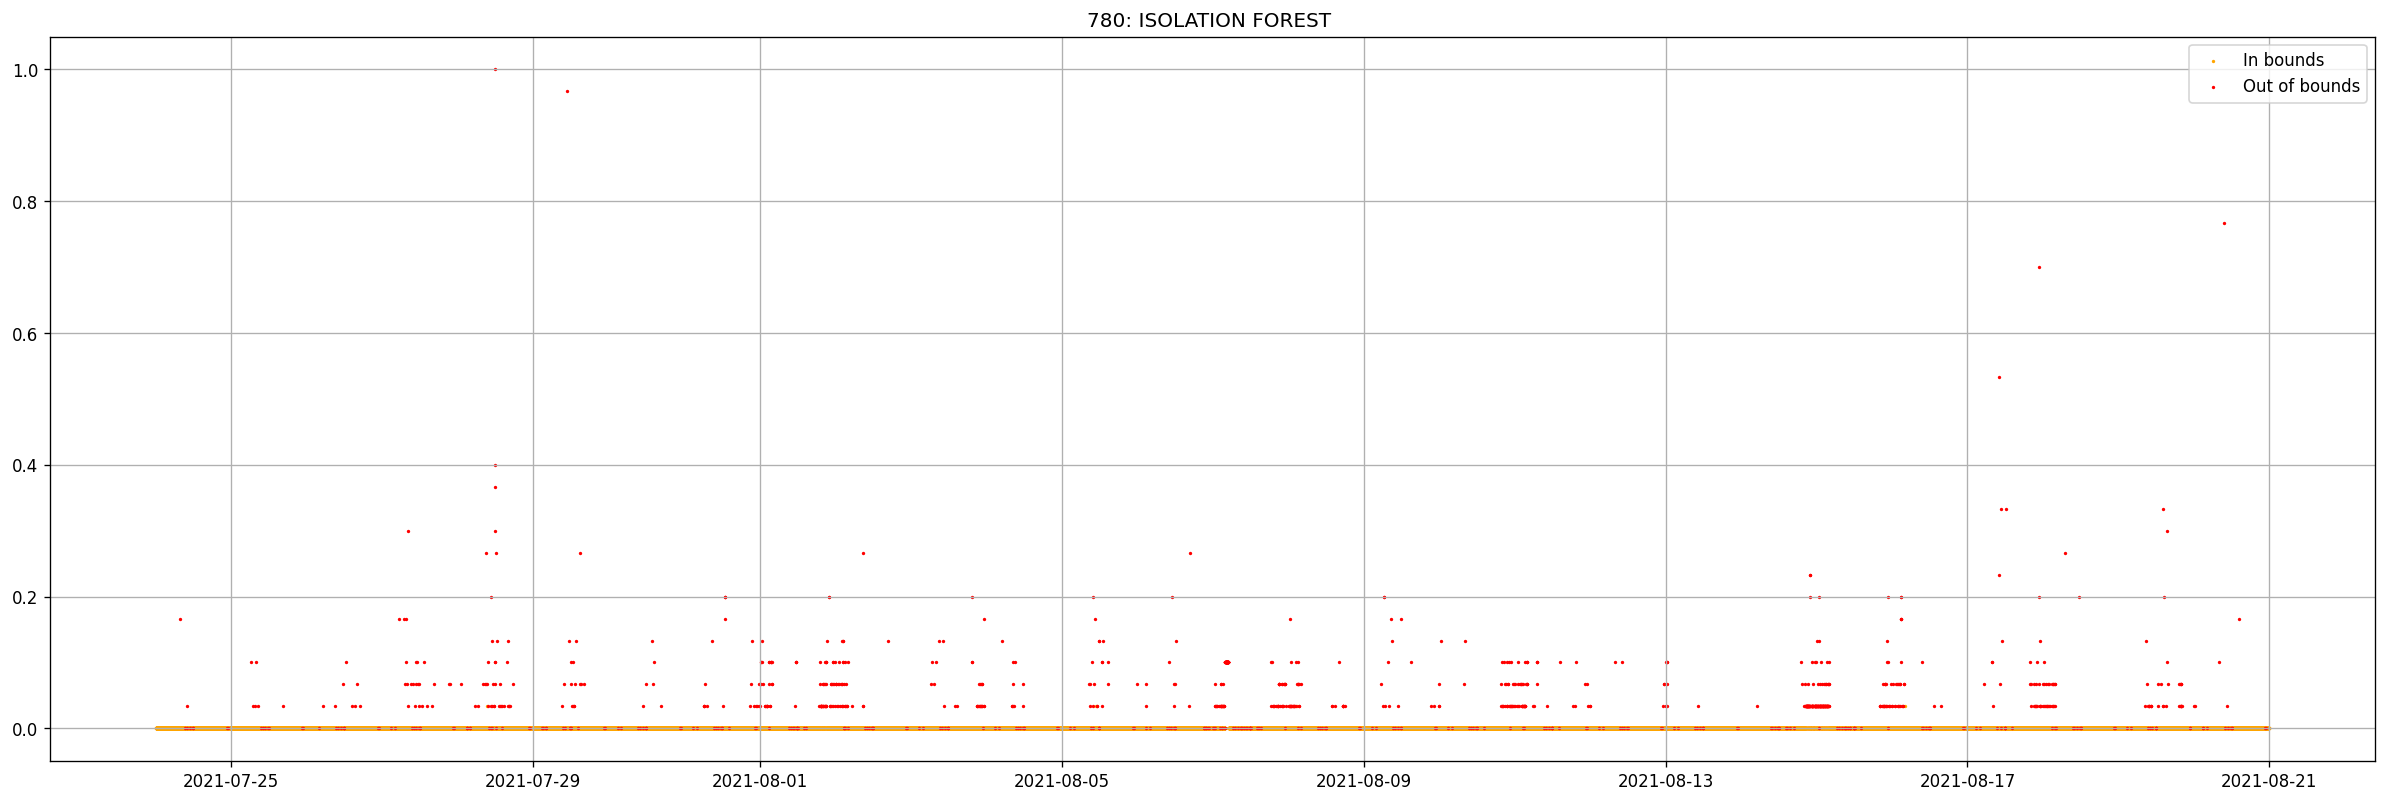

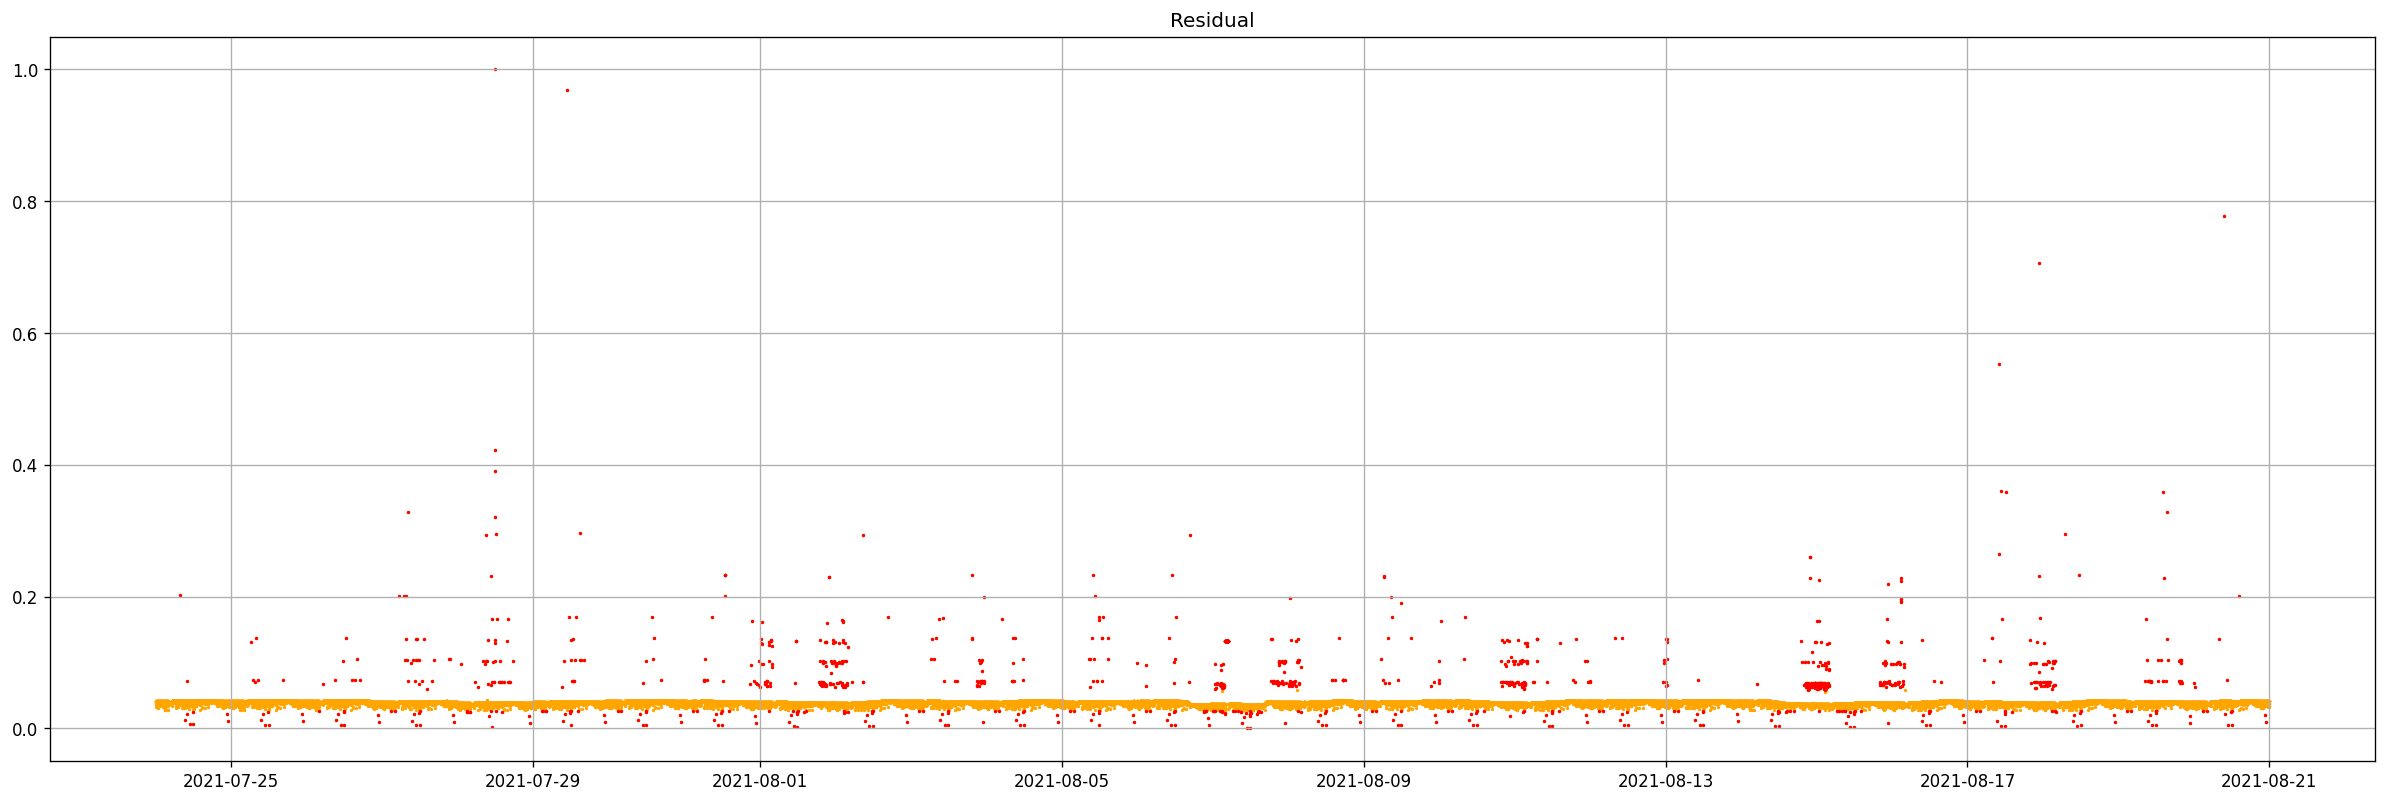

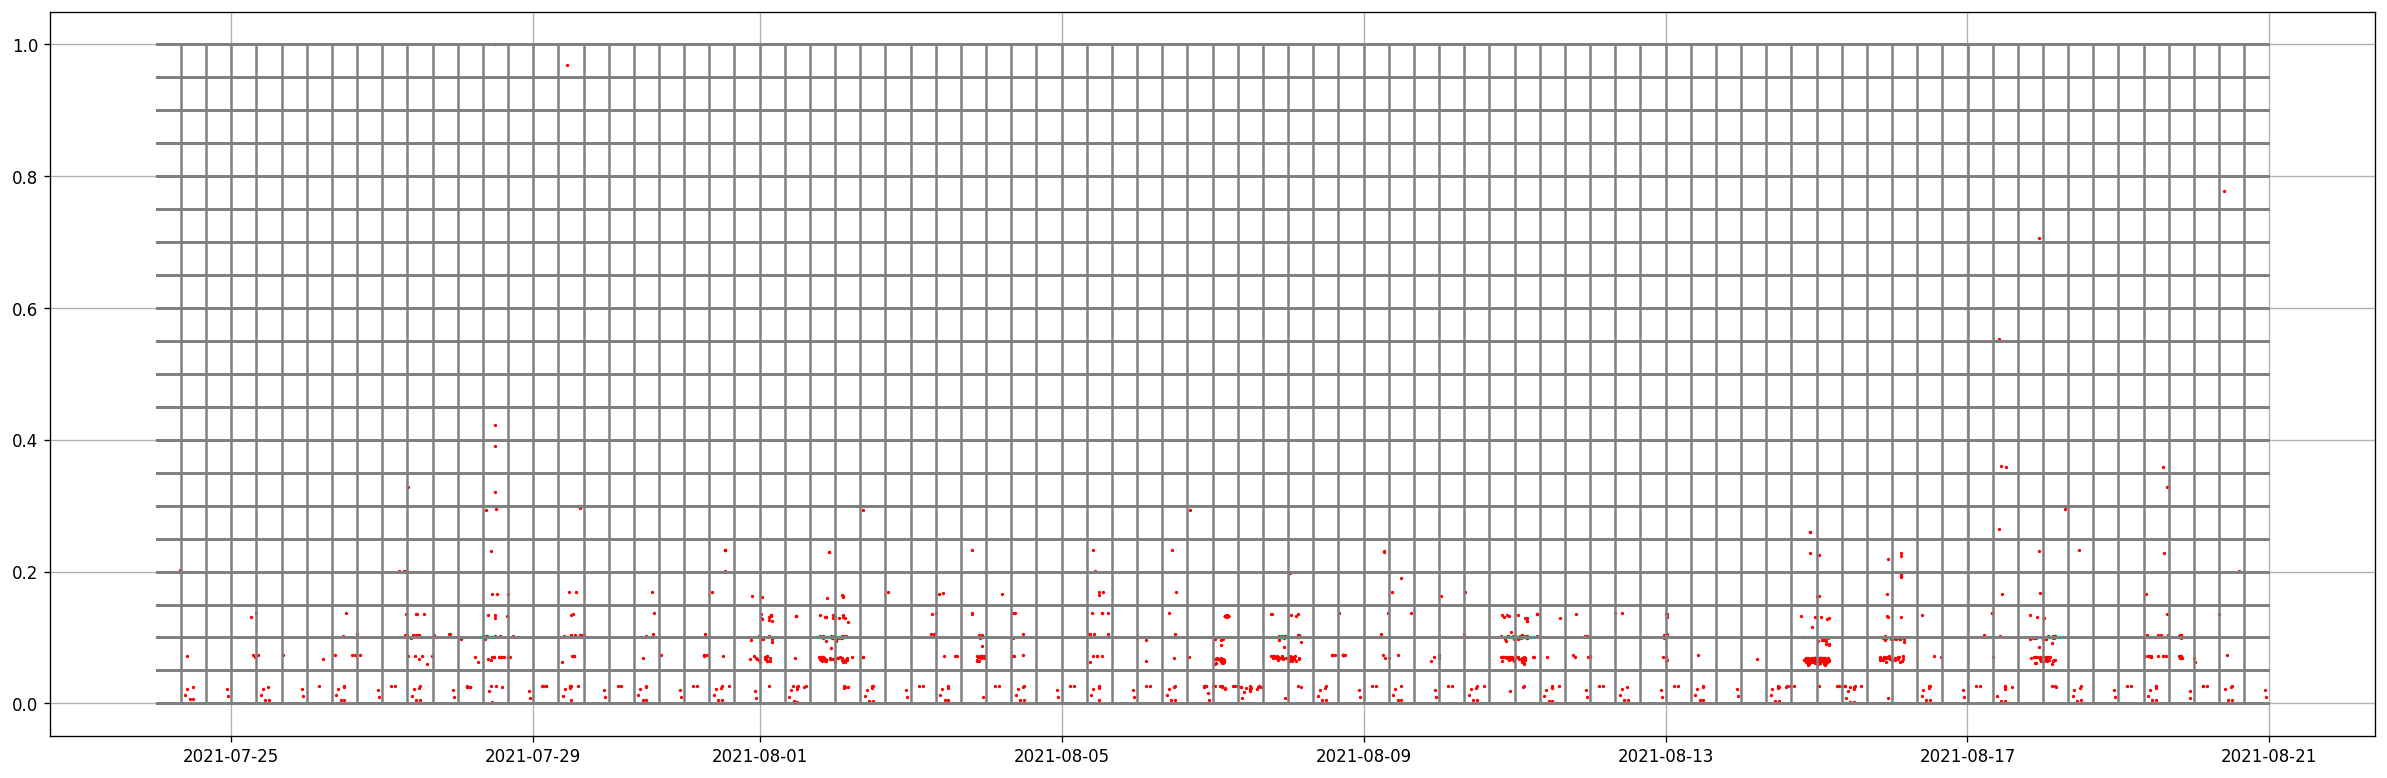

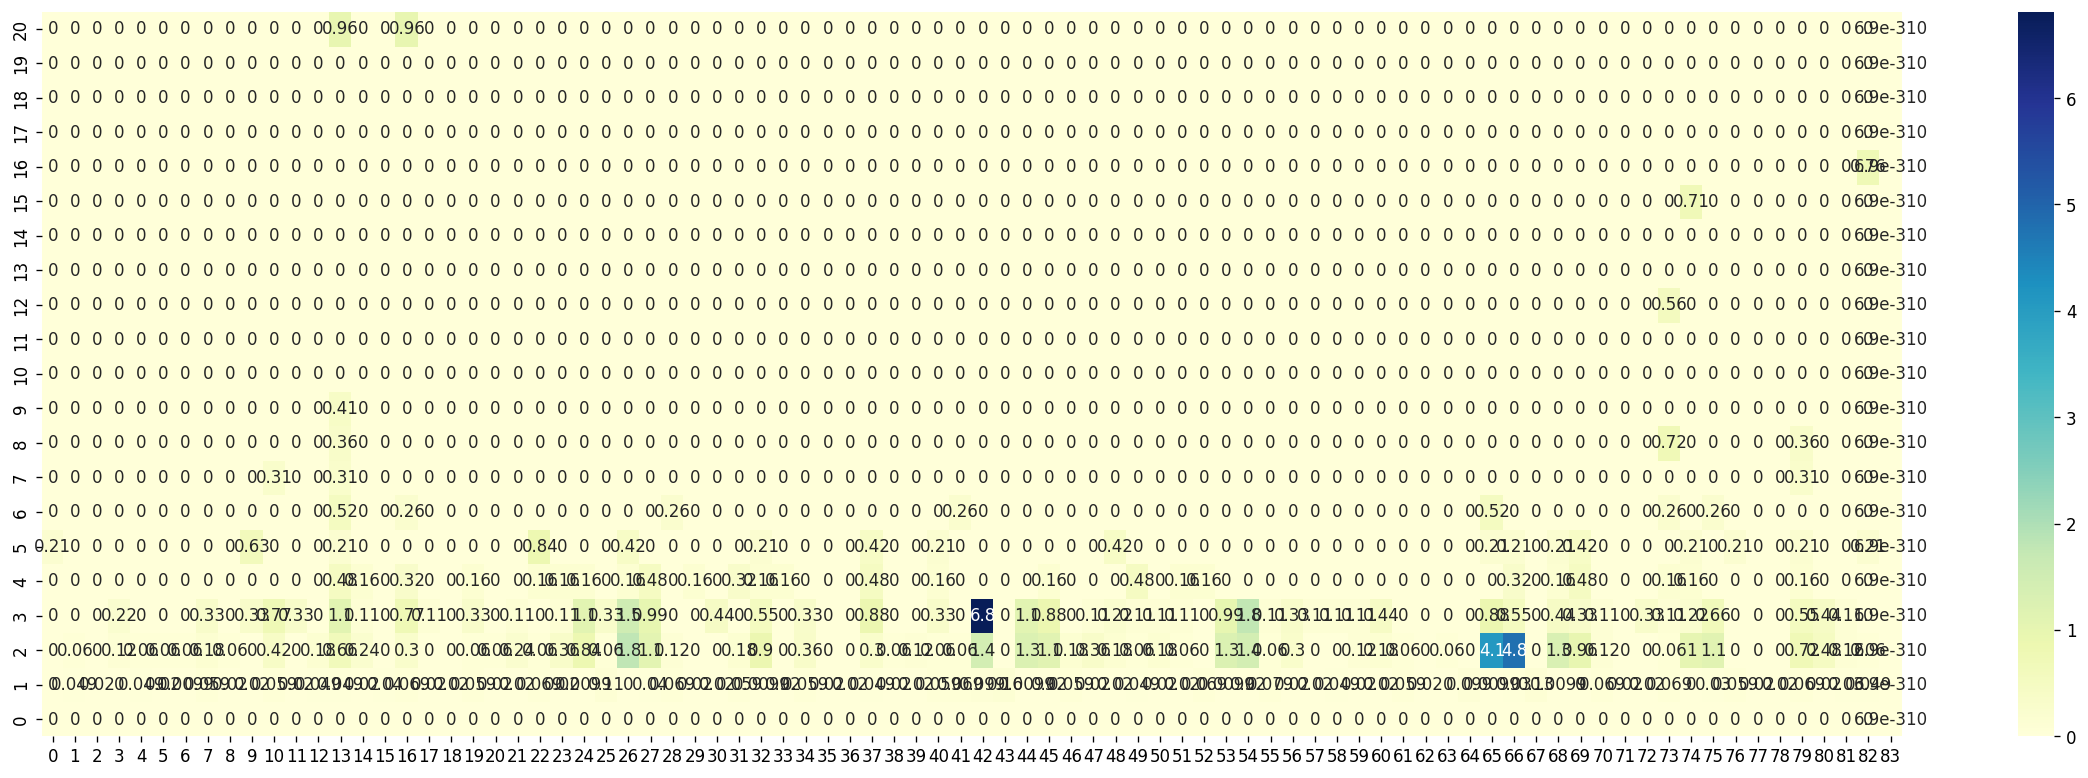

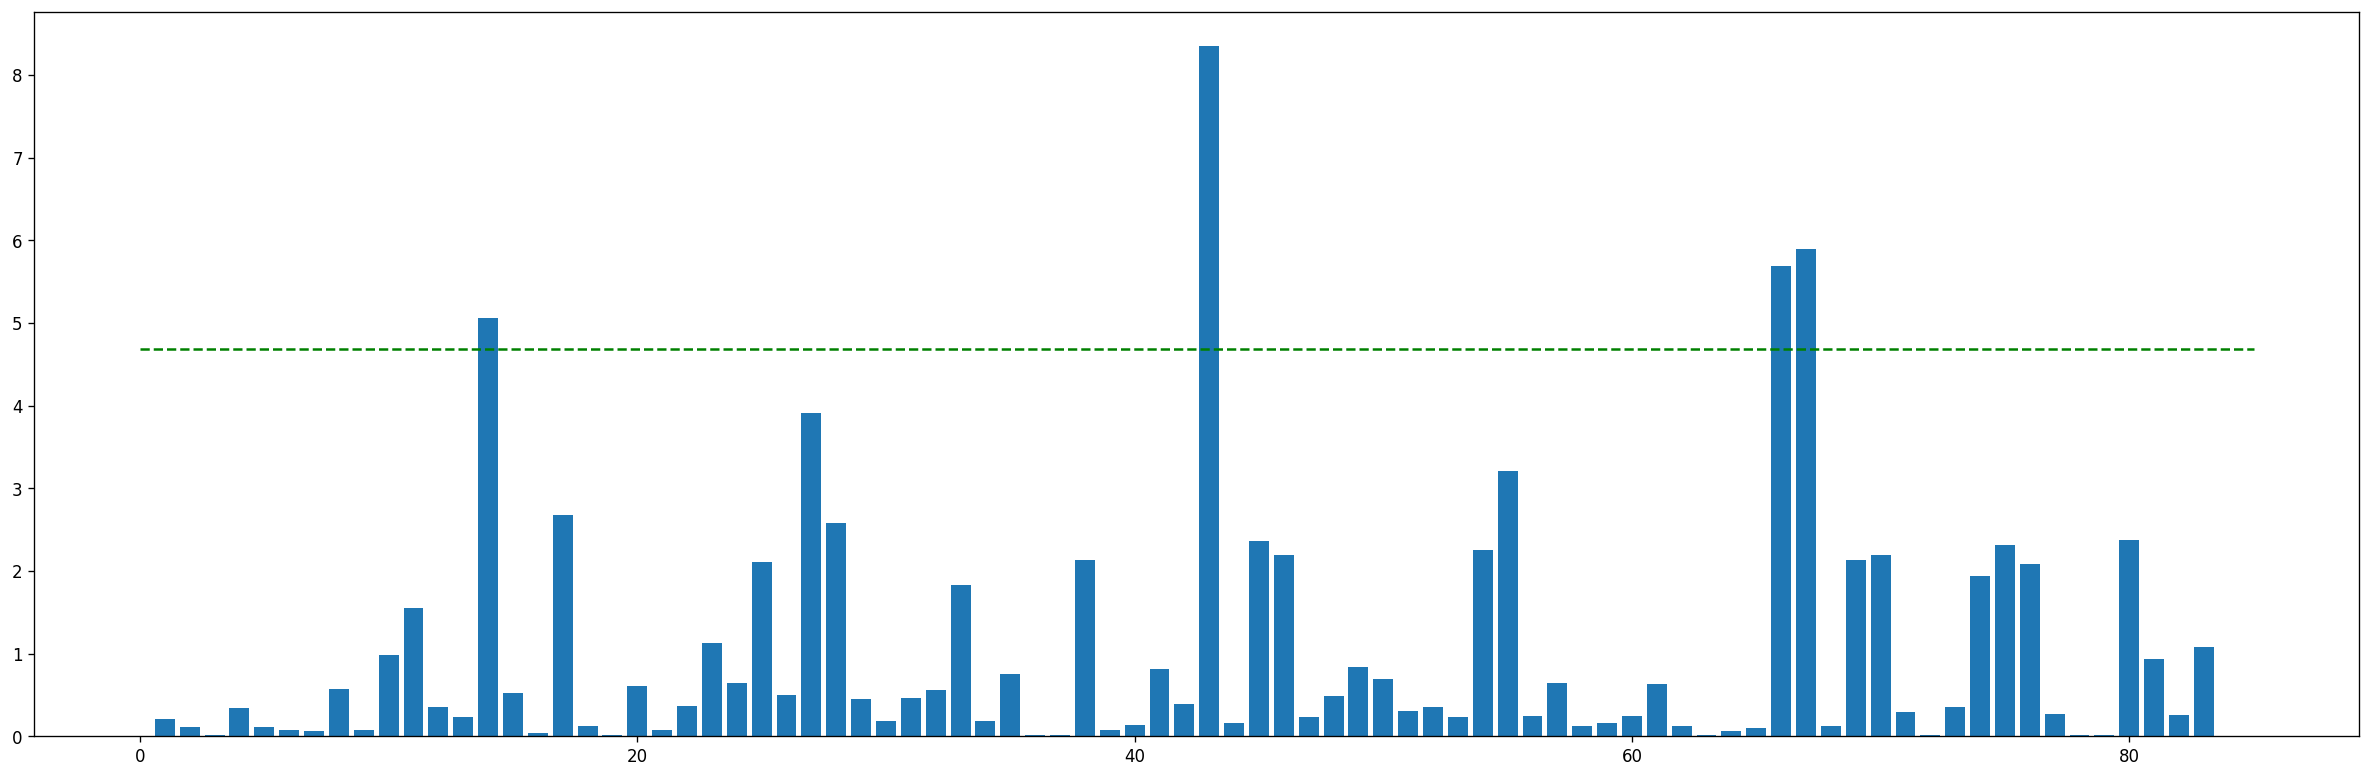

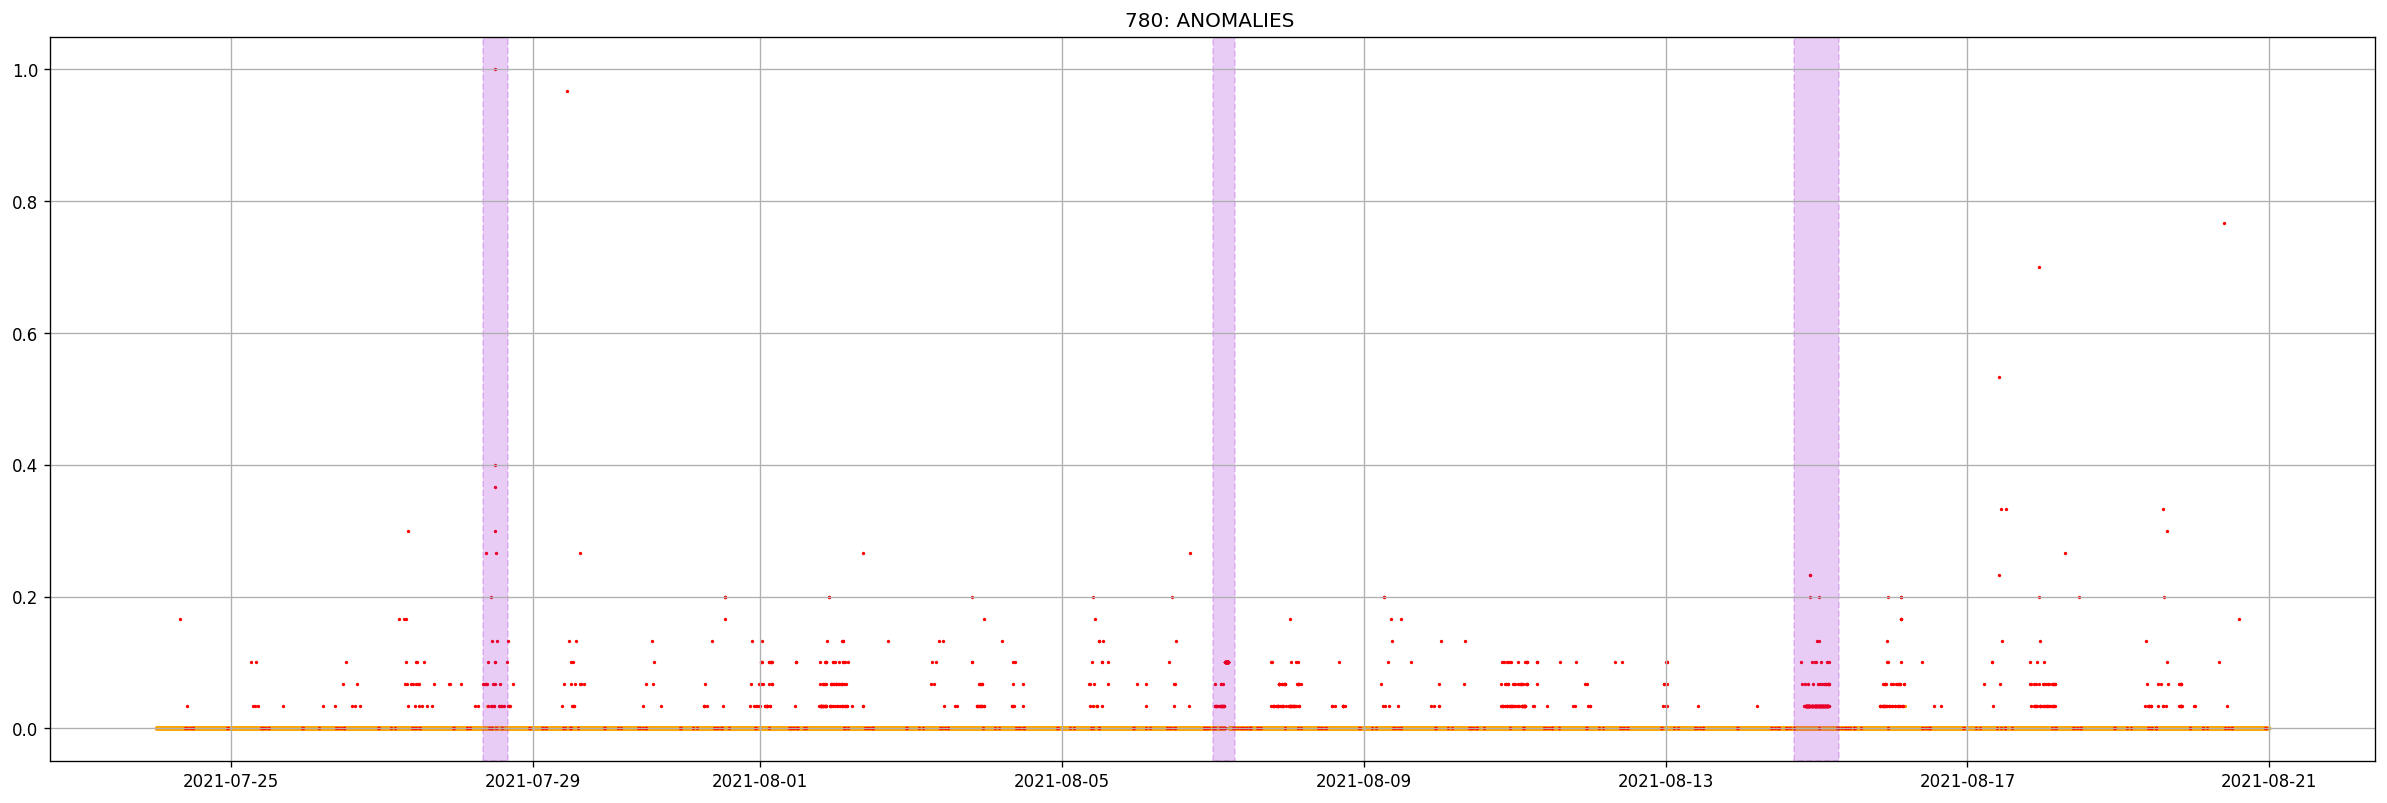

780 execution time :13.895205974578857 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

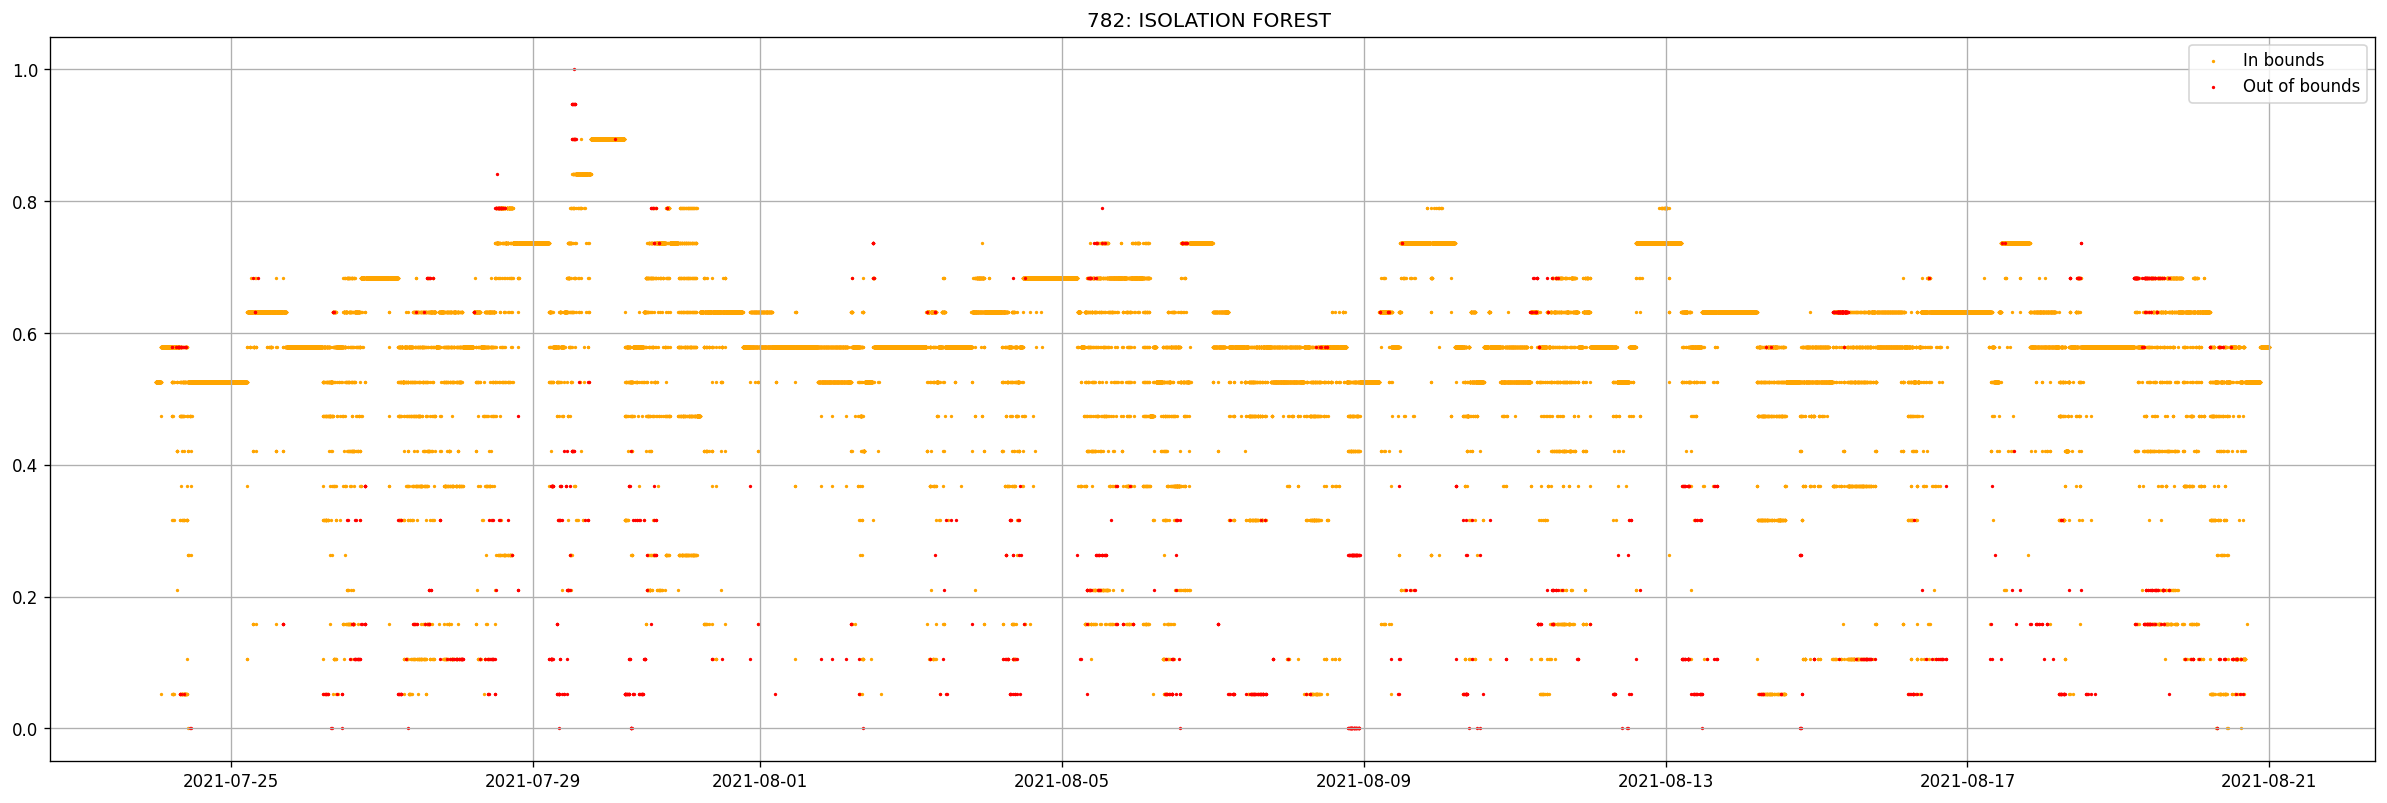

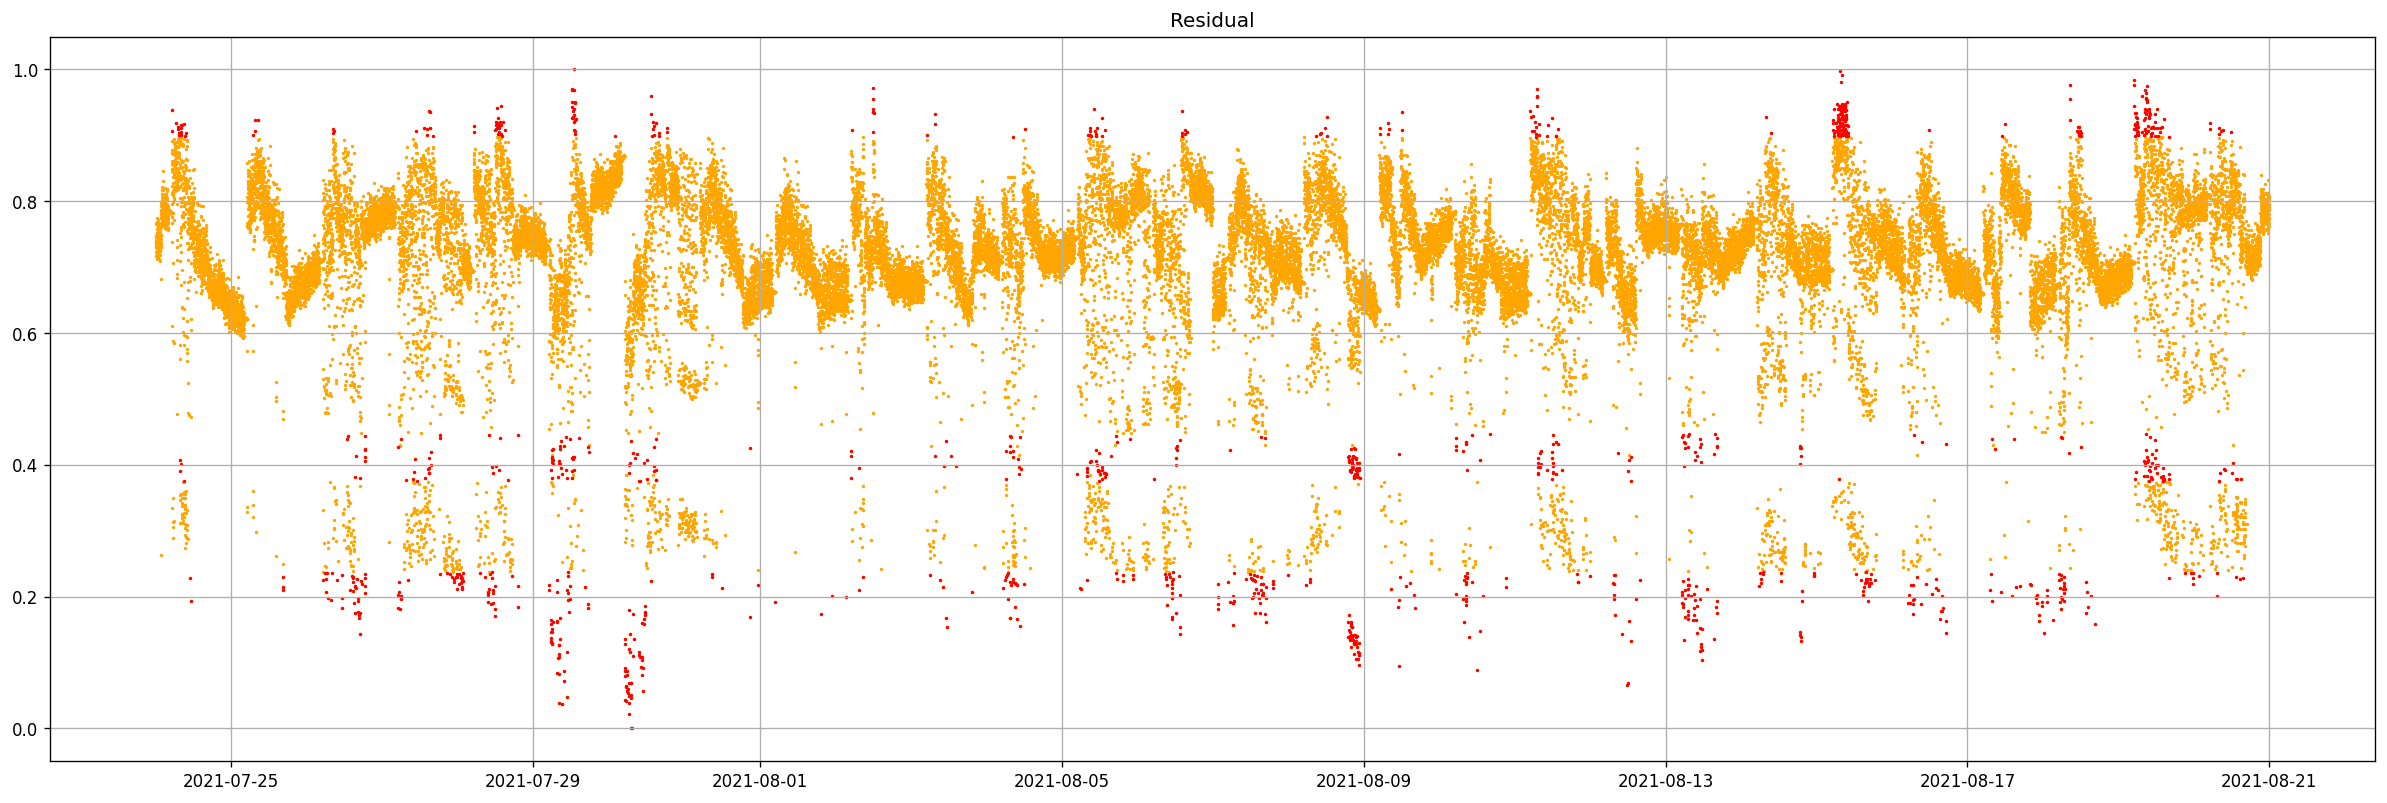

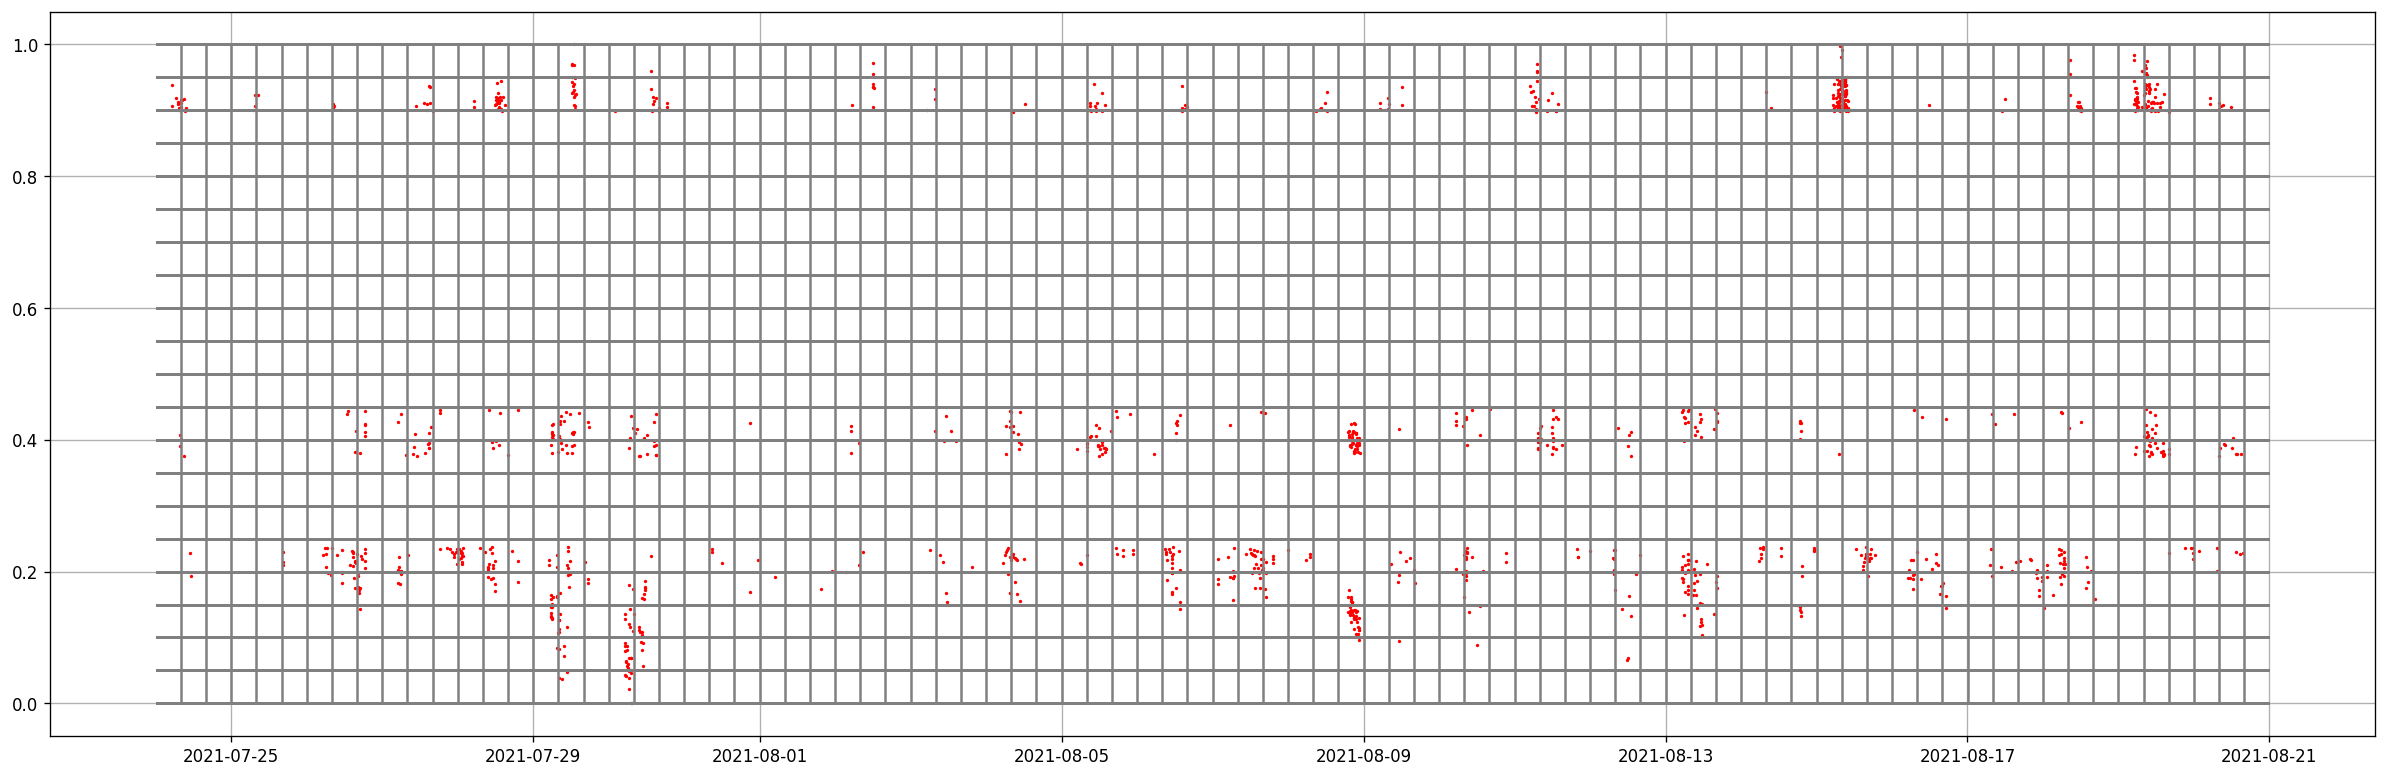

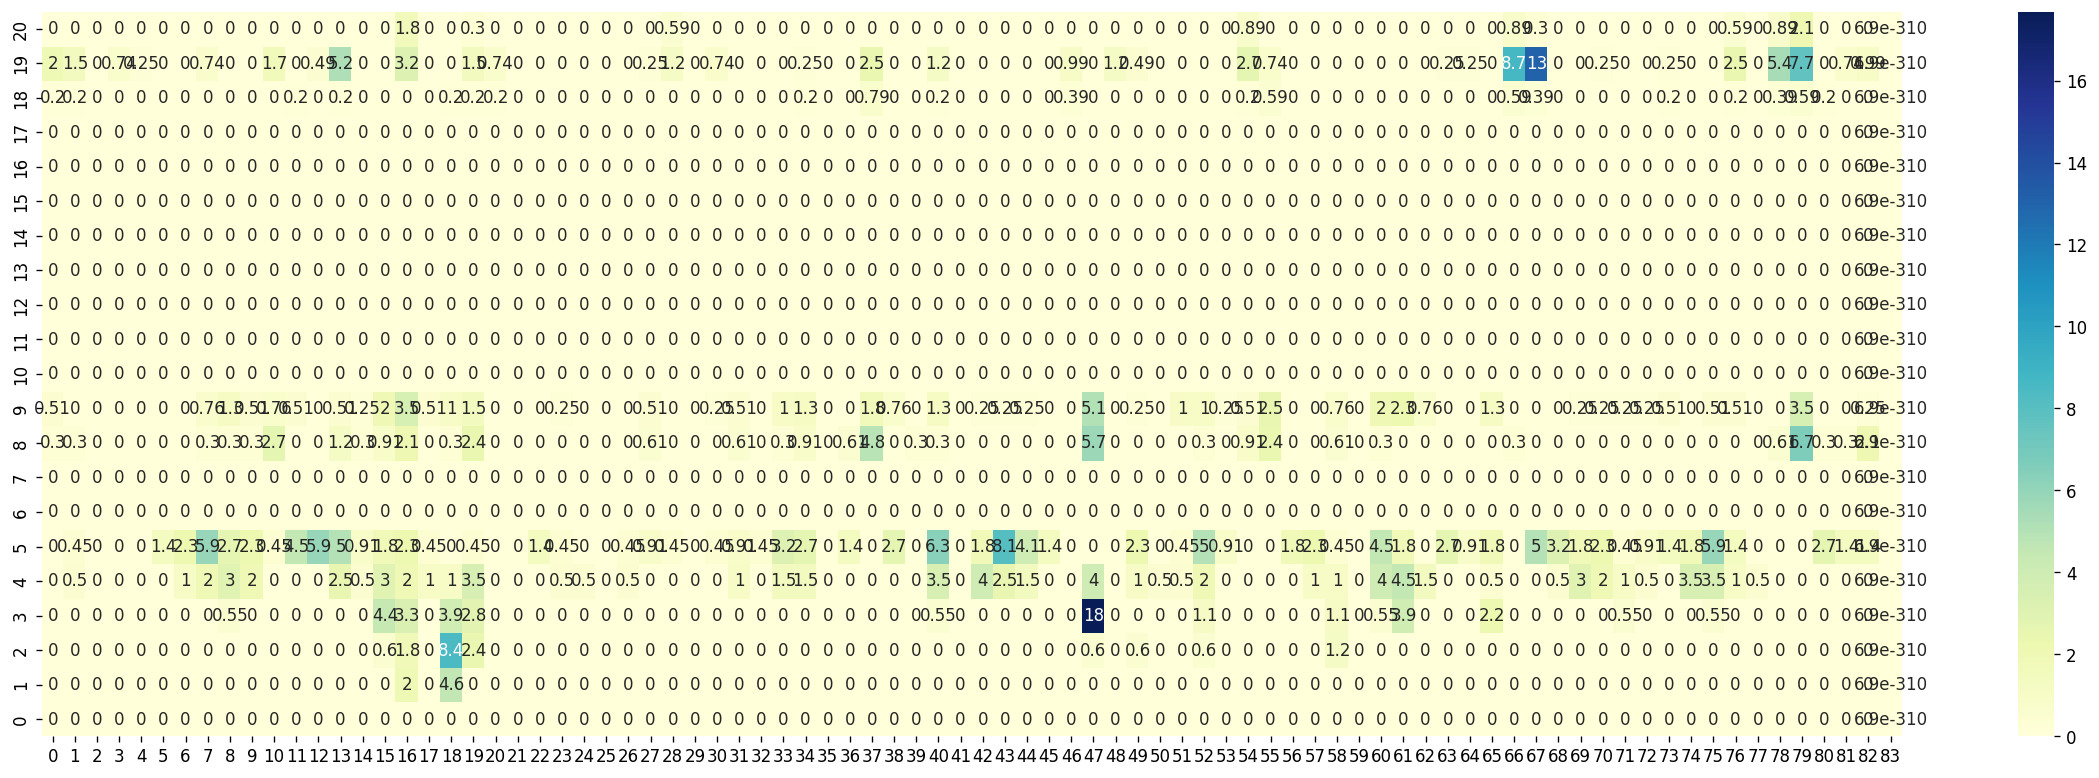

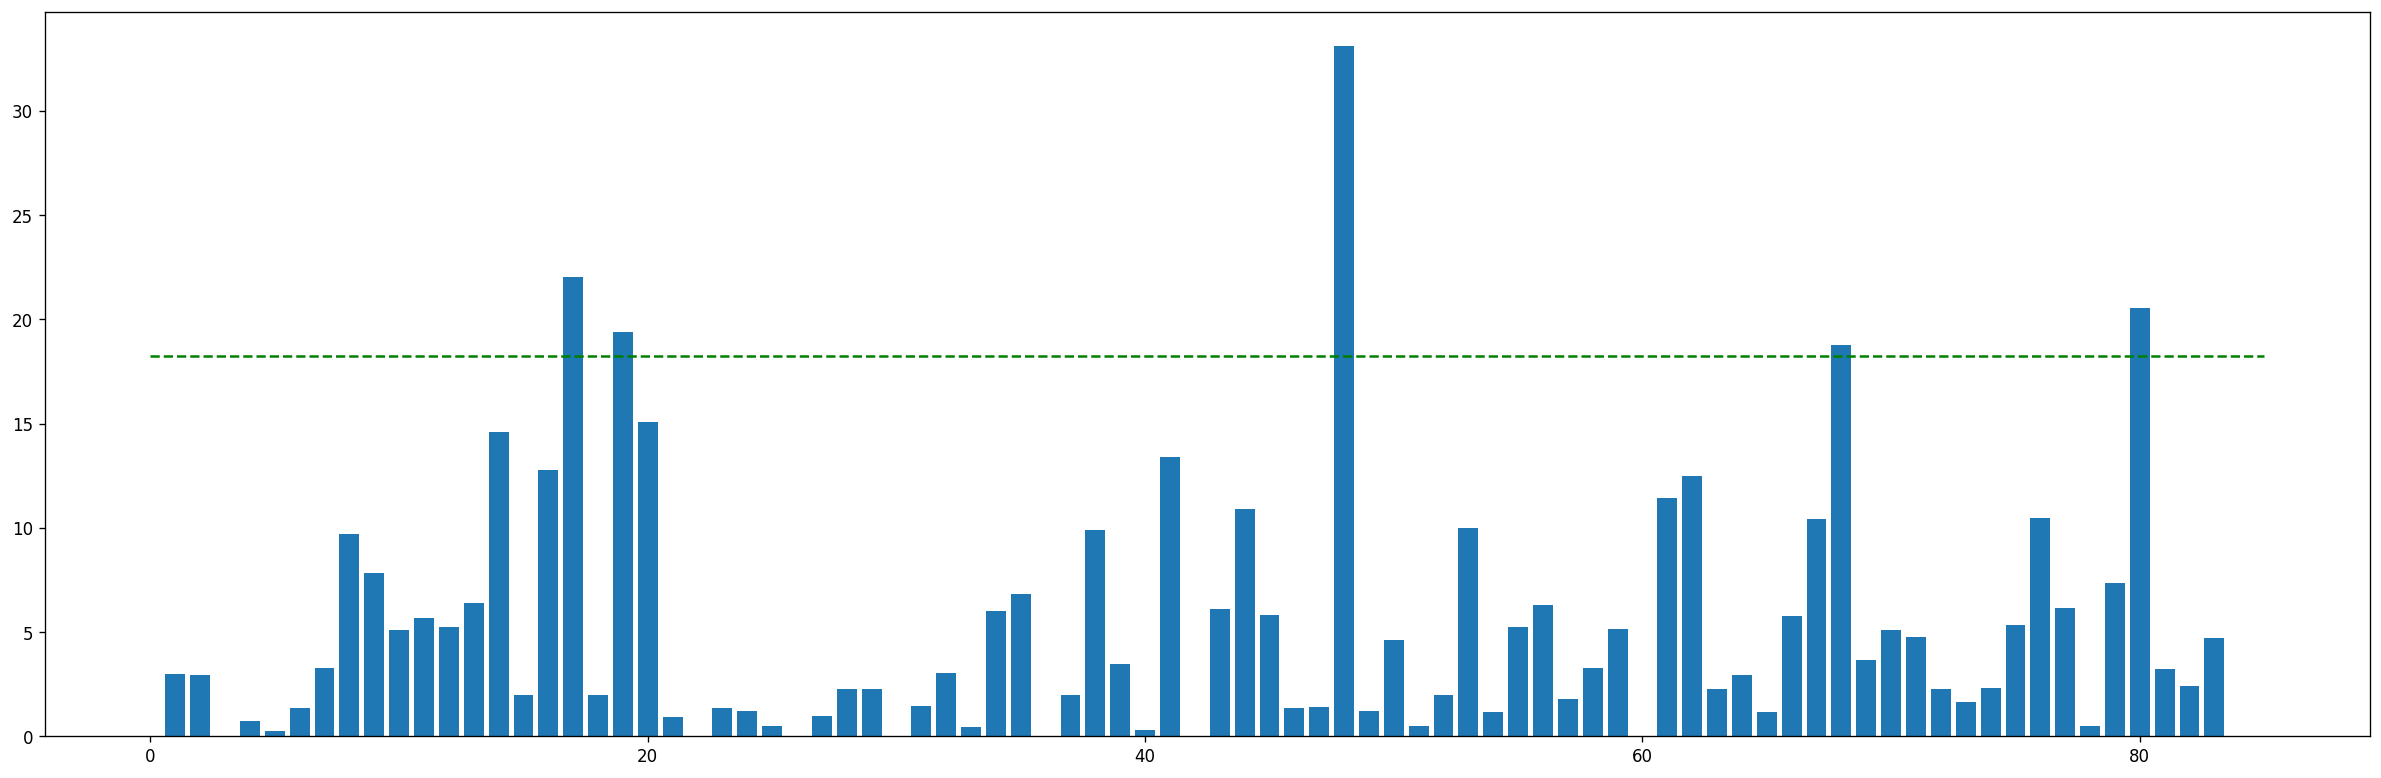

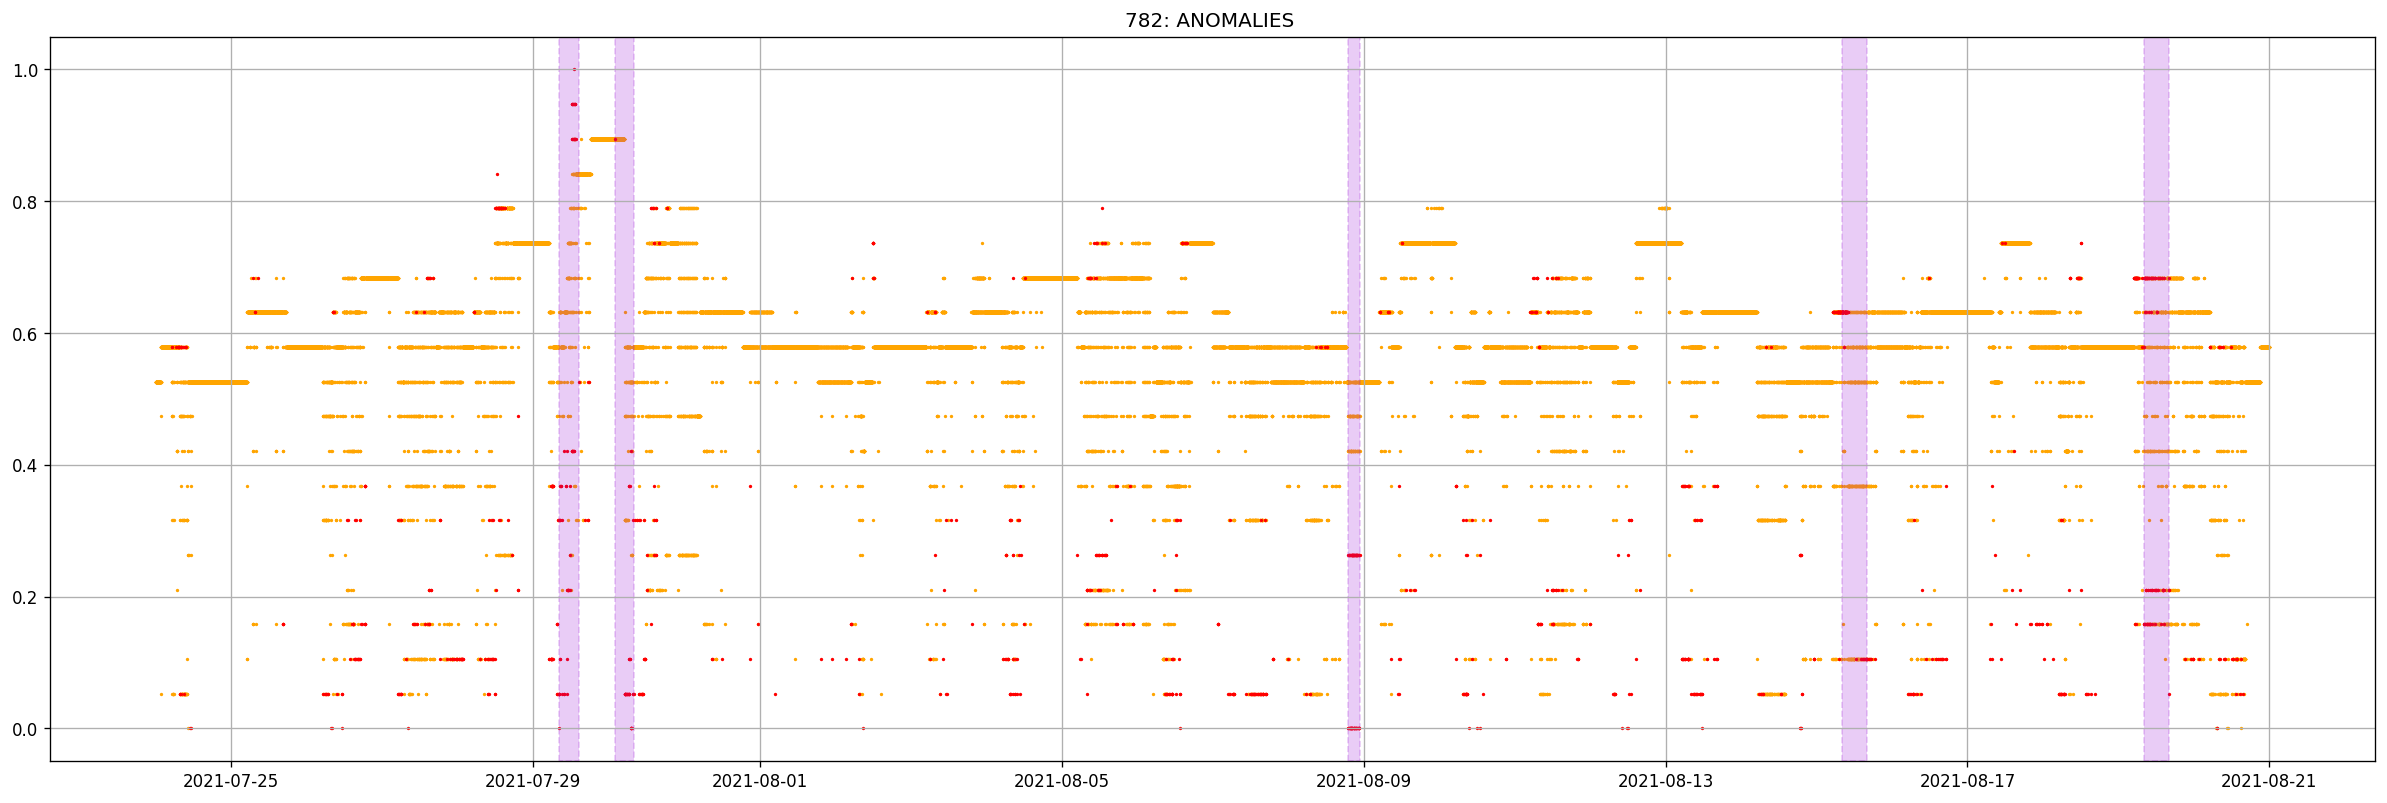

782 execution time :14.575655698776245 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

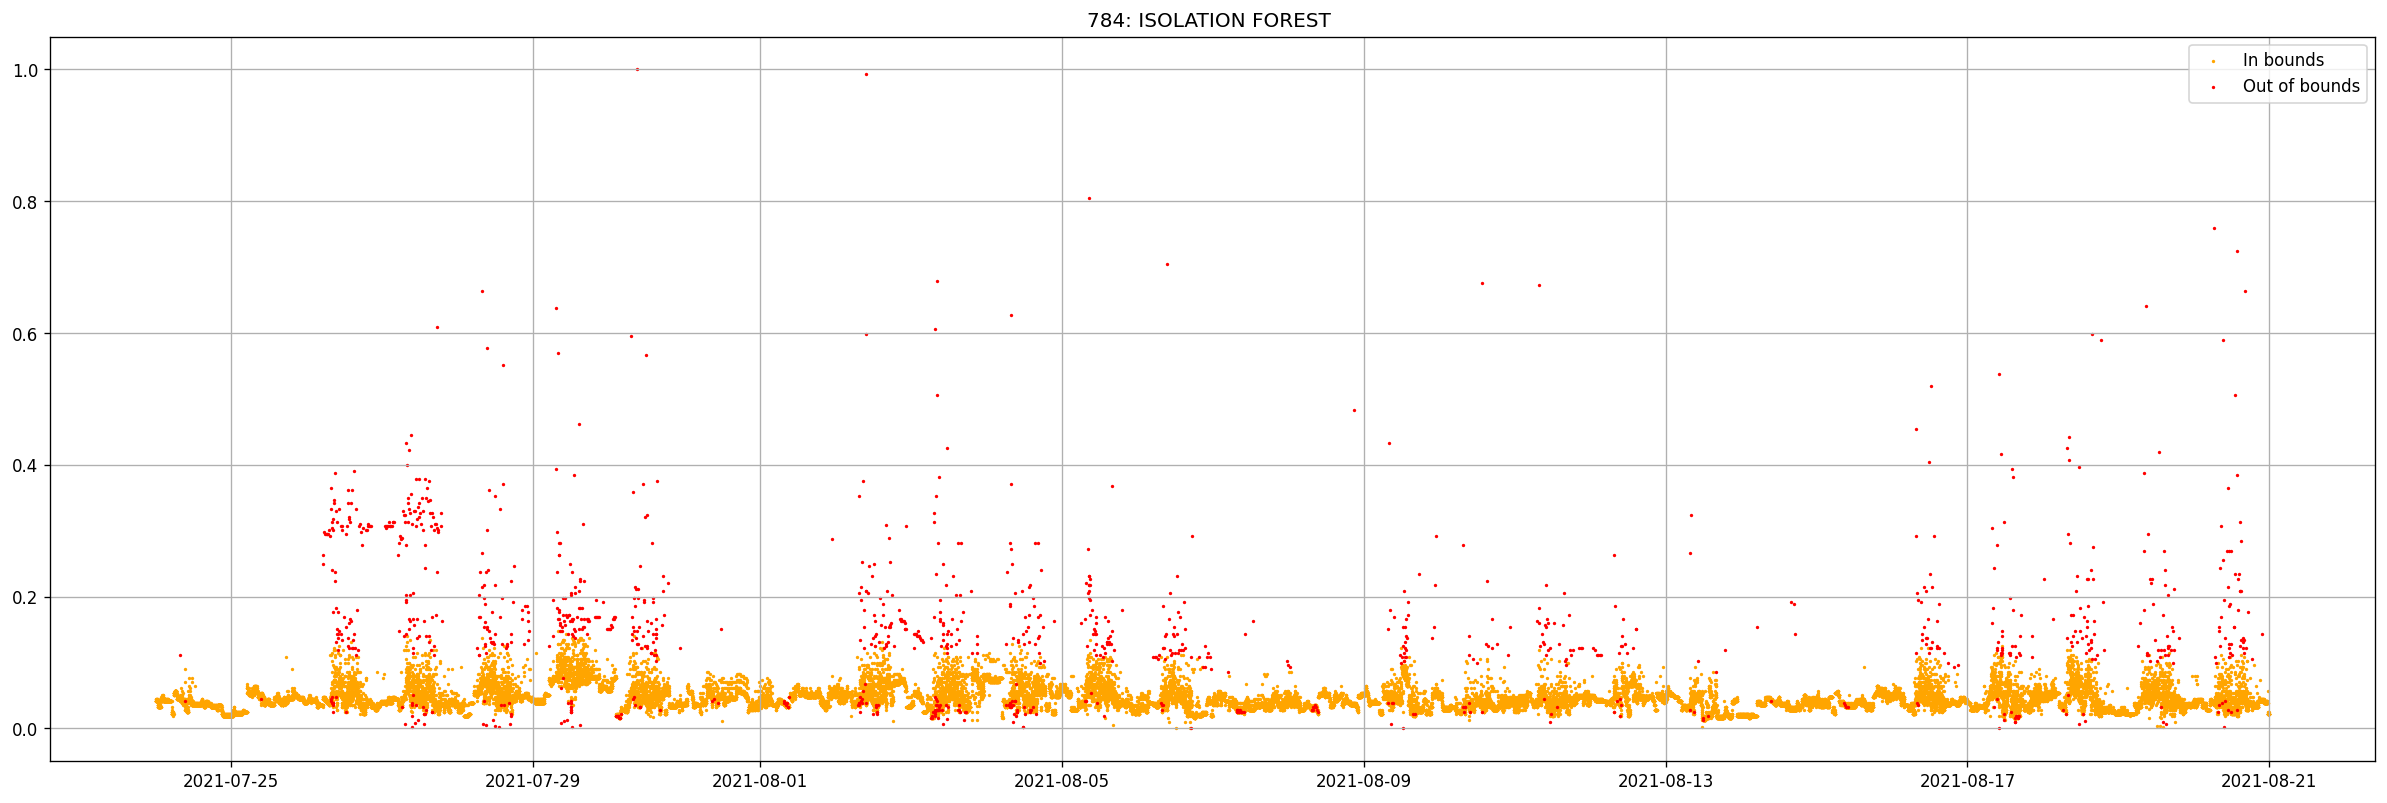

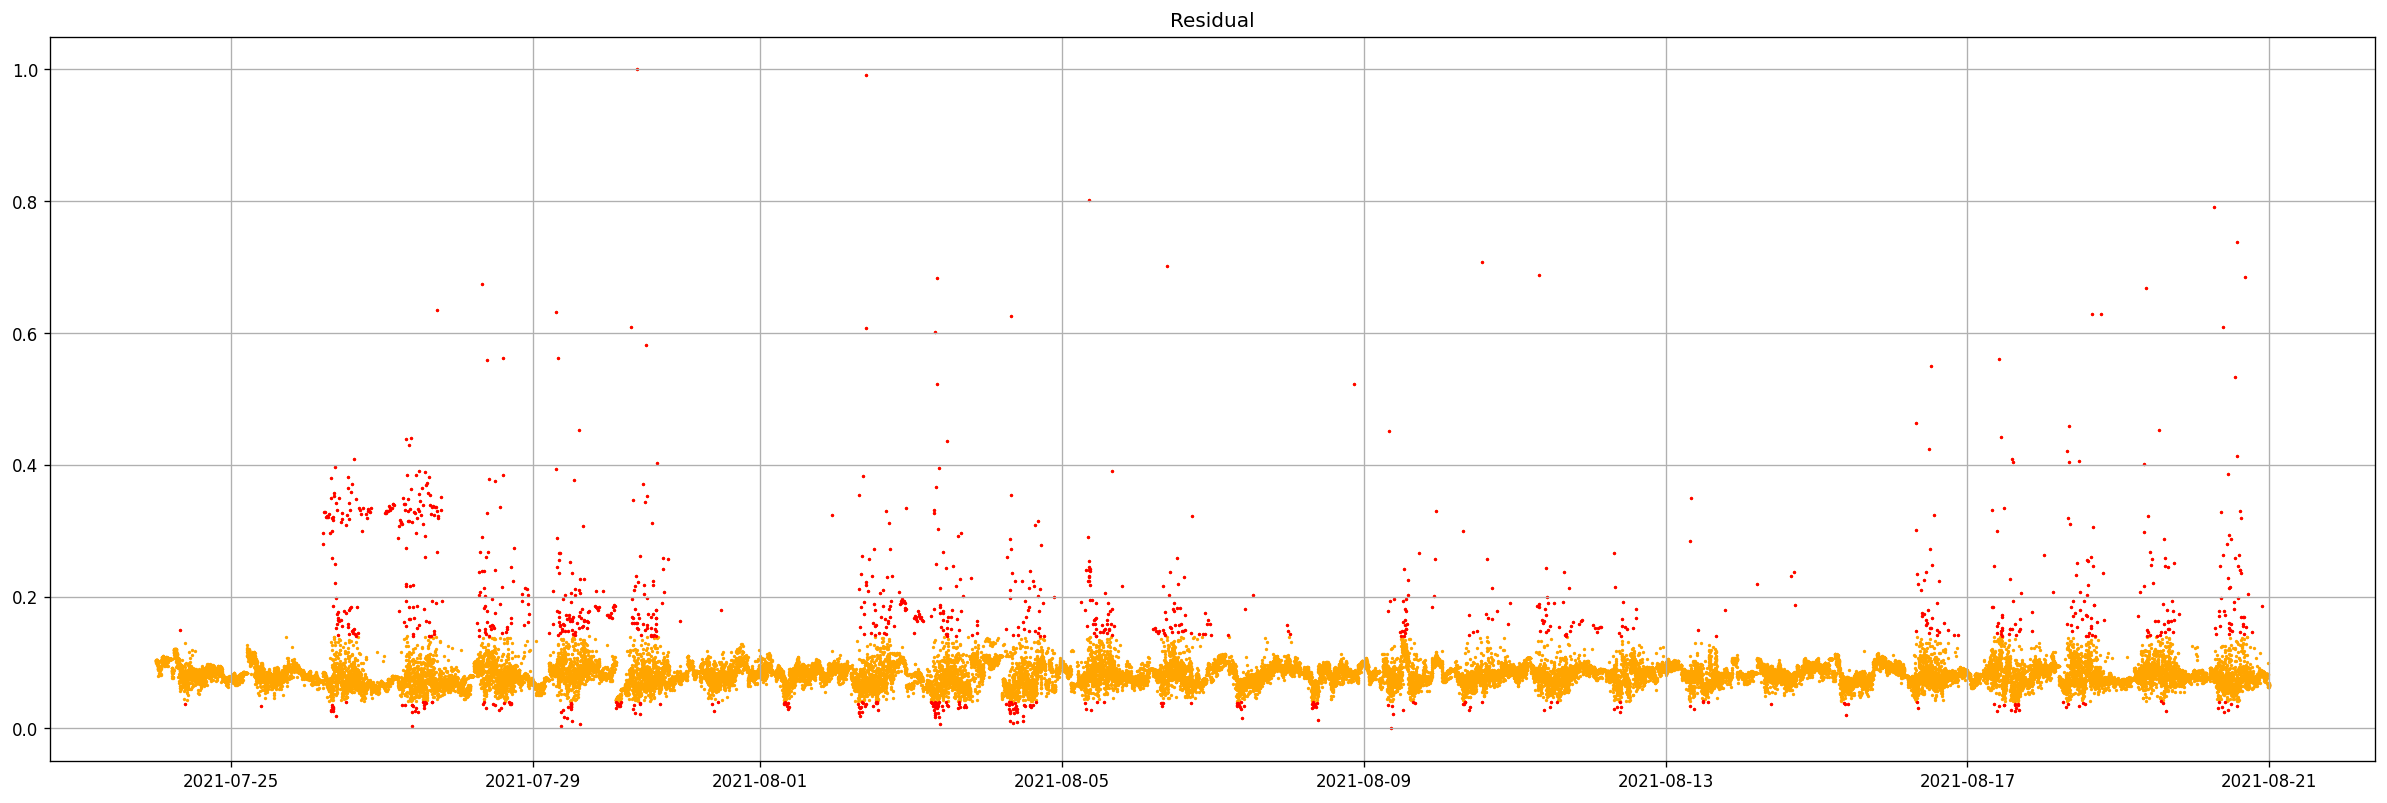

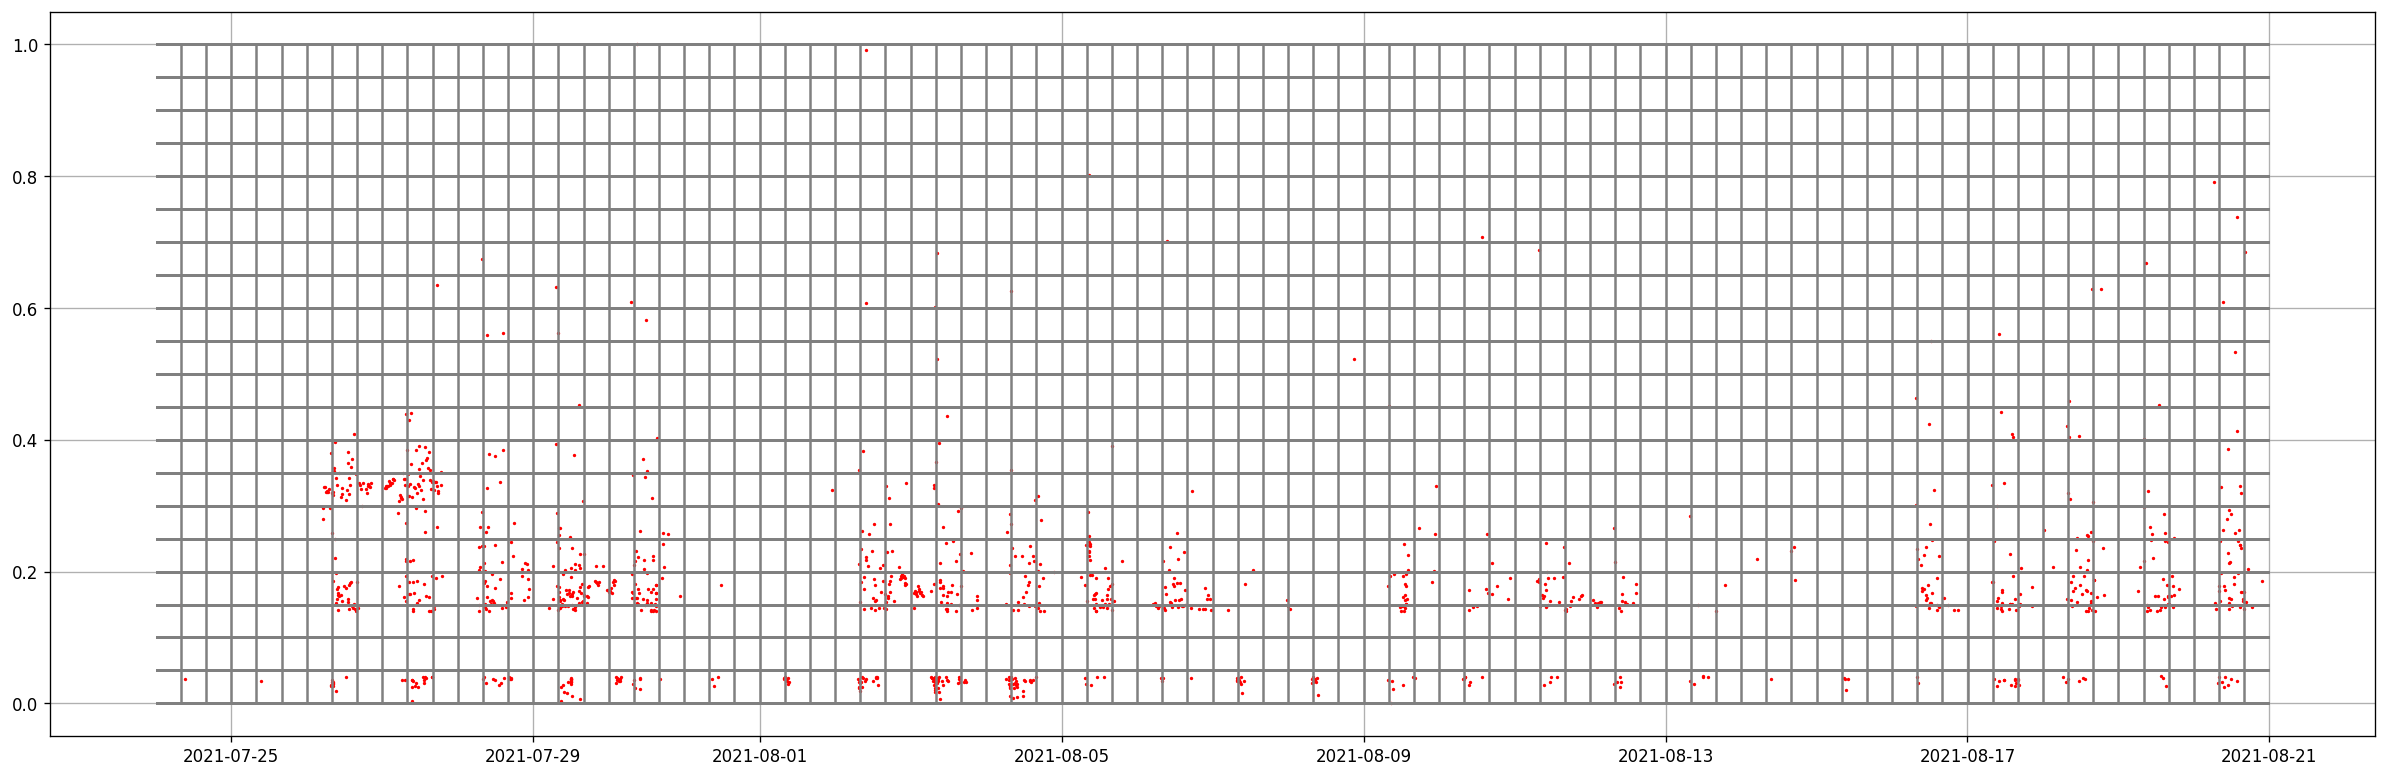

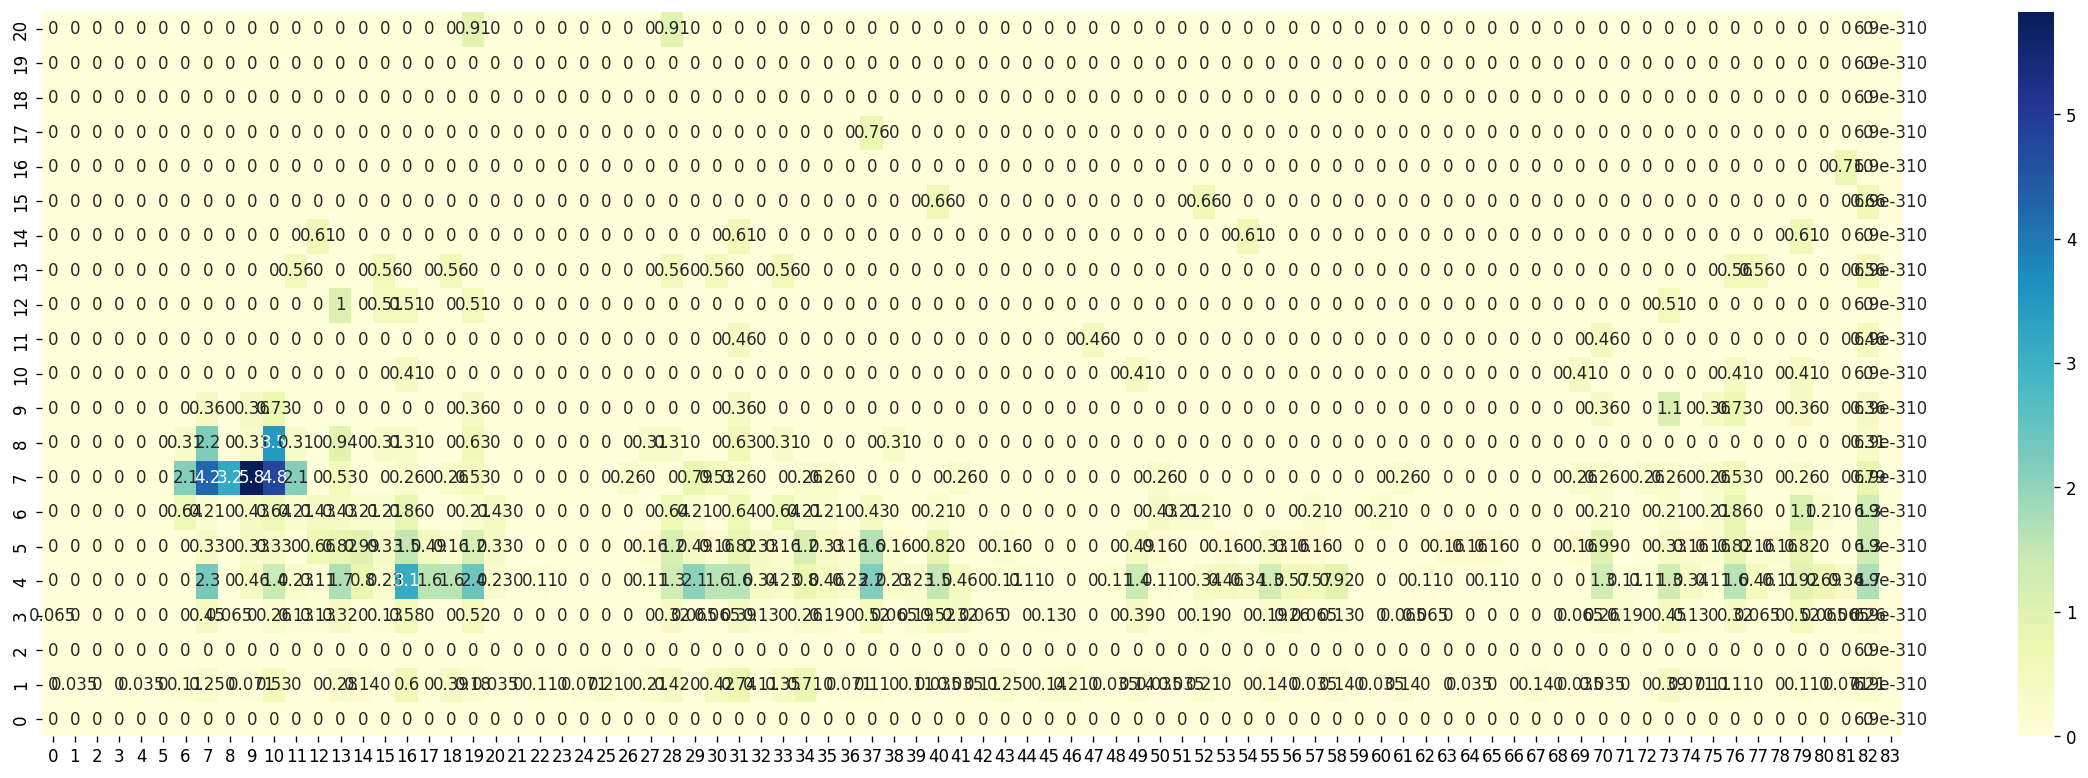

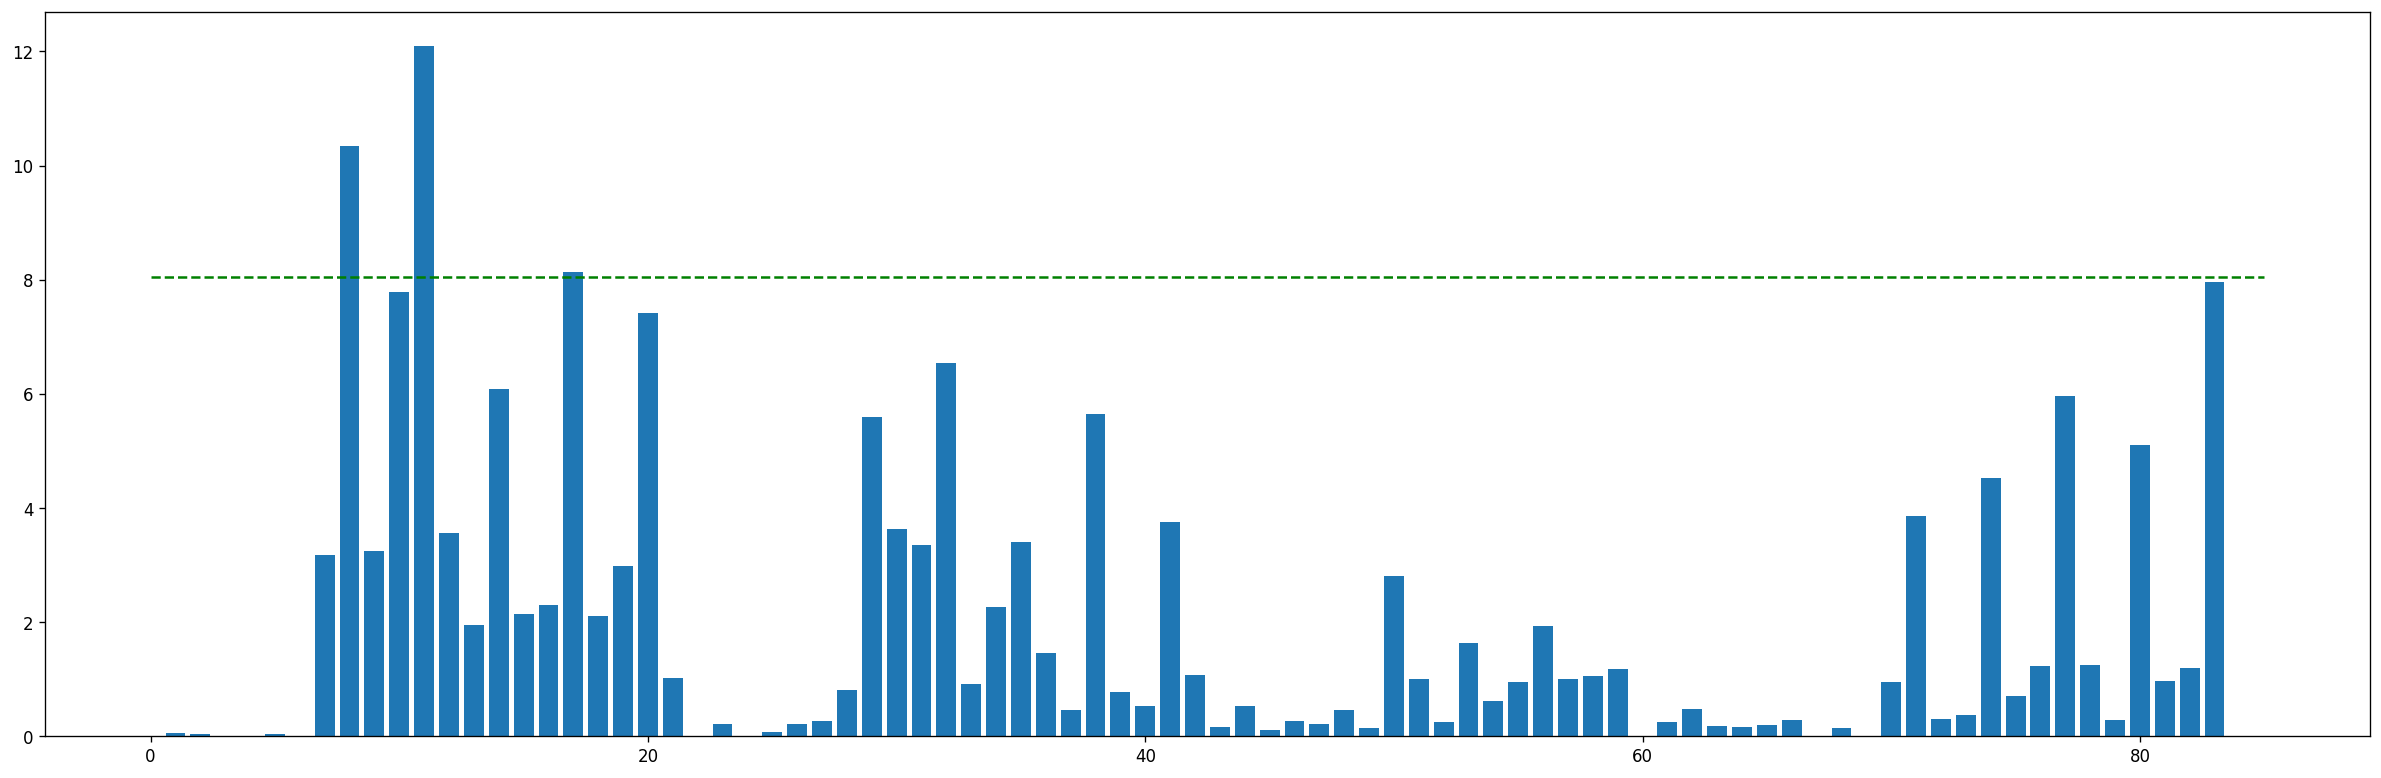

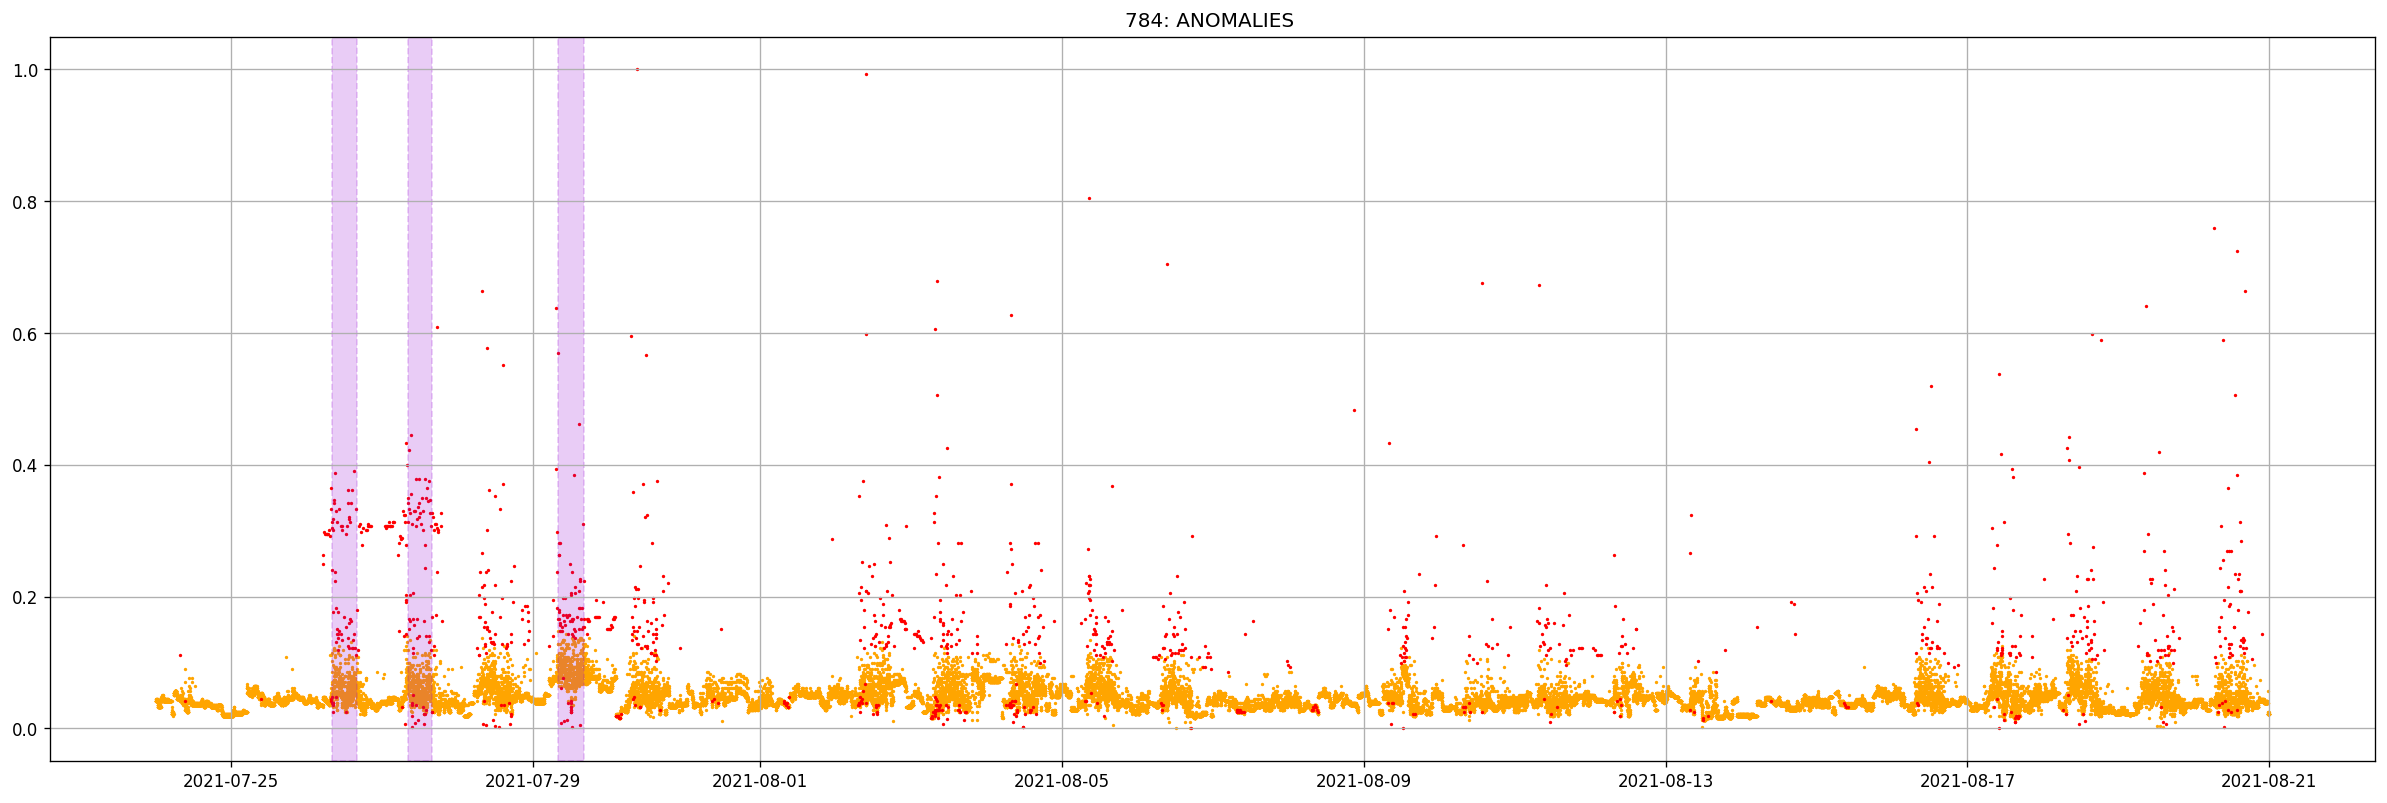

784 execution time :14.380075216293335 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

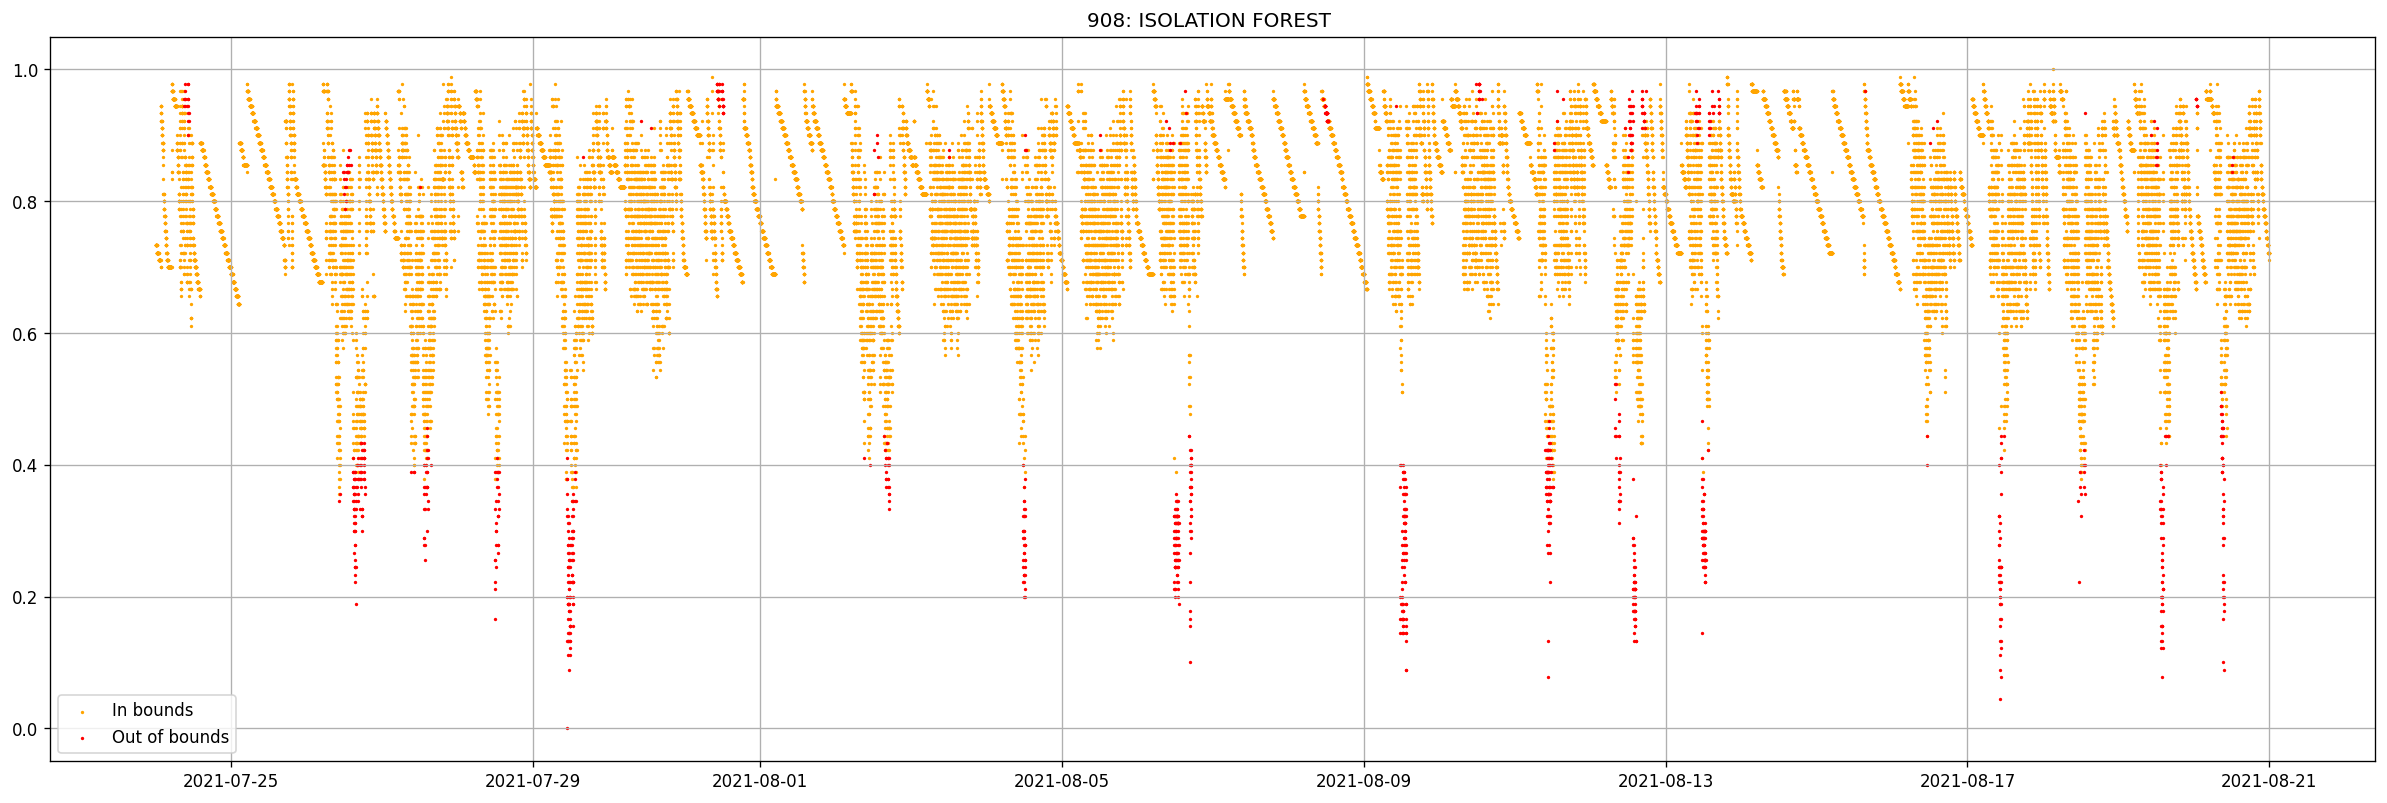

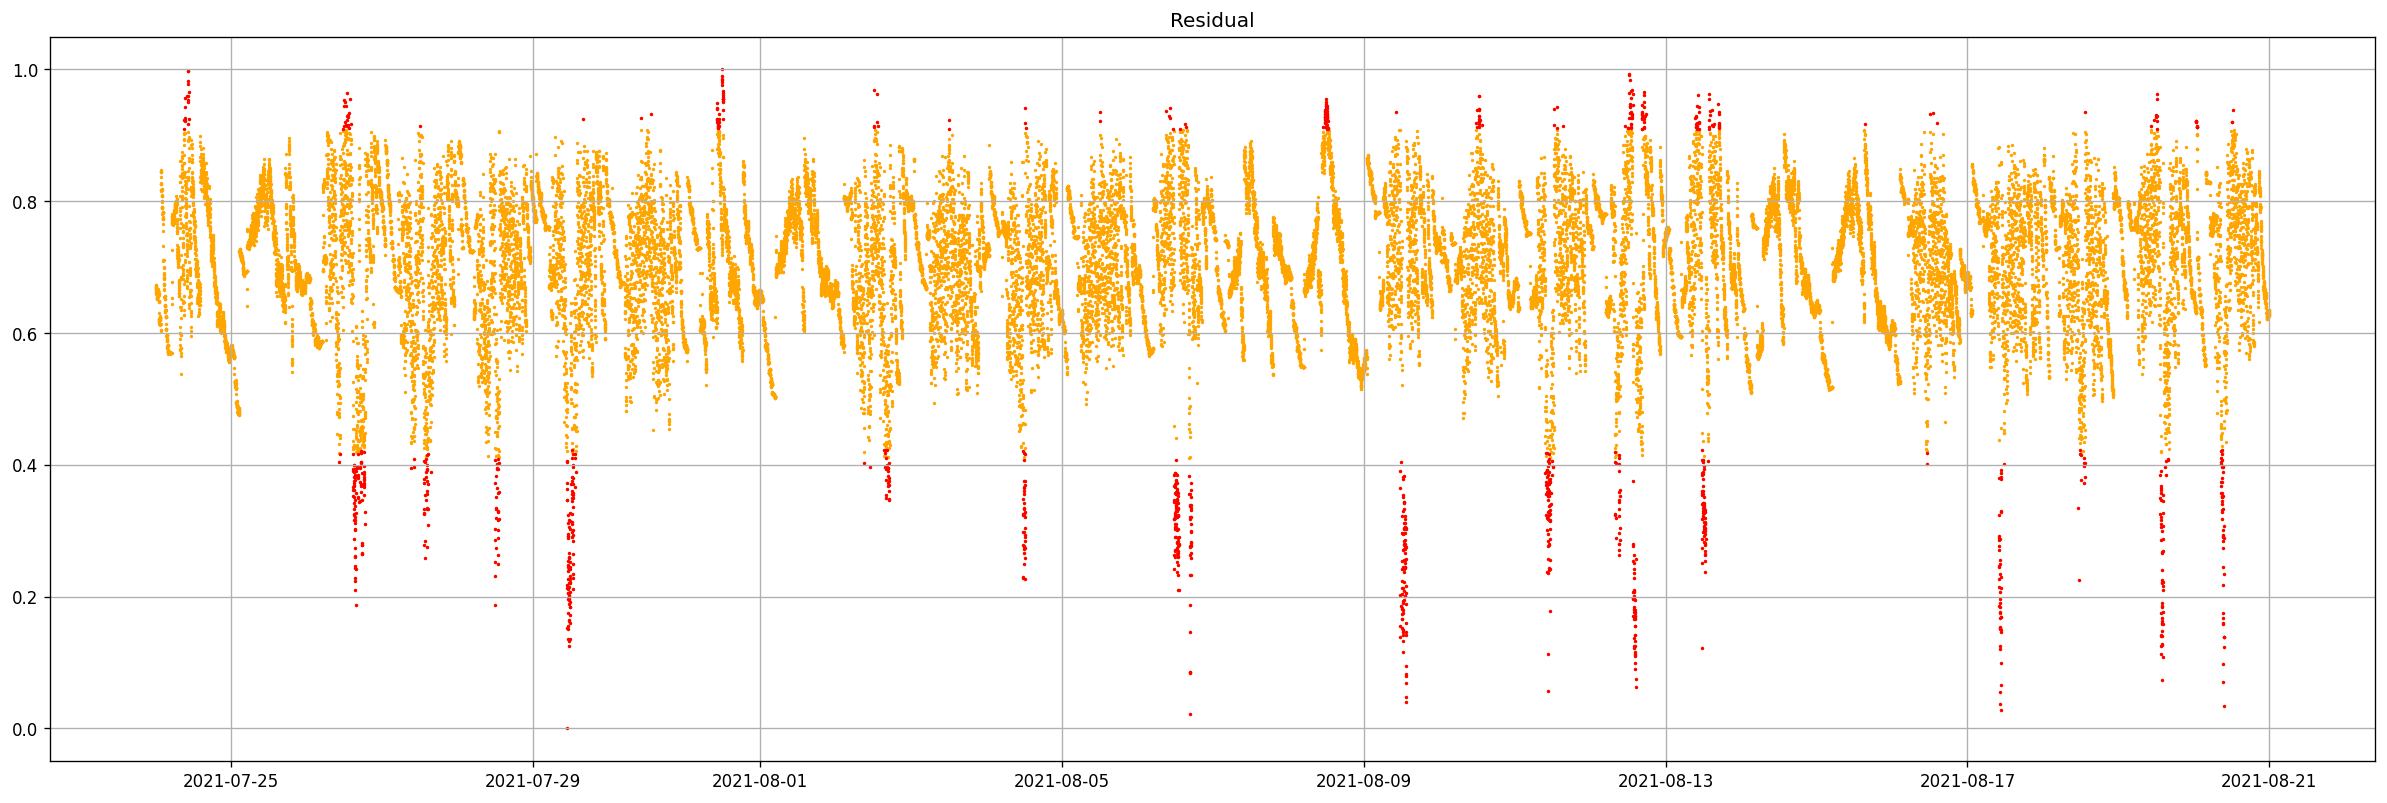

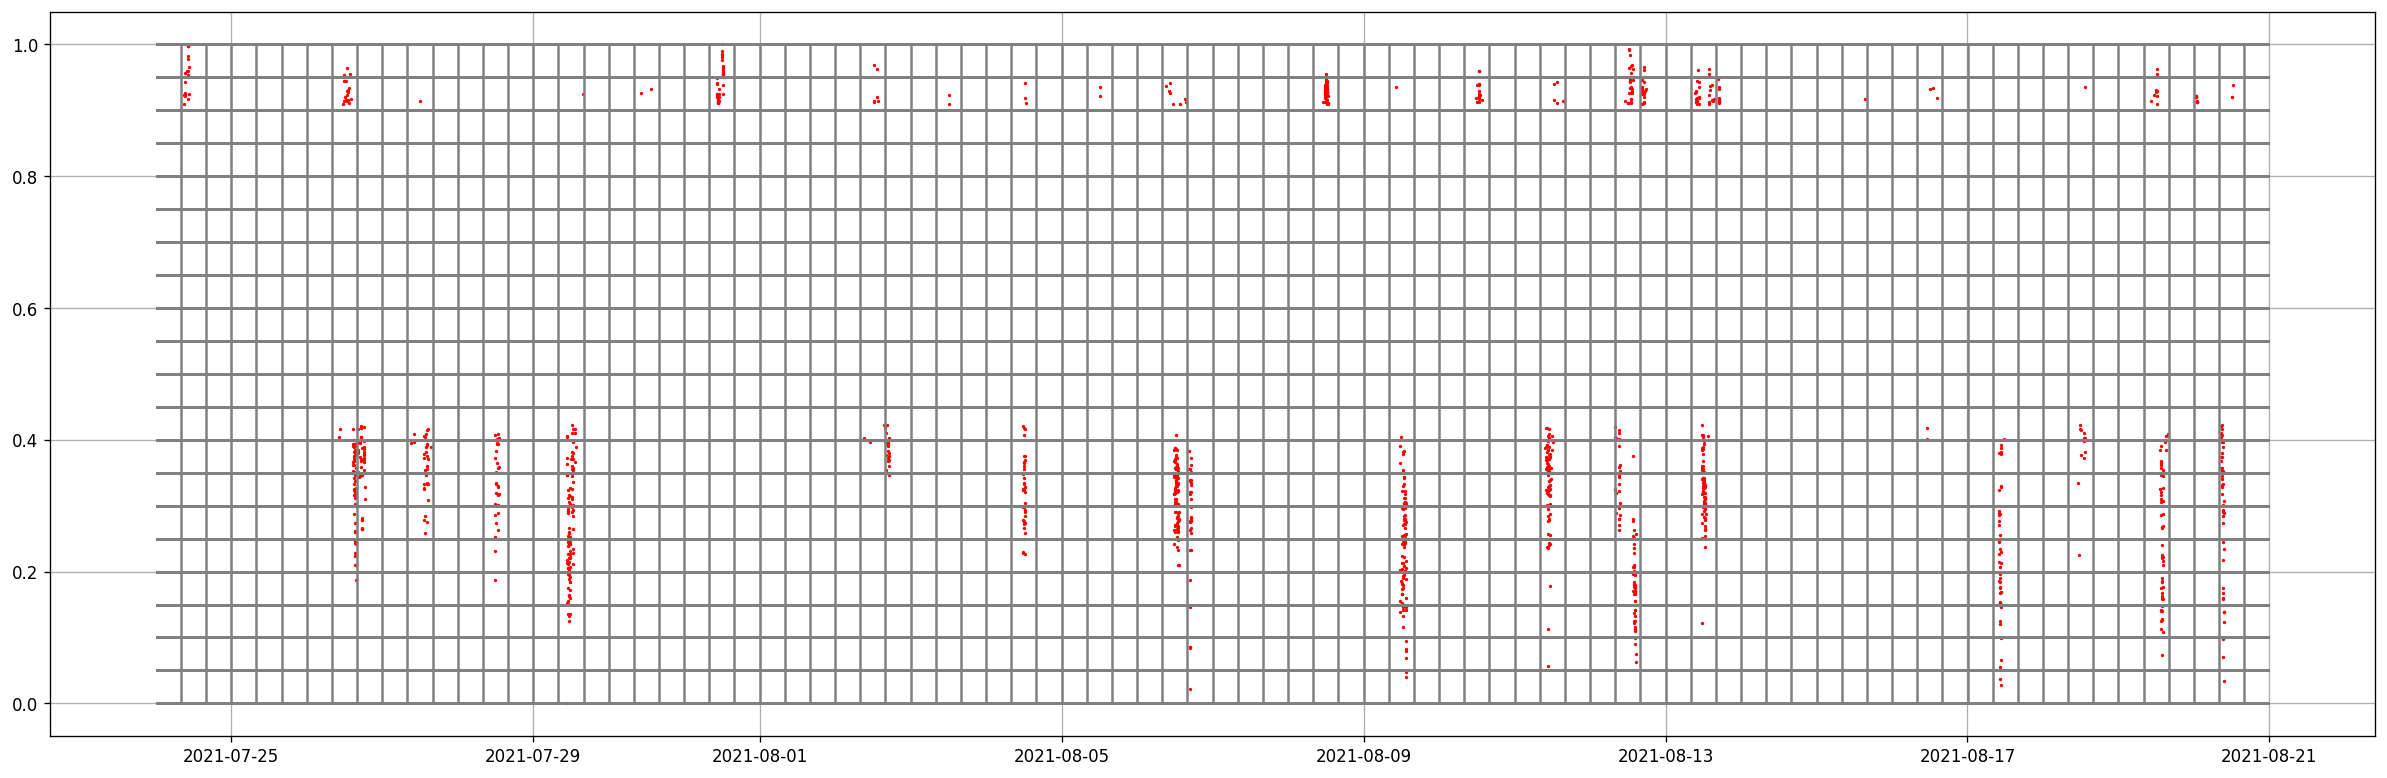

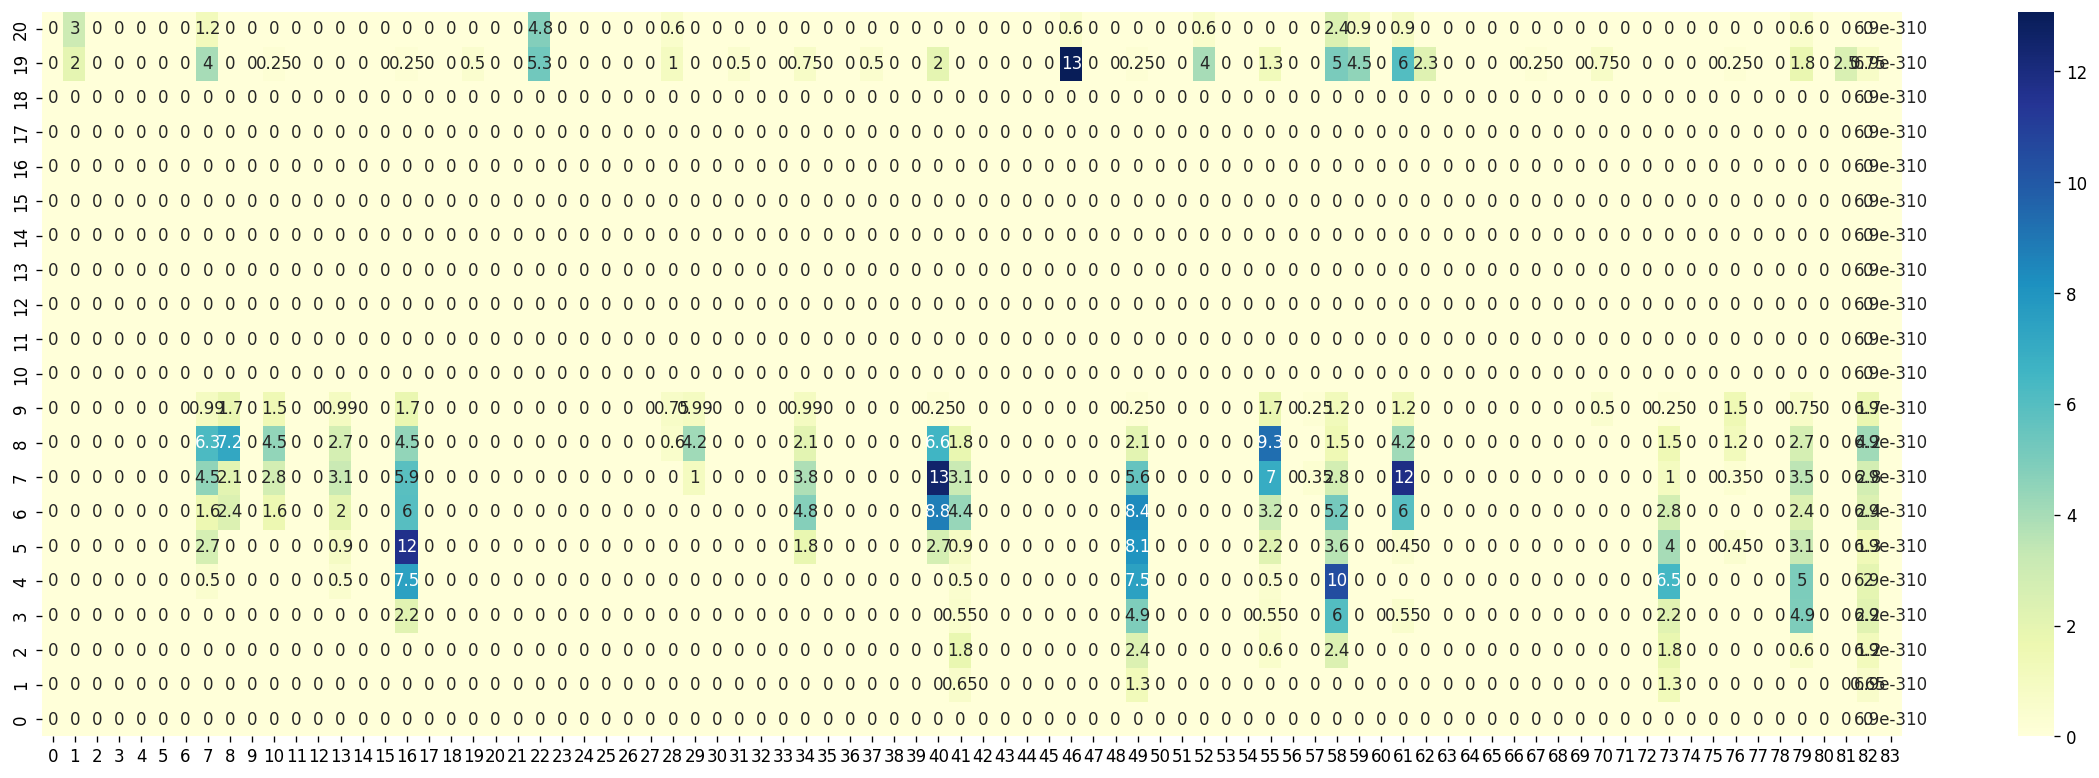

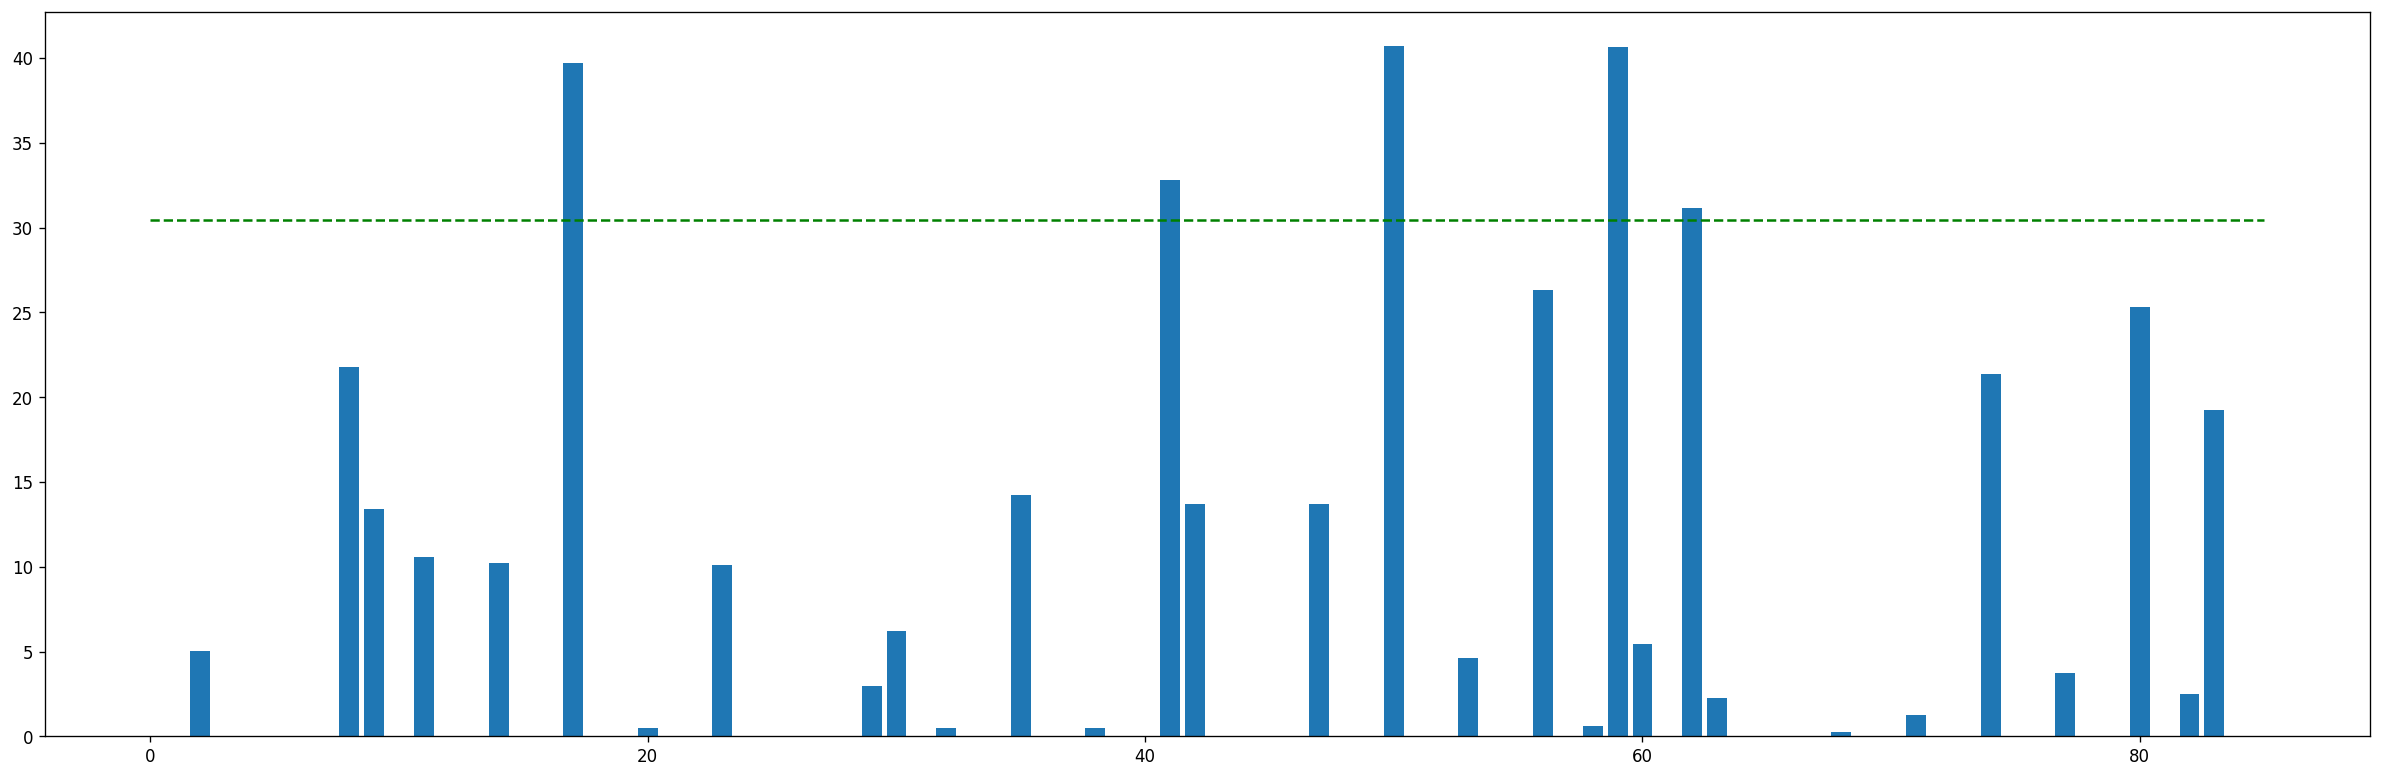

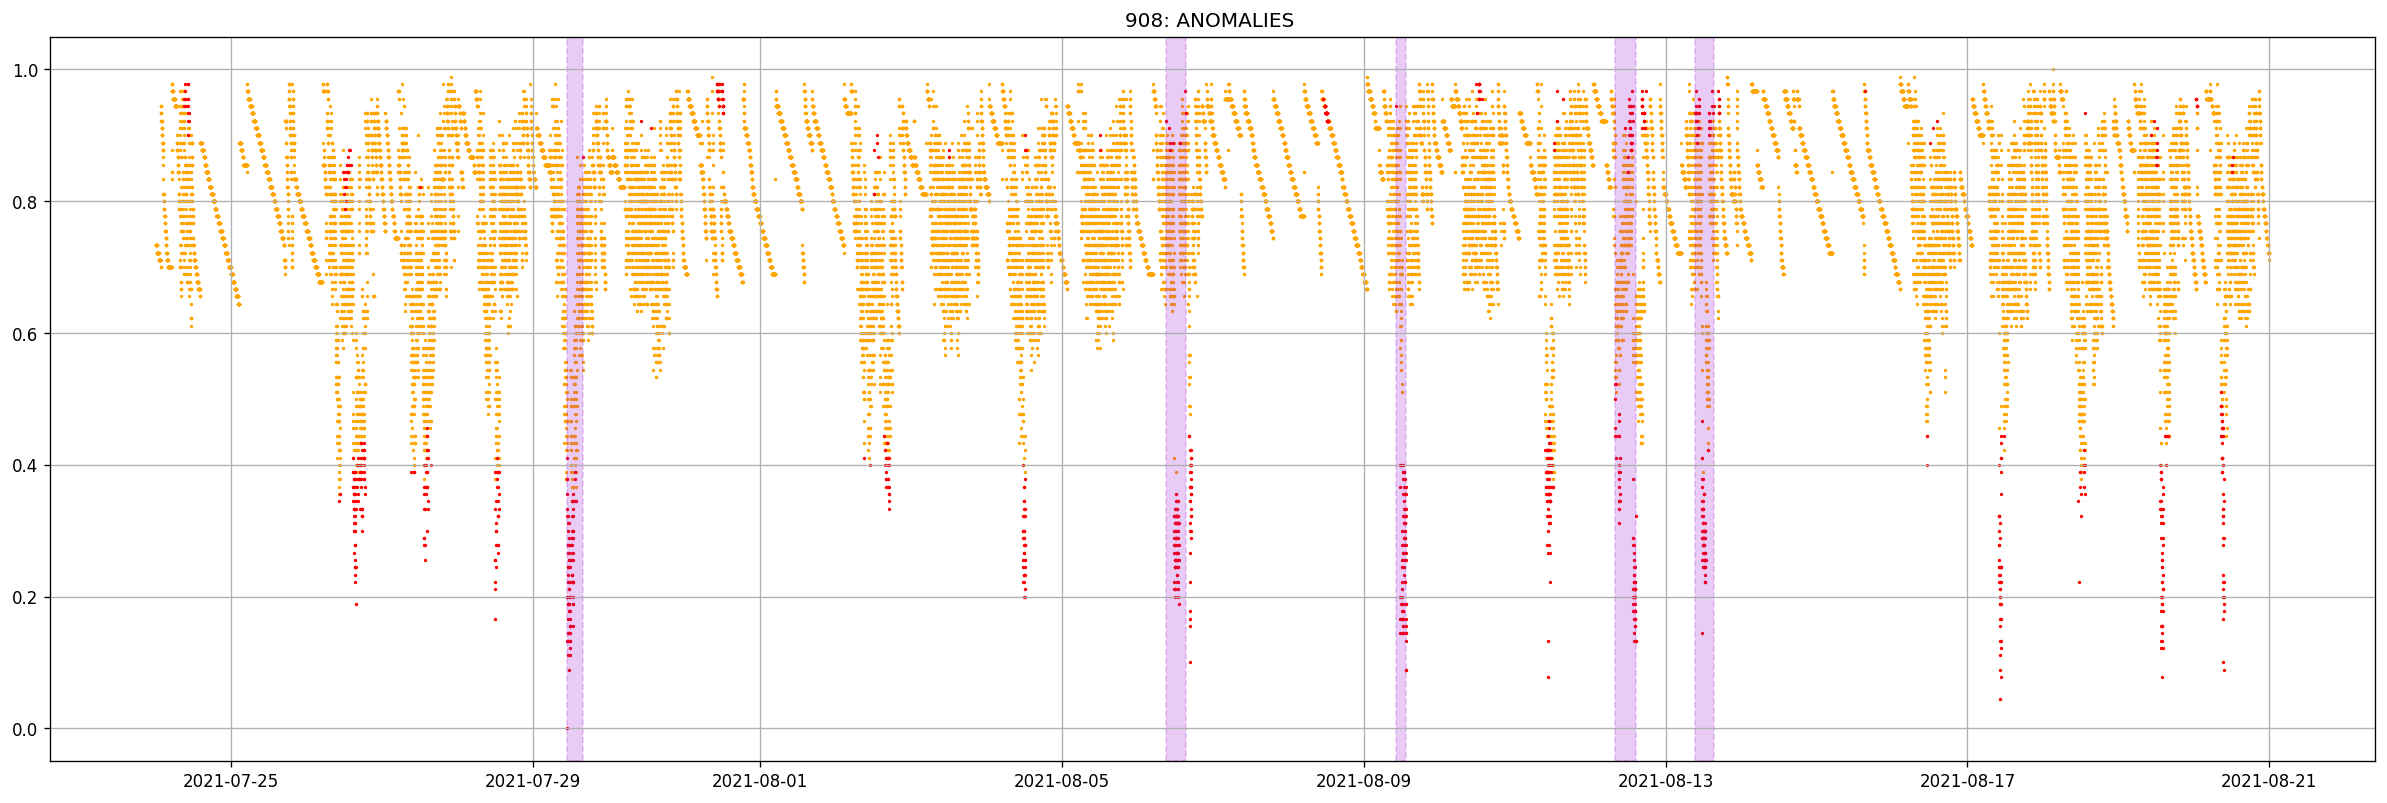

908 execution time :14.929963111877441 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

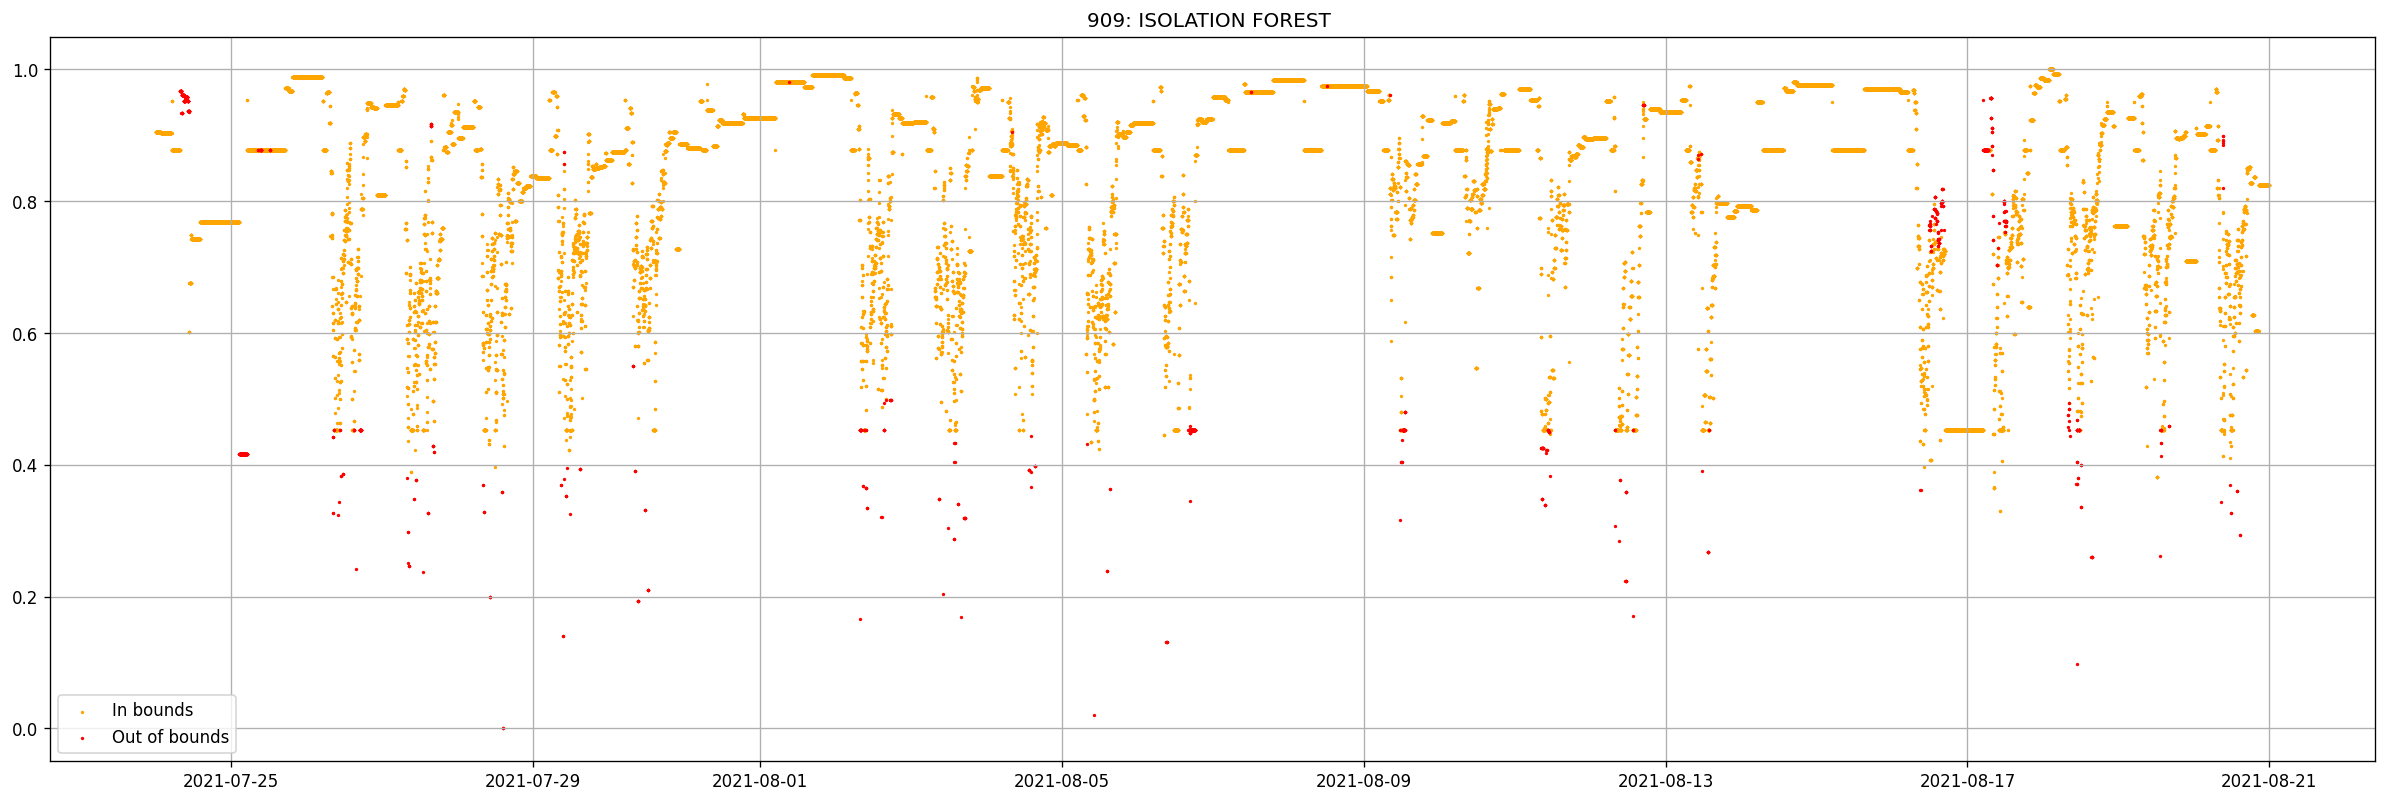

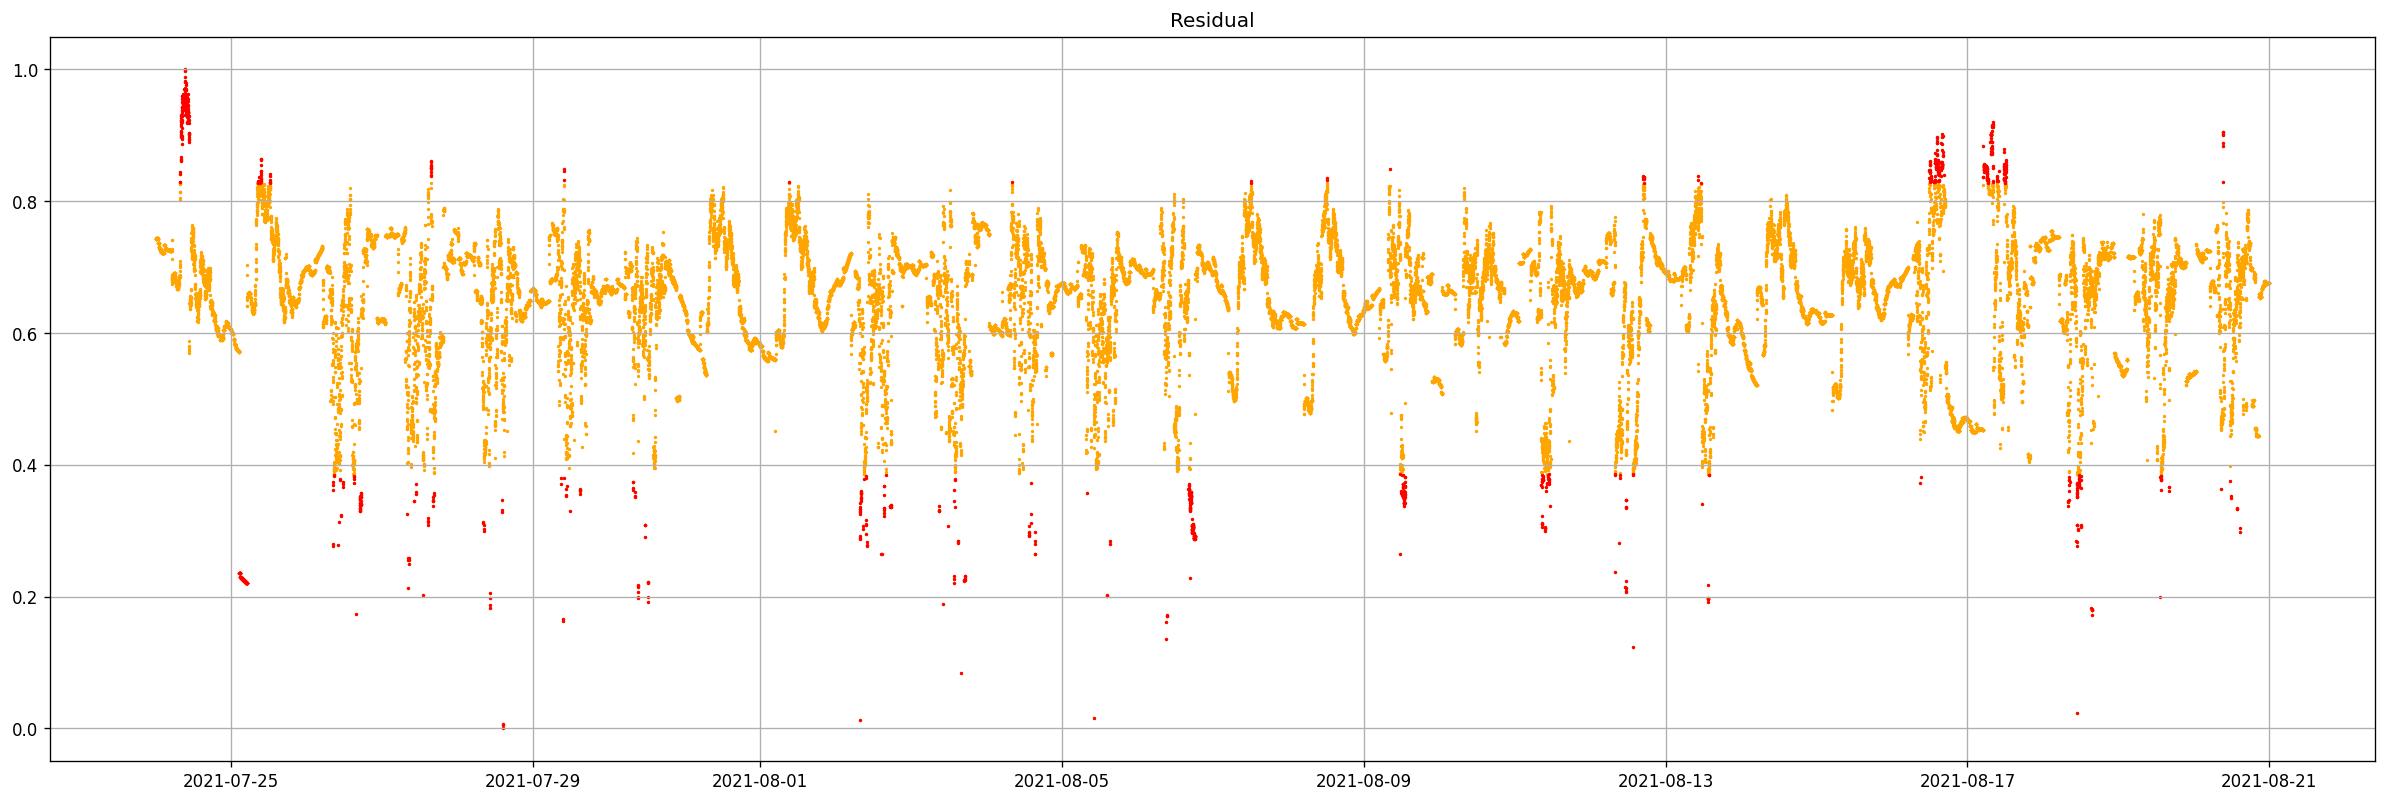

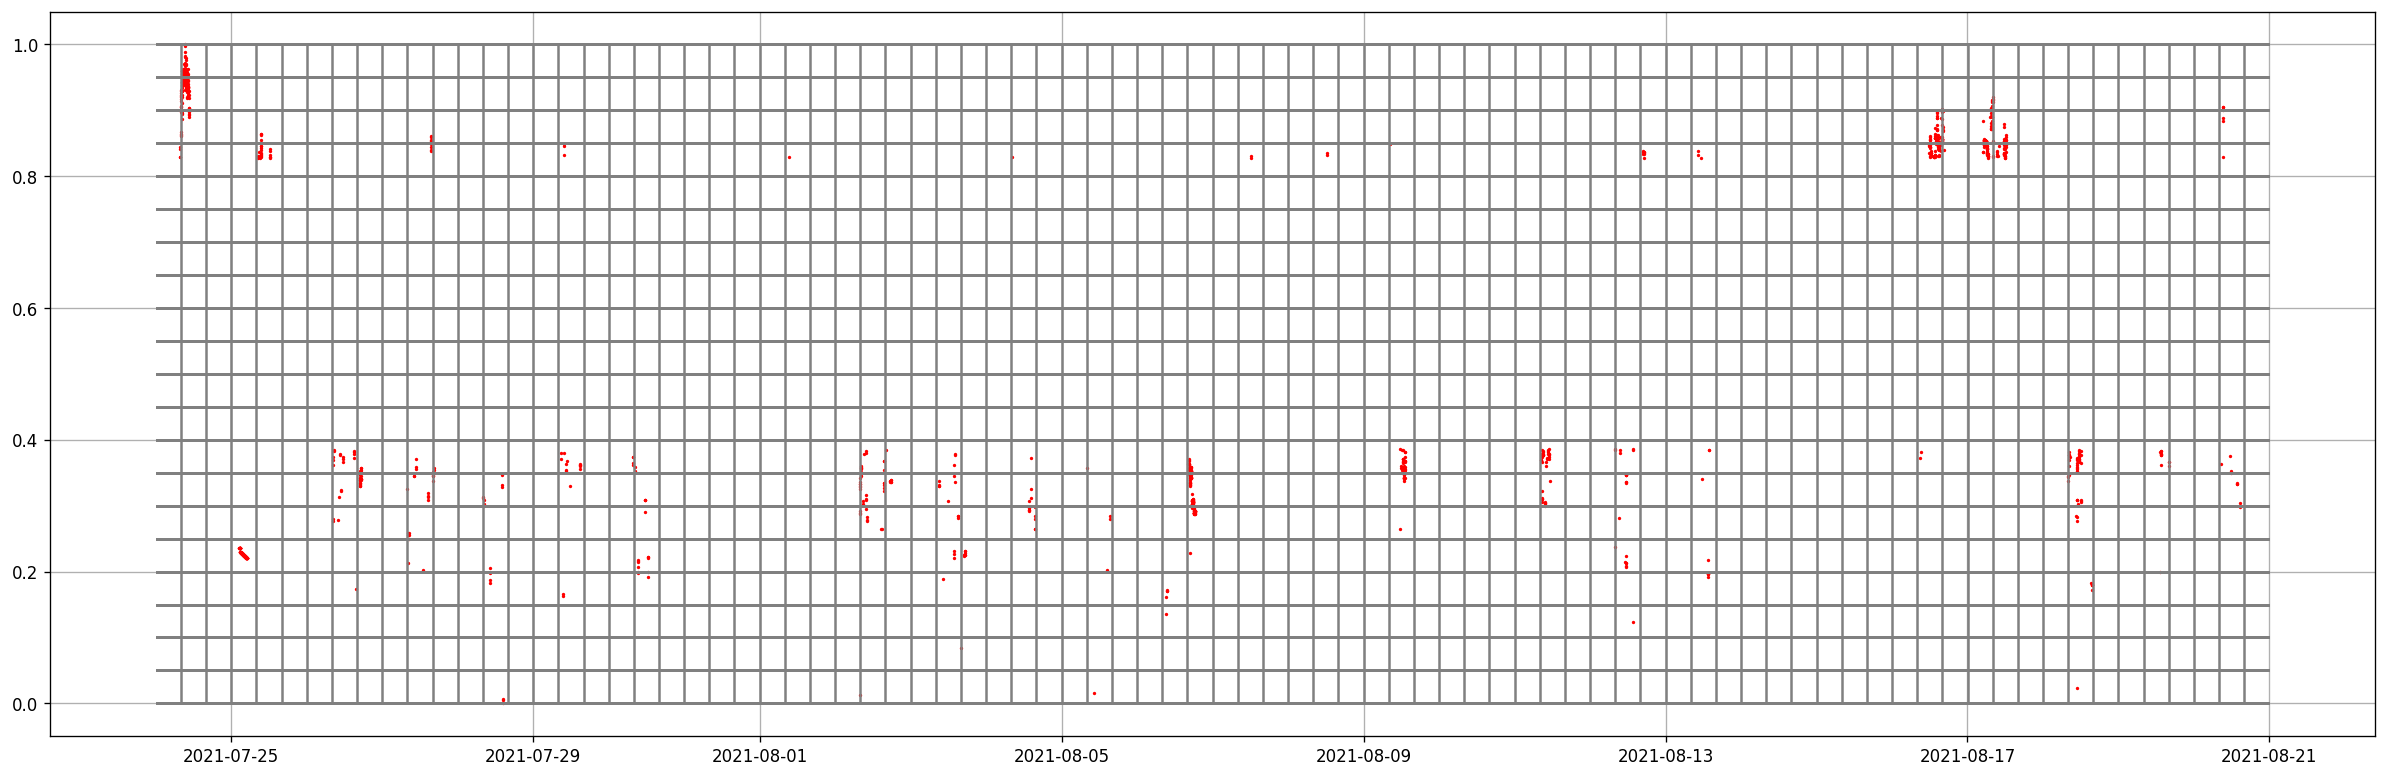

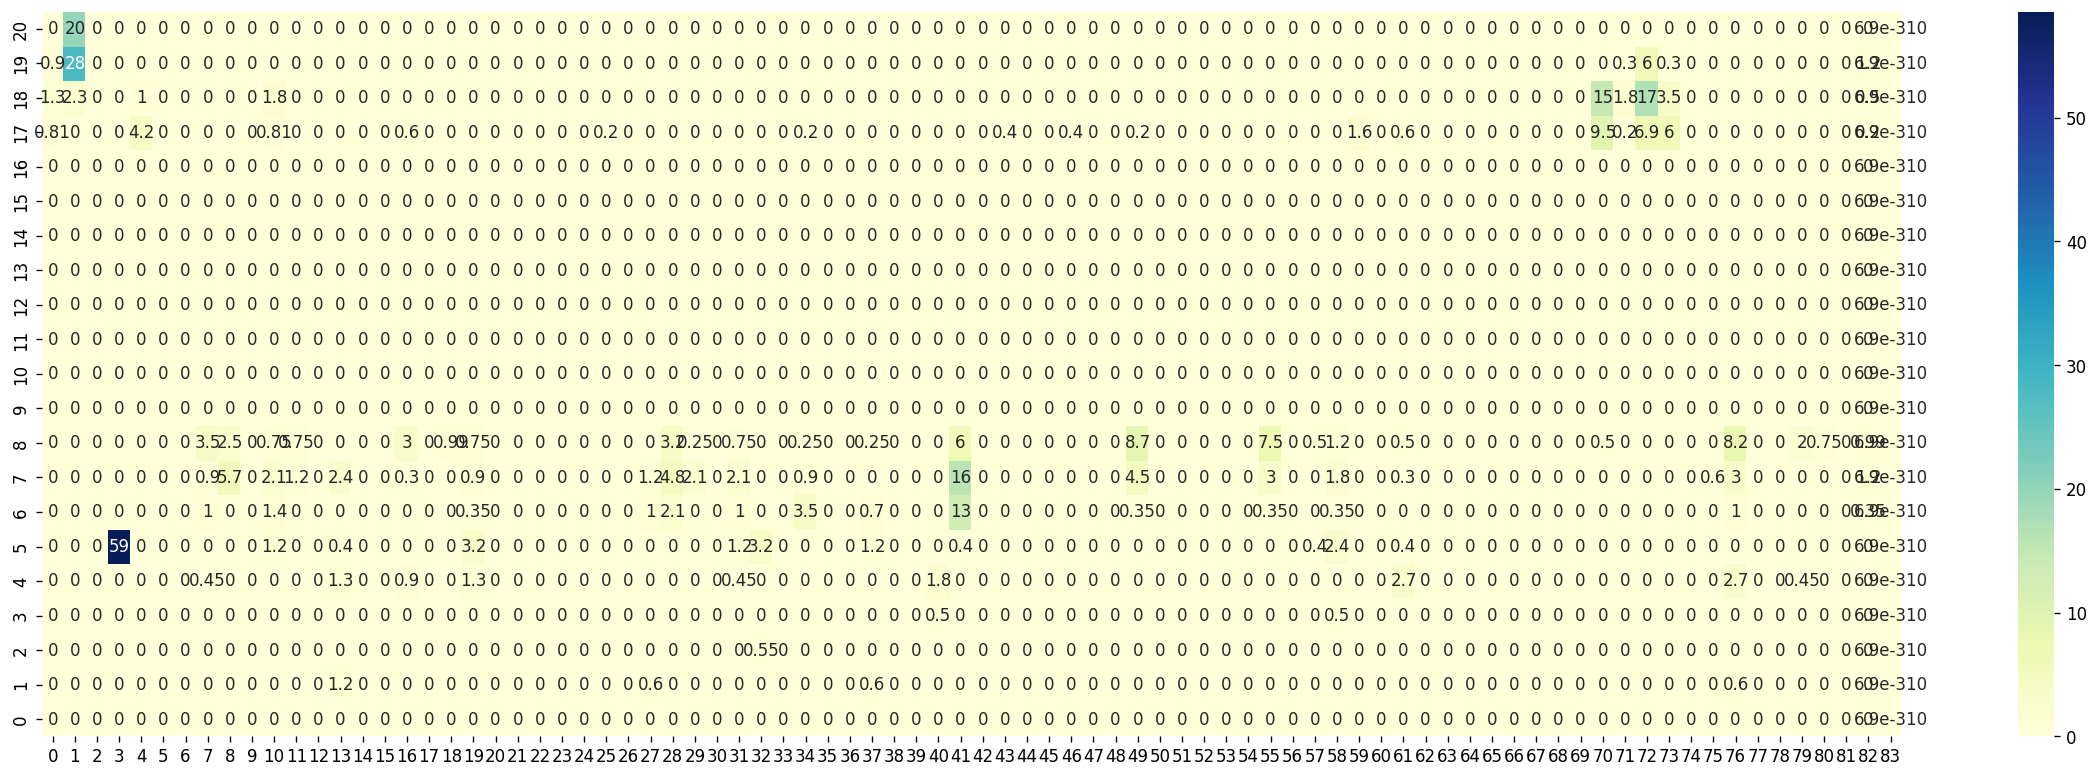

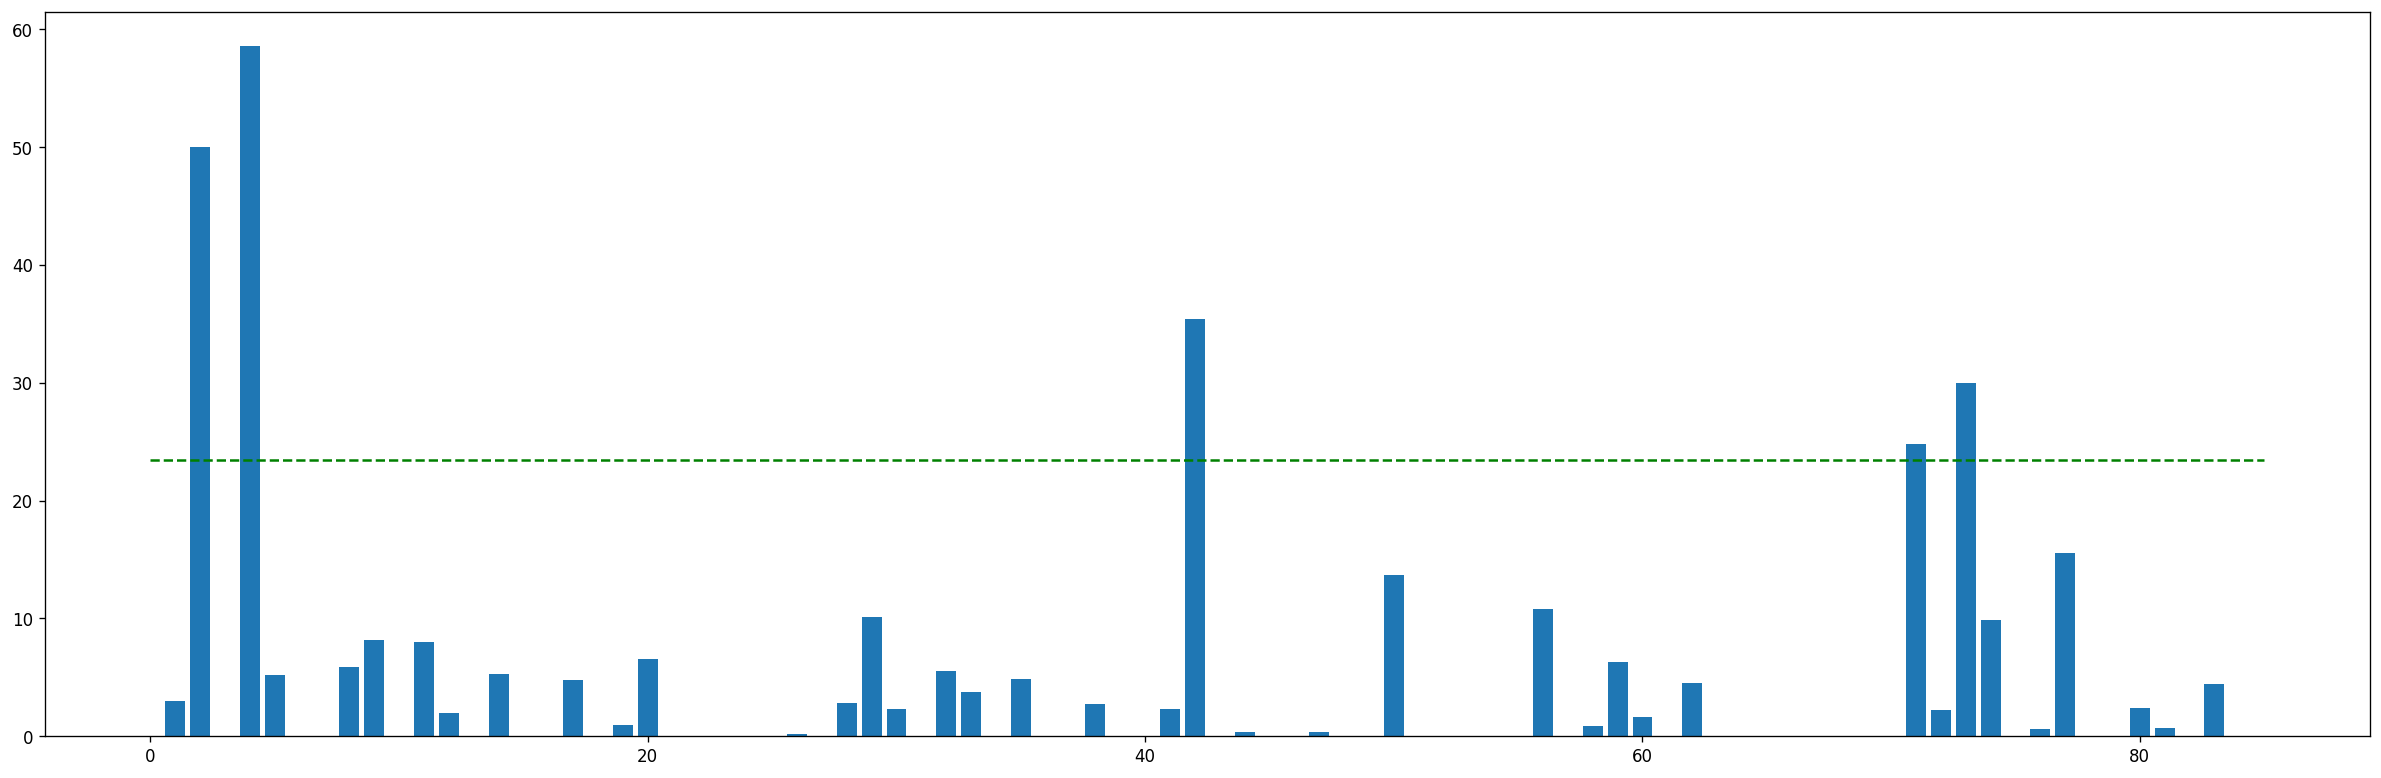

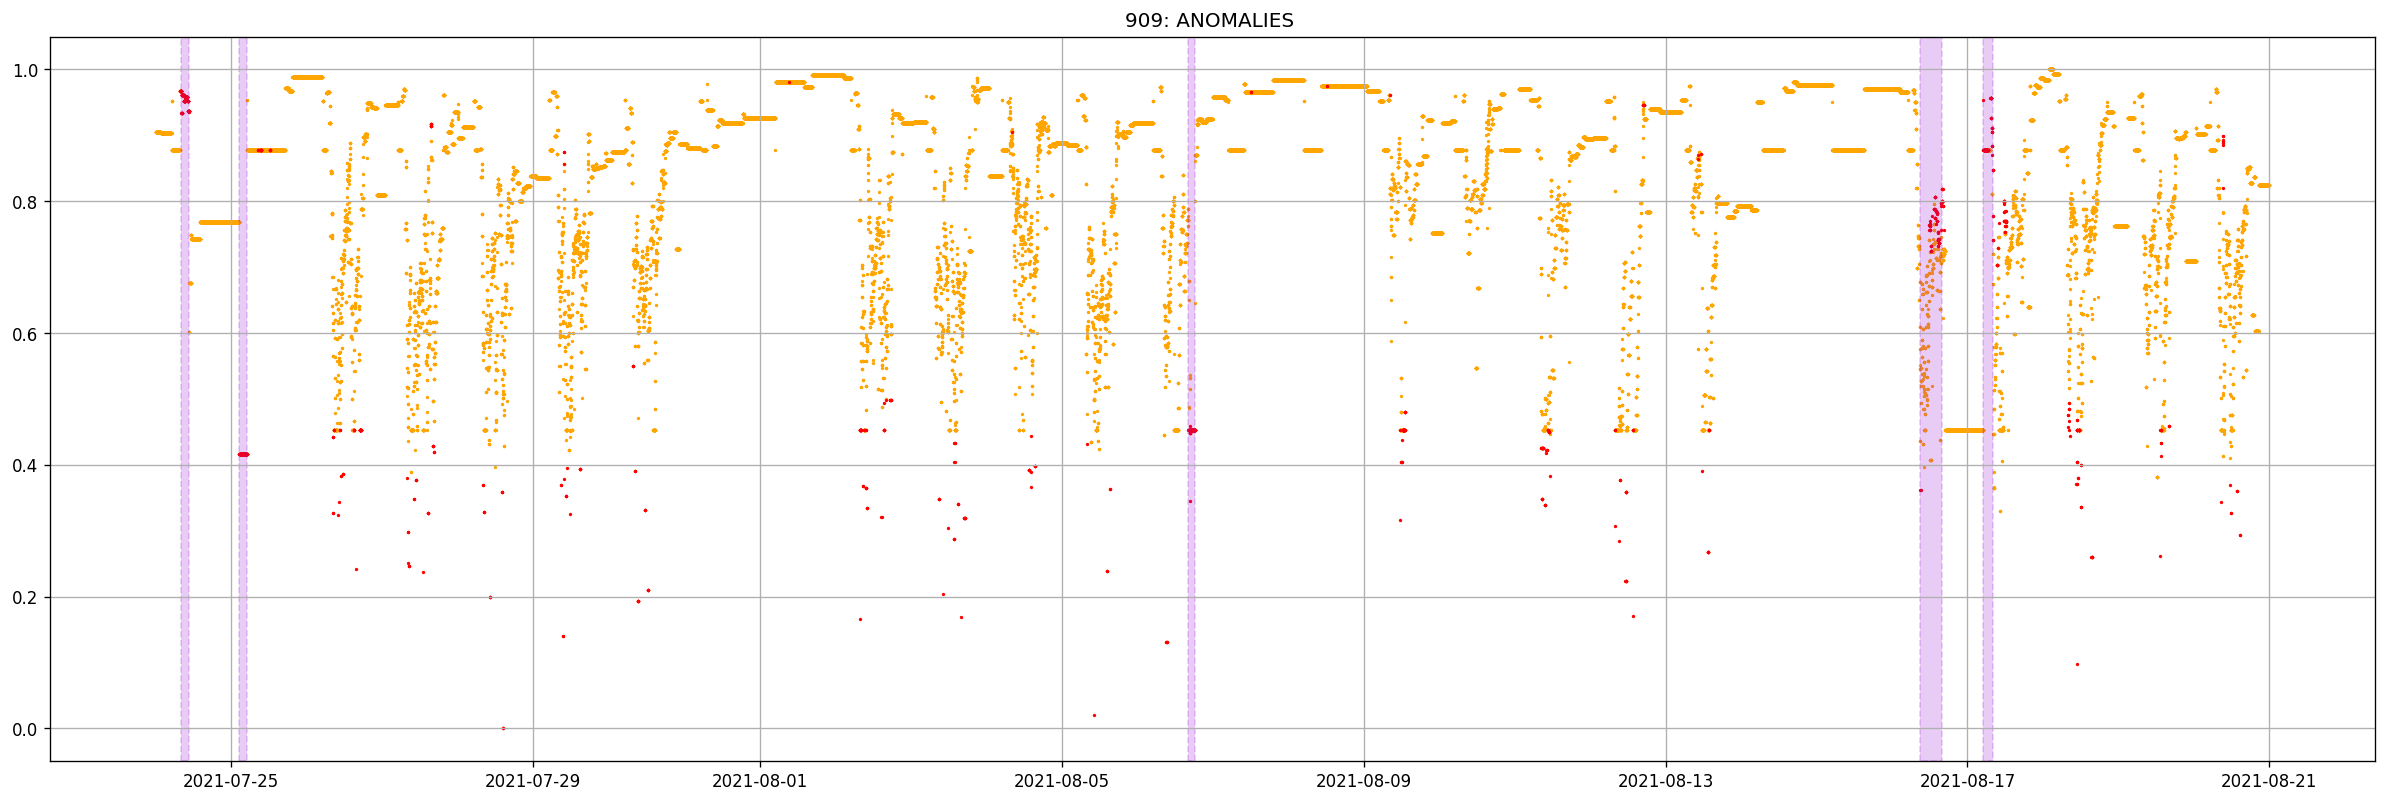

909 execution time :14.439058303833008 seconds


<IPython.core.display.Javascript object>

In [12]:
import seaborn as sns;

outliers_fraction = float(params[col]['ct'])

start_time_all = time.time()
scaler = MinMaxScaler()
tb = widgets.TabBar([columns[i] for i in range(len(columns))])
tmp=0

all_anomalies=pd.DataFrame()

for col in columns:
    start_time = time.time()
    ts=pd.DataFrame(scaler.fit_transform(df[col].values.reshape(-1,1)))
    ts.index = pd.DatetimeIndex(df[col].index)
    ts=ts.asfreq(freq='60s',method='ffill')
   
    

    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      residual = seasonal_decompose(ts, model='additive', extrapolate_trend='freq', freq=period_length).resid

      residual=pd.DataFrame(scaler.fit_transform(residual.values.reshape(-1, 1)))

      avg=np.average(residual[0].values)

      residual.index = pd.DatetimeIndex(ts.index)
      residual=residual.asfreq(freq='60s',method='ffill')

      model =  IsolationForest(contamination=outliers_fraction,random_state=161297)   #10    #ISOLATION FOREST

      #########
      #residual['time_dist']=np.arange(start=0.0,stop=10.0,step=10/len(residual.index))
      #########

      model.fit(residual) 

    forecast=model.predict(residual)
    residual['anomaly_score']=forecast
    out_of_bounds=residual[residual['anomaly_score']==-1]
    in_bounds=residual[residual['anomaly_score']==1]
    db_scan_df=pd.DataFrame(scaler.fit_transform(out_of_bounds[0].values.reshape(-1,1)))
    
    db_scan_df.index = pd.DatetimeIndex(out_of_bounds.index)


    with tb.output_to(col):
      plt.rcParams.update({'figure.figsize': (25, 8), 'figure.dpi': 120})
      plt.scatter(x=in_bounds.index ,y=ts.loc[in_bounds.index], color='orange', label='In bounds',s=1)
      plt.scatter(x=out_of_bounds.index , y=ts.loc[out_of_bounds.index], color='red', label='Out of bounds',s=1)
      i=0

      plt.legend()
      plt.title("%s: ISOLATION FOREST "%(col))
      plt.grid()
      plt.show()

      ###############
      plt.scatter(x=residual.index ,y=residual[0], color='orange', label='In bound',s=1)
      plt.scatter(x=out_of_bounds.index ,y=out_of_bounds[0], color='red', label='Out of bound',s=1)
      plt.grid()
      plt.title("Residual")
      plt.show()


      density=np.empty([28*3, 21])
      anomaly_intervals=[]

      plt.scatter(x=out_of_bounds.index ,y=out_of_bounds[0], color='red', label='Out of bound',s=1)
      i=1
      l=0
      prev_date=out_of_bounds.index[0]
      prev_val=0.0
      for date in ts.index[1:]:
        if i%(60*8)==0:
          #print(i)
          plt.vlines(date, 0, 1, color='grey')
          tmp=out_of_bounds.loc[prev_date:date]
          anomaly_intervals.append((prev_date,date))
          prev_date=date
          k=0
          j=0
          for j in range(0,101,5):
            plt.hlines(j/100,ts.index.min(),ts.index.max(), color='grey')
            density[l,k]=np.where(np.logical_and(tmp[0].values>prev_val, tmp[0].values<=j/100))[0].size*abs((j/100-avg))
            prev_val=j/100
            k=k+1
          l=l+1
        i=i+1
    
      plt.grid()
      plt.show()

      density=np.swapaxes(density,0,1)
      intervals_values=density.sum(axis=0)
      open_interval=0
      anomalies_tmp=[]
      start=anomaly_intervals[0][0]
      stop=anomaly_intervals[0][1]

      treshold= np.percentile(intervals_values, params[col]['thp'])    #############################################

      for i in range(0,len(intervals_values)-1,1):
        if intervals_values[i]>=treshold:
        #if intervals_values[i]>=params[col]['th']:
          if(open_interval==0):
            start=anomaly_intervals[i][0]
            open_interval=1
          stop=anomaly_intervals[i][1]
        else:
          if open_interval==1:
            anomalies_tmp.append((start,stop))
            open_interval=0

      if open_interval==1:
        anomalies_tmp.append((start,stop))

      ax=sns.heatmap(density, vmin=0,annot=True,cmap="YlGnBu")
      ax.invert_yaxis()
      plt.show()
      plt.bar(np.arange(1,len(intervals_values)+1,1),intervals_values)
      #plt.hlines(params[col]['th'],0,85, color='green',linestyles='dashed')
      plt.hlines(treshold,0,85, color='green',linestyles='dashed')  ######################################

      plt.show()

      plt.scatter(x=in_bounds.index ,y=ts.loc[in_bounds.index], color='orange', label='In bounds',s=1)
      plt.scatter(x=out_of_bounds.index , y=ts.loc[out_of_bounds.index], color='red', label='Out of bounds',s=1)

      plt.title("%s: ANOMALIES "%(col))
      
      anomalies=[]
      for i in range(0,len(anomalies_tmp),1):
        rg=out_of_bounds.loc[anomalies_tmp[i][0]:anomalies_tmp[i][1]]
        #print(len(rg))
        anomalies.append((rg.index.min(),rg.index.max()))
        plt.axvspan(rg.index.min(),rg.index.max(), alpha=0.2, color='darkviolet',linewidth=1,linestyle='dashed')
        #print(anomalies[i-1])
      plt.grid()
      plt.show()
        

      print(col+" execution time :"+str(time.time()-start_time)+" seconds")



In [13]:
print("total execution time:"+str(time.time()-start_time_all)+" seconds")

total execution time:114.94273138046265 seconds
